## World Compliance - Carbon Tax & ETS

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mysql.connector
import config
import folium
import json
import urllib
import urllib.request
import matplotlib.colors as mcolors
import branca.colormap as cm


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}

In [3]:
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [4]:
sql_query = """
SELECT 
    `Name`, 
    `Type`, 
    `Status`,
    `Jurisdiction`,
    `Offset eligibility`
FROM 
    `compliance_info`
"""

In [5]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_63890/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Name                                     Type  \
0          Poland carbon tax                      National Carbon tax   
1          Norway carbon tax                      National Carbon tax   
2          Sweden carbon tax                      National Carbon tax   
3         Denmark carbon tax                      National Carbon tax   
4               Alberta TIER         Subnational - State/Province ETS   
..                       ...                                      ...   
112    Mauritania Carbon tax                      National Carbon tax   
113    Philippines Undecided                       National Undecided   
114         Spain carbon tax                      National Carbon tax   
115  South Africa carbon tax                      National Carbon tax   
116     Queretaro carbon tax  Subnational - State/Province Carbon tax   

                             Status  Jurisdiction  \
0               Implemented in 1990        Poland   
1               Implemented in 1991        Norway   
2               Implemented in 1991        Sweden   
3               Implemented in 1992       Denmark   
4               Implemented in 2007       Alberta   
..                              ...           ...   
112  Under consideration since 2024    Mauritania   
113  Under consideration since 2024   Philippines   
114             Implemented in 2014         Spain   
115             Implemented in 2019  South Africa   
116             Implemented in 2022     Queretaro   

               Offset eligibility  
0                   Not permitted  
1                   Not permitted  
2                   Not permitted  
3                   Not permitted  
4    Yes, with quantitative limit  
..                            ...  
112                          None  
113                          None  
114                 Not permitted  
115  Yes, with quantitative limit  
116  Yes, with quantitative limit  

[117 rows x 5 columns]

In [6]:
df['Type'].value_counts()

Type
National Carbon tax                        41
National ETS                               28
Subnational - State/Province ETS           22
Subnational - State/Province Carbon tax    13
Subnational - City ETS                      7
National Undecided                          2
Regional ETS                                2
Subnational - State or Province ETS         1
National                                    1
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                117 non-null    object
 1   Type                117 non-null    object
 2   Status              117 non-null    object
 3   Jurisdiction        117 non-null    object
 4   Offset eligibility  102 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [8]:
df['Jurisdiction'].value_counts()

Jurisdiction
Canada                       3
Taiwan                       2
Ukraine                      2
Chile                        2
South Africa                 2
                            ..
Massachusetts                1
Newfoundland and Labrador    1
China                        1
Singapore                    1
Queretaro                    1
Name: count, Length: 102, dtype: int64

In [9]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = df


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Cameroon', 'Greenland', 'Kosovo', 'Panama', 'Syria', 'Jamaica', 'Croatia', 'Burkina Faso', 'Iran', 'South Sudan', 'Peru', 'Antarctica', 'Cuba', 'Sierra Leone', 'Djibouti', 'El Salvador', 'Republic of the Congo', 'Haiti', 'Guinea Bissau', 'Ivory Coast', 'Myanmar', 'Rwanda', 'Oman', 'Ecuador', 'Tunisia', 'Armenia', 'Ethiopia', 'Brunei', 'Honduras', 'Kuwait', 'Nicaragua', 'Falkland Islands', 'Cambodia', 'Italy', 'Russia', 'Mongolia', 'Democratic Republic of the Congo', 'Liberia', 'Togo', 'Zimbabwe', 'United States of America', 'Chad', 'Suriname', 'Zambia', 'Qatar', 'Bangladesh', 'Angola', 'French Southern and Antarctic Lands', 'United Arab Emirates', 'Swaziland', 'Dominican Republic', 'Republic of Serbia', 'Libya', 'Northern Cyprus', 'East Timor', 'Turkey', 'Saudi Arabia', 'Solomon Islands', 'Egypt', 'Bulgaria', 'Bhutan', 'Algeria', 'Lebanon', 'Namibia', 'Mali', 'Eritrea', 'Papua New Guinea', 'Czech Republic', 'Greece', 'Guatemala', 

In [10]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {
    'New York State': 'United States of America',
    'Tianjin': 'China',
    'New Brunswick': 'Canada',
    'Shenzhen': 'China',
    'Maryland': 'United States of America',
    'Ontario': 'Canada',
    'Manitoba': 'Canada',
    'Korea, Rep.': 'South Korea',
    'Quebec': 'Canada',
    'Northwest Territories': 'Canada',
    'San Luis Potosí': 'Mexico',
    'Jalisco': 'Mexico',
    'Sakhalin': 'Russia',
    'Guangdong (except Shenzhen)': 'China',
    'Chongqing': 'China',
    'Massachusetts': 'United States of America',
    'Saitama': 'Japan',
    'Alberta': 'Canada',
    'EU': None,
    'Hawaii': 'United States of America',
    'Colorado': 'United States of America',
    'Türkiye': 'Turkey',
    'Saskatchewan': 'Canada',
    'Oregon': 'United States of America',
    'Pennsylvania': 'United States of America',
    'State of Mexico': 'Mexico',
    'Washington': 'United States of America',
    'Zacatecas': 'Mexico',
    'Yucatan': 'Mexico',
    'Catalonia': 'Spain',
    'Nova Scotia': 'Canada',
    'RGGI': 'United States of America',
    'British Columbia': 'Canada',
    'EU27+': None,
    'Shanghai': 'China',
    'Hubei': 'China',
    'Beijing': 'China',
    'Fujian':'China',
    'California': 'United States of America',
    'Queretaro': 'Mexico',
    'Durango': 'Mexico',
    'Côte d’Ivoire': 'Ivory Coast',  # 更新為正式名稱
    'Brunei Darussalam': 'Brunei',
    'Guanajuato': 'Mexico',
    'Newfoundland and Labrador': 'Canada',
    'Viet Nam': 'Vietnam',  # 更新為正式名稱
    'Tokyo': 'Japan',
    'Colima': 'Mexico'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)
    

Countries present in Jurisdiction but not in GeoJSON after mapping:
{'Liechtenstein', 'Singapore', None}


In [11]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
with urllib.request.urlopen(world_geojson_url) as response:
    world_geojson = json.load(response)

sg_in_geojson = False
for feature in world_geojson['features']:
    if feature['properties']['name'] == 'Singapore':
        sg_in_geojson = True
        break

if sg_in_geojson:
    print('Singapore is in the GeoJSON data.')
else:
    print('Singapore is not in the GeoJSON data.')

li_in_geojson = False
for feature in world_geojson['features']:
    if feature['properties']['name'] == 'Liechtenstein':
        li_in_geojson = True
        break

if li_in_geojson:
    print('Liechtenstein is in the GeoJSON data.')
else:
    print('Liechtenstein is not in the GeoJSON data.')

Singapore is not in the GeoJSON data.
Liechtenstein is not in the GeoJSON data.


In [12]:
# Get unique counts of mechanisms for each country
mechanism_counts = data.groupby('Jurisdiction')['Name'].nunique()

m = folium.Map(location=[0, 0], zoom_start=2, min_zoom=2, max_zoom=10)

# Color mapping palette
sns_palette = sns.color_palette('crest')

# Define the style function
def style_function(feature):
    country_name = feature['properties']['name']
    corrected_country_name = country_name_mapping.get(country_name, country_name)  # Use country name mapping dictionary for correction
    if corrected_country_name in data['Jurisdiction'].values:
        # Get data for the current country
        country_data = data[data['Jurisdiction'] == corrected_country_name]
        # Count the number of mechanisms for the current country
        num_mechanisms = country_data['Name'].nunique()
        # Assign color based on the number of mechanisms
        if num_mechanisms == 0:
            country_color = '#e8dfd8'  # Default color if no mechanisms
        else:
            # Determine the color index based on the percentage of maximum count
            max_count = mechanism_counts.max()
            color_index = int((num_mechanisms / max_count) * (len(sns_palette) - 2))
            country_color = mcolors.rgb2hex(sns_palette[color_index])
    else:
        country_color = '#e8dfd8'  # Default color if country not found in data

    return {
        'fillColor': country_color,
        'fillOpacity': 0.7,
        'weight': 1.0,
        'color': None
    }

# Add GeoJSON layer with tooltips and colours
for feature in world_geojson['features']:
    country_name = feature['properties']['name']
    if country_name in data['Jurisdiction'].values:
        # Get data for the current country
        country_data = data[data['Jurisdiction'] == country_name]
        # Construct tooltip content
        names = "<br>".join(country_data['Name'].tolist())  # Concatenate all names with <br> as separator
        tooltip = folium.Tooltip(f"""
            Country: {country_name}<br>
            Names: {names}<br>
        """)

        folium.GeoJson(
            feature, 
            tooltip=tooltip, 
            style_function=style_function
        ).add_to(m)

# palette
cmap = sns.color_palette('crest', as_cmap=True)

# colormap
colormap = cm.LinearColormap(
    cmap.colors,
    vmin=1, # min=1, not 0(Not Applicable)
    vmax=max(mechanism_counts),
    caption='Mechanism Count'
)


# colormap = cm.LinearColormap(
#     cmap.colors,
#     vmin=1, # min=1, not 0(Not Applicable)
#     vmax=max(country_counts.values()),
#     caption='Mechanism Count'
# )

colormap.add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 30px; width: 180px; height: 80px; 
                 border:2px solid grey; z-index:9999; font-size:11px;
                 background-color:white; opacity: 0.8; padding: 10px;">
     </div>
     '''
m.save('map.html')
m

In [13]:
# 利用country_name_mapping重新命名
df['Jurisdiction'] = df['Jurisdiction'].replace(country_name_mapping)
df

Name                                     Type  \
0          Poland carbon tax                      National Carbon tax   
1          Norway carbon tax                      National Carbon tax   
2          Sweden carbon tax                      National Carbon tax   
3         Denmark carbon tax                      National Carbon tax   
4               Alberta TIER         Subnational - State/Province ETS   
..                       ...                                      ...   
112    Mauritania Carbon tax                      National Carbon tax   
113    Philippines Undecided                       National Undecided   
114         Spain carbon tax                      National Carbon tax   
115  South Africa carbon tax                      National Carbon tax   
116     Queretaro carbon tax  Subnational - State/Province Carbon tax   

                             Status  Jurisdiction  \
0               Implemented in 1990        Poland   
1               Implemented in 1991        Norway   
2               Implemented in 1991        Sweden   
3               Implemented in 1992       Denmark   
4               Implemented in 2007        Canada   
..                              ...           ...   
112  Under consideration since 2024    Mauritania   
113  Under consideration since 2024   Philippines   
114             Implemented in 2014         Spain   
115             Implemented in 2019  South Africa   
116             Implemented in 2022        Mexico   

               Offset eligibility  
0                   Not permitted  
1                   Not permitted  
2                   Not permitted  
3                   Not permitted  
4    Yes, with quantitative limit  
..                            ...  
112                          None  
113                          None  
114                 Not permitted  
115  Yes, with quantitative limit  
116  Yes, with quantitative limit  

[117 rows x 5 columns]

In [14]:
df['Jurisdiction'].value_counts()

Jurisdiction
Canada                      15
Mexico                      11
United States of America    10
China                        9
Japan                        4
                            ..
Israel                       1
Malaysia                     1
Pakistan                     1
Russia                       1
Philippines                  1
Name: count, Length: 61, dtype: int64

In [15]:
df['Type'].value_counts()

Type
National Carbon tax                        41
National ETS                               28
Subnational - State/Province ETS           22
Subnational - State/Province Carbon tax    13
Subnational - City ETS                      7
National Undecided                          2
Regional ETS                                2
Subnational - State or Province ETS         1
National                                    1
Name: count, dtype: int64

In [16]:
# 定義函數設定Type
def map_type(row):
    if row['Type'] == 'National Carbon tax':
        return 'National'
    elif row['Type'] == 'National ETS':
        return 'National'
    elif row['Type'] == 'National Undecided':
        return 'National'
    elif row['Type'] == 'National':
        return 'National'
    elif row['Type'] == 'Regional ETS':
        return 'Regional'
    else:
        return 'Subnational'

# 使用 apply 函數創建新的列
df['Category'] = df.apply(map_type, axis=1)
df.tail()

Name                                     Type  \
112    Mauritania Carbon tax                      National Carbon tax   
113    Philippines Undecided                       National Undecided   
114         Spain carbon tax                      National Carbon tax   
115  South Africa carbon tax                      National Carbon tax   
116     Queretaro carbon tax  Subnational - State/Province Carbon tax   

                             Status  Jurisdiction  \
112  Under consideration since 2024    Mauritania   
113  Under consideration since 2024   Philippines   
114             Implemented in 2014         Spain   
115             Implemented in 2019  South Africa   
116             Implemented in 2022        Mexico   

               Offset eligibility     Category  
112                          None     National  
113                          None     National  
114                 Not permitted     National  
115  Yes, with quantitative limit     National  
116  Yes, with quantitative limit  Subnational

In [17]:
df['Status'].value_counts()

Status
Implemented in 2019               9
Implemented in 2013               8
Implemented in 2022               7
Under consideration since 2024    7
Under consideration since 2021    6
Under consideration since 2022    6
Implemented in 2021               6
Implemented in 2008               5
Implemented in 2014               5
Under development since 2016      5
Implemented in 2023               5
Under development since 2024      4
Implemented in 2010               3
Under consideration since 2018    3
Implemented in 2017               3
Under consideration since 2016    3
Under development since 2023      2
Implemented in 1991               2
Implemented in 2024               2
Implemented in 1990               2
Implemented in 2018               2
Implemented in 2016               2
Implemented in 2015               2
Implemented in 2012               2
Implemented in 2011               2
Implemented in 2009               1
Implemented in 2005               1
Implemented in 2004  

In [18]:
# 正則表達式自定函數設定Stats
import re

def find(df):
    pattern = r"Implemented"
    matches = re.findall(pattern, df, re.IGNORECASE)
    return 'Implemented' if matches else 'Under consideration'

# 使用 apply 函数创建新的列
df['Status_new'] = df['Status'].apply(find)

# 查看结果
df

Name                                     Type  \
0          Poland carbon tax                      National Carbon tax   
1          Norway carbon tax                      National Carbon tax   
2          Sweden carbon tax                      National Carbon tax   
3         Denmark carbon tax                      National Carbon tax   
4               Alberta TIER         Subnational - State/Province ETS   
..                       ...                                      ...   
112    Mauritania Carbon tax                      National Carbon tax   
113    Philippines Undecided                       National Undecided   
114         Spain carbon tax                      National Carbon tax   
115  South Africa carbon tax                      National Carbon tax   
116     Queretaro carbon tax  Subnational - State/Province Carbon tax   

                             Status  Jurisdiction  \
0               Implemented in 1990        Poland   
1               Implemented in 1991        Norway   
2               Implemented in 1991        Sweden   
3               Implemented in 1992       Denmark   
4               Implemented in 2007        Canada   
..                              ...           ...   
112  Under consideration since 2024    Mauritania   
113  Under consideration since 2024   Philippines   
114             Implemented in 2014         Spain   
115             Implemented in 2019  South Africa   
116             Implemented in 2022        Mexico   

               Offset eligibility     Category           Status_new  
0                   Not permitted     National          Implemented  
1                   Not permitted     National          Implemented  
2                   Not permitted     National          Implemented  
3                   Not permitted     National          Implemented  
4    Yes, with quantitative limit  Subnational          Implemented  
..                            ...          ...                  ...  
112                          None     National  Under consideration  
113                          None     National  Under consideration  
114                 Not permitted     National          Implemented  
115  Yes, with quantitative limit     National          Implemented  
116  Yes, with quantitative limit  Subnational          Implemented  

[117 rows x 7 columns]

In [19]:
df['Status_new'].value_counts()

Status_new
Implemented            75
Under consideration    42
Name: count, dtype: int64

### 目前全球已經開始實行的合規機制數量為75個（64%），還沒正式上路、仍在計畫中的為42個（36%）

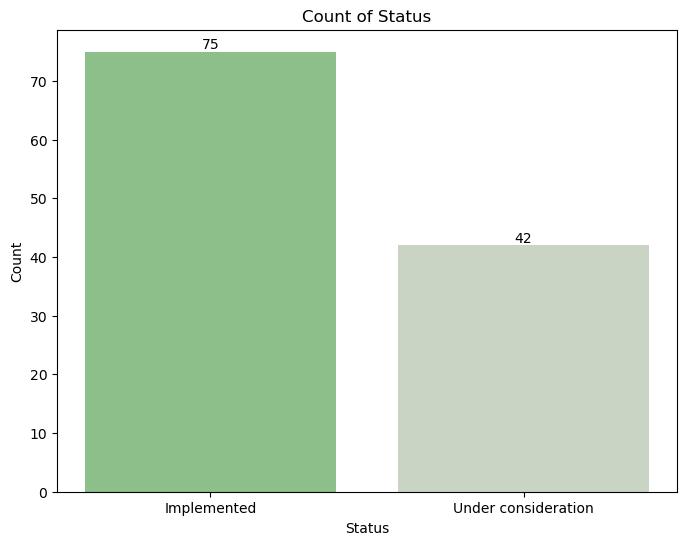

In [20]:
status_data = pd.DataFrame({'Status_new': ['Implemented', 'Under consideration'], 'count': [75, 42]})

colors=['#8dbf8b', '#C9D4C5']

plt.figure(figsize=(8, 6))
bars = plt.bar(status_data['Status_new'], status_data['count'], color=colors)

# 標數值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of Status')

plt.show()

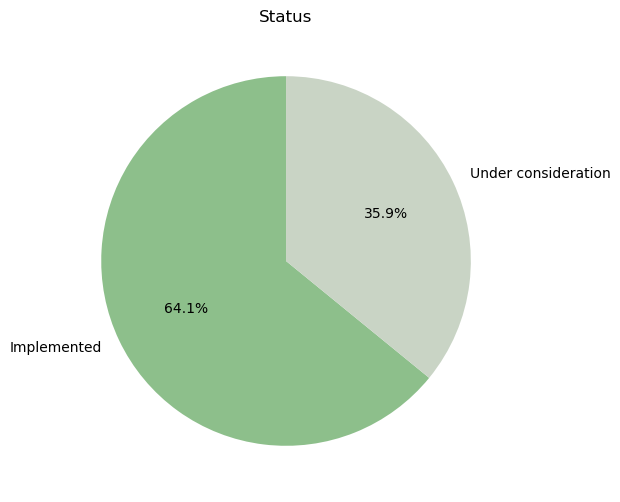

In [21]:
status_data = pd.DataFrame({'Status_new': ['Implemented', 'Under consideration'], 'count': [75, 42]})

colors=['#8dbf8b', '#C9D4C5']

plt.figure(figsize=(8, 6))
plt.pie(status_data['count'], labels=status_data['Status_new'], colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Status')

plt.show()

In [22]:
# 只留下已實施的國家
df = df[df['Status_new'] == 'Implemented']
df

Name                                     Type  \
0          Poland carbon tax                      National Carbon tax   
1          Norway carbon tax                      National Carbon tax   
2          Sweden carbon tax                      National Carbon tax   
3         Denmark carbon tax                      National Carbon tax   
4               Alberta TIER         Subnational - State/Province ETS   
..                       ...                                      ...   
100       Estonia carbon tax                      National Carbon tax   
105              Austria ETS                             National ETS   
114         Spain carbon tax                      National Carbon tax   
115  South Africa carbon tax                      National Carbon tax   
116     Queretaro carbon tax  Subnational - State/Province Carbon tax   

                  Status  Jurisdiction            Offset eligibility  \
0    Implemented in 1990        Poland                 Not permitted   
1    Implemented in 1991        Norway                 Not permitted   
2    Implemented in 1991        Sweden                 Not permitted   
3    Implemented in 1992       Denmark                 Not permitted   
4    Implemented in 2007        Canada  Yes, with quantitative limit   
..                   ...           ...                           ...   
100  Implemented in 2000       Estonia                 Not permitted   
105  Implemented in 2022       Austria                 Not permitted   
114  Implemented in 2014         Spain                 Not permitted   
115  Implemented in 2019  South Africa  Yes, with quantitative limit   
116  Implemented in 2022        Mexico  Yes, with quantitative limit   

        Category   Status_new  
0       National  Implemented  
1       National  Implemented  
2       National  Implemented  
3       National  Implemented  
4    Subnational  Implemented  
..           ...          ...  
100     National  Implemented  
105     National  Implemented  
114     National  Implemented  
115     National  Implemented  
116  Subnational  Implemented  

[75 rows x 7 columns]

In [23]:
# 分別計算National、Subnational數量
national_counts = df[df['Category'] == 'National'].groupby(['Jurisdiction', 'Status_new']).size()
subnational_counts = df[df['Category'] == 'Subnational'].groupby(['Jurisdiction', 'Status_new']).size()

print(national_counts)
print(subnational_counts)

Jurisdiction    Status_new 
Albania         Implemented    1
Argentina       Implemented    1
Australia       Implemented    1
Austria         Implemented    1
Canada          Implemented    2
Chile           Implemented    1
China           Implemented    1
Colombia        Implemented    1
Denmark         Implemented    1
Estonia         Implemented    1
Finland         Implemented    1
France          Implemented    1
Germany         Implemented    1
Hungary         Implemented    1
Iceland         Implemented    1
Indonesia       Implemented    1
Ireland         Implemented    1
Japan           Implemented    1
Kazakhstan      Implemented    1
Latvia          Implemented    1
Liechtenstein   Implemented    1
Luxembourg      Implemented    1
Mexico          Implemented    2
Montenegro      Implemented    1
Netherlands     Implemented    1
New Zealand     Implemented    1
Norway          Implemented    1
Poland          Implemented    1
Portugal        Implemented    1
Singapore      

### 已實行的機制可以分為國家性（National）、地區性（Subnational）、區域性（Regional）三種，但因為區域性涵蓋的國家超過一個，無法對應到相應國名，所以在這除去歐盟ETS，來細看各國實行中的機制數量如下

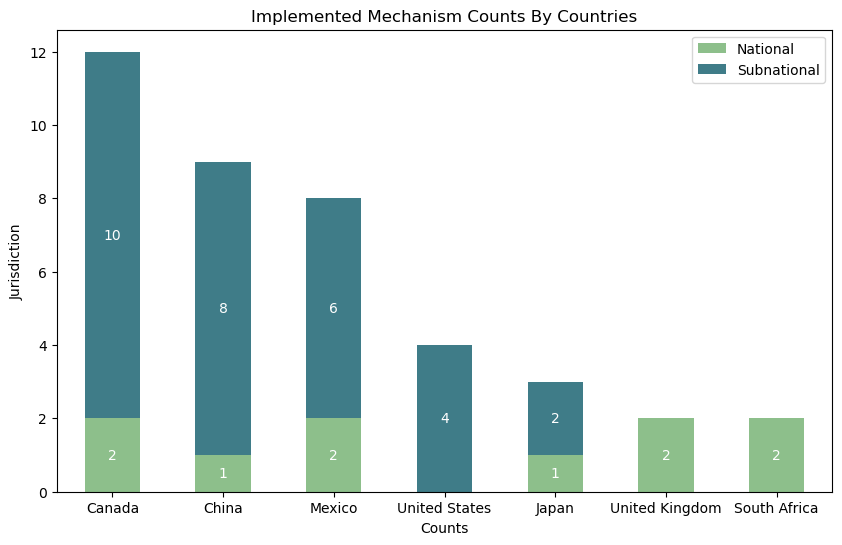

In [24]:
# 合併 National 和 Subnational 資料
merged_counts = pd.concat([national_counts, subnational_counts], axis=1)
merged_counts.columns = ['National', 'Subnational']

# 替換'United States of America'為'United States'
merged_counts.rename(index={'United States of America': 'United States'}, inplace=True)

# 計算每個jurisdiction的總數量並排序
merged_counts['Total'] = merged_counts.sum(axis=1)  # 計算總數量
merged_counts = merged_counts.sort_values(by='Total', ascending=False) 

# 提取索引中的國家名稱作為 x 軸標籤
countries = merged_counts.index.get_level_values(0)[:7]  # 只取值>1

ax = merged_counts.head(7).drop(columns='Total').plot(kind='bar', stacked=True, figsize=(10, 6), color=['#8dbf8b', '#3F7C88'])

for p in ax.patches:
    width = p.get_width()  # width
    height = p.get_height()  # height
    x, y = p.get_xy()  # 起始點座標
    if height > 0: 
        ax.annotate(f'{height:.0f}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')
        
    
# 設置標籤和標題
plt.xlabel('Counts')
plt.ylabel('Jurisdiction')
plt.title('Implemented Mechanism Counts By Countries')
plt.xticks(range(len(countries)), countries, rotation=0)

# 顯示圖形
plt.show()

---

## Compliance Revenues

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mysql.connector
import config
import folium
import json
import urllib
import urllib.request
import matplotlib.colors as mcolors


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}

In [3]:
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [4]:
sql_query = """
SELECT * FROM `compliance_revenue`
"""

In [5]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_63993/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Name        Type     Jurisdiction     2007     2008  \
0           Finland carbon tax  Carbon tax          Finland   706.43   644.52   
1            Poland carbon tax  Carbon tax           Poland     1.64     1.12   
2            Norway carbon tax  Carbon tax           Norway  1558.54  1206.16   
3            Sweden carbon tax  Carbon tax           Sweden  4200.08  3090.90   
4           Denmark carbon tax  Carbon tax          Denmark  1079.26   912.86   
..                         ...         ...              ...      ...      ...   
78  Baja California carbon tax  Carbon tax  Baja California                     
79       Tamaulipas carbon tax  Carbon tax       Tamaulipas        0        0   
80               Australia CPM         ETS        Australia        0        0   
81          Alberta carbon tax  Carbon tax          Alberta        0        0   
82                 Ontario CaT         ETS          Ontario        0        0   

       2009     2010     2011      2012      2013      2014      2015  \
0    544.66   689.62   936.35   1283.22   1427.17  1137.057      1456   
1      1.35     1.43     1.41      1.39      1.52     1.223     1.211   
2   1150.51  1272.46  1278.19      1208   1392.51  1247.205  1500.436   
3   3611.36  4323.29  3841.11   3894.80   3725.27  2704.366  3046.353   
4    913.08  1102.43  1068.29    989.51   1098.51   531.642   567.737   
..      ...      ...      ...       ...       ...       ...       ...   
78                                                                      
79        0        0        0         0         0         0         0   
80        0        0        0  3415.035  6226.790  2640.369         0   
81        0        0        0         0         0         0         0   
82        0        0        0         0         0         0         0   

             2016           2017           2018           2019           2020  \
0        1349.691       1351.745       1609.415       1458.572       1419.493   
1           1.211          1.142          1.327          1.218          5.936   
2        1544.153       1498.542       1812.840       1650.773       1454.774   
3        2809.968       2648.175       2879.056       2492.295       2004.256   
4         567.737        513.139        600.654        534.249        534.777   
..            ...            ...            ...            ...            ...   
78         0.0000         0.0000         0.0000         0.0000         0.0000   
79         0.0000         0.0000         0.0000         0.0000         0.0000   
80  Not available  Not available  Not available  Not available  Not available   
81  Not available       692.7151      1047.1243      1012.9706  Not available   
82  Not available      1120.3903       551.6043       533.6128  Not available   

             2021           2022           2023  
0        1644.440       1734.451       1418.644  
1           1.220          6.623          1.258  
2        1759.786       2157.497       1507.941  
3        2435.323       2342.245       2173.094  
4         496.418        467.831        479.195  
..            ...            ...            ...  
78         1.1787         1.2142  Not available  
79         0.0000         1.8964         0.0000  
80  Not available  Not available  Not available  
81  Not available  Not available  Not available  
82  Not available  Not available  Not available  

[83 rows x 20 columns]

In [6]:
df['Type'].value_counts()

Type
Carbon tax    45
ETS           38
Name: count, dtype: int64

In [7]:
df_tax = df[df['Type'] == 'Carbon tax']
df_tax.head()

Name        Type Jurisdiction     2007     2008     2009  \
0  Finland carbon tax  Carbon tax      Finland   706.43   644.52   544.66   
1   Poland carbon tax  Carbon tax       Poland     1.64     1.12     1.35   
2   Norway carbon tax  Carbon tax       Norway  1558.54  1206.16  1150.51   
3   Sweden carbon tax  Carbon tax       Sweden  4200.08  3090.90  3611.36   
4  Denmark carbon tax  Carbon tax      Denmark  1079.26   912.86   913.08   

      2010     2011     2012     2013      2014      2015      2016      2017  \
0   689.62   936.35  1283.22  1427.17  1137.057      1456  1349.691  1351.745   
1     1.43     1.41     1.39     1.52     1.223     1.211     1.211     1.142   
2  1272.46  1278.19     1208  1392.51  1247.205  1500.436  1544.153  1498.542   
3  4323.29  3841.11  3894.80  3725.27  2704.366  3046.353  2809.968  2648.175   
4  1102.43  1068.29   989.51  1098.51   531.642   567.737   567.737   513.139   

       2018      2019      2020      2021      2022      2023  
0  1609.415  1458.572  1419.493  1644.440  1734.451  1418.644  
1     1.327     1.218     5.936     1.220     6.623     1.258  
2  1812.840  1650.773  1454.774  1759.786  2157.497  1507.941  
3  2879.056  2492.295  2004.256  2435.323  2342.245  2173.094  
4   600.654   534.249   534.777   496.418   467.831   479.195

In [8]:
df_ets = df[df['Type'] == 'ETS']
df_ets.head()

Name Type Jurisdiction   2007    2008    2009     2010  \
8            EU ETS  ETS           EU      0   85.57  463.97  1879.39   
9      Alberta TIER  ETS      Alberta  44.01   69.84   65.81    81.94   
10  Switzerland ETS  ETS  Switzerland      0       0       0        0   
11  New Zealand ETS  ETS  New Zealand      0       0       0     0.36   
14             RGGI  ETS         RGGI      0  145.07  349.36   283.08   

       2011     2012     2013      2014      2015      2016      2017  \
8   1295.43  1632.32  4983.43  3407.877  5639.405  4506.722  5906.509   
9     63.43    92.16    85.61    66.841    63.923   103.932   101.879   
10        0        0        0     8.585     4.967     4.182     4.697   
11     1.42     1.06     0.00     0.000     0.000     0.001     0.024   
14   174.64   167.65   447.97   367.287   435.977   266.466   198.376   

         2018       2019       2020       2021       2022       2023  
8   17597.546  16450.445  20992.751  36481.590  42837.663  47369.438  
9     352.077    391.862    301.576    292.280    475.943    638.439  
10      4.639      8.600      7.562     17.124     47.069     39.155  
11      0.382    286.944    128.140   1661.478   1405.987     21.787  
14    239.360    283.989    416.300    926.000   1193.600   1264.941

In [9]:
# transpose year
ts_tax = df_tax.melt(id_vars=['Name', 'Type', 'Jurisdiction'], var_name='Year', value_name='tax_Revenue')
ts_tax

Name        Type  \
0                      Finland carbon tax  Carbon tax   
1                       Poland carbon tax  Carbon tax   
2                       Norway carbon tax  Carbon tax   
3                       Sweden carbon tax  Carbon tax   
4                      Denmark carbon tax  Carbon tax   
..                                    ...         ...   
760  Newfoundland and Labrador carbon tax  Carbon tax   
761              New Brunswick carbon tax  Carbon tax   
762            Baja California carbon tax  Carbon tax   
763                 Tamaulipas carbon tax  Carbon tax   
764                    Alberta carbon tax  Carbon tax   

                  Jurisdiction  Year    tax_Revenue  
0                      Finland  2007         706.43  
1                       Poland  2007           1.64  
2                       Norway  2007        1558.54  
3                       Sweden  2007        4200.08  
4                      Denmark  2007        1079.26  
..                         ...   ...            ...  
760  Newfoundland and Labrador  2023        25.8627  
761              New Brunswick  2023       118.2295  
762            Baja California  2023  Not available  
763                 Tamaulipas  2023         0.0000  
764                    Alberta  2023  Not available  

[765 rows x 5 columns]

In [10]:
# transpose year
ts_ets = df_ets.melt(id_vars=['Name', 'Type', 'Jurisdiction'], var_name='Year', value_name='ets_Revenue')
ts_ets

Name Type    Jurisdiction  Year    ets_Revenue
0             EU ETS  ETS              EU  2007              0
1       Alberta TIER  ETS         Alberta  2007          44.01
2    Switzerland ETS  ETS     Switzerland  2007              0
3    New Zealand ETS  ETS     New Zealand  2007              0
4               RGGI  ETS            RGGI  2007              0
..               ...  ...             ...   ...            ...
641   Montenegro ETS  ETS      Montenegro  2023  Not available
642           UK ETS  ETS  United Kingdom  2023      5201.2627
643      Austria ETS  ETS         Austria  2023       917.0888
644    Australia CPM  ETS       Australia  2023  Not available
645      Ontario CaT  ETS         Ontario  2023  Not available

[646 rows x 5 columns]

In [11]:
ts_tax['tax_Revenue'] = pd.to_numeric(ts_tax['tax_Revenue'], errors='coerce')
ts_tax_sum = ts_tax.groupby('Year')['tax_Revenue'].sum().reset_index()

ts_tax_sum['Year'] = pd.to_datetime(ts_tax_sum['Year'], format='%Y')

ts_tax_sum

Year  tax_Revenue
0  2007-01-01    7615.3200
1  2008-01-01    6241.4329
2  2009-01-01    7002.8354
3  2010-01-01    9136.8813
4  2011-01-01    9070.1887
5  2012-01-01   10013.4061
6  2013-01-01   12179.3825
7  2014-01-01   12103.4399
8  2015-01-01   16580.1280
9  2016-01-01   17623.0457
10 2017-01-01   19660.2399
11 2018-01-01   25612.1954
12 2019-01-01   25336.8435
13 2020-01-01   24647.2885
14 2021-01-01   29001.8132
15 2022-01-01   30572.5755
16 2023-01-01   29294.7638

In [12]:
ts_ets['ets_Revenue'] = pd.to_numeric(ts_ets['ets_Revenue'], errors='coerce')
ts_ets_sum = ts_ets.groupby('Year')['ets_Revenue'].sum().reset_index()

ts_ets_sum['Year'] = pd.to_datetime(ts_ets_sum['Year'], format='%Y')

ts_ets_sum

Year  ets_Revenue
0  2007-01-01      44.0100
1  2008-01-01     300.4800
2  2009-01-01     879.1400
3  2010-01-01    2244.7700
4  2011-01-01    1534.9200
5  2012-01-01    5363.9850
6  2013-01-01   12249.8700
7  2014-01-01    7058.8190
8  2015-01-01    9359.2120
9  2016-01-01    6042.1756
10 2017-01-01    9717.4193
11 2018-01-01   22365.9436
12 2019-01-01   21966.0234
13 2020-01-01   24478.0760
14 2021-01-01   59311.6739
15 2022-01-01   66857.0037
16 2023-01-01   75033.3922

In [13]:
ts_tax_sum.set_index('Year', inplace=True)
ts_ets_sum.set_index('Year', inplace=True)

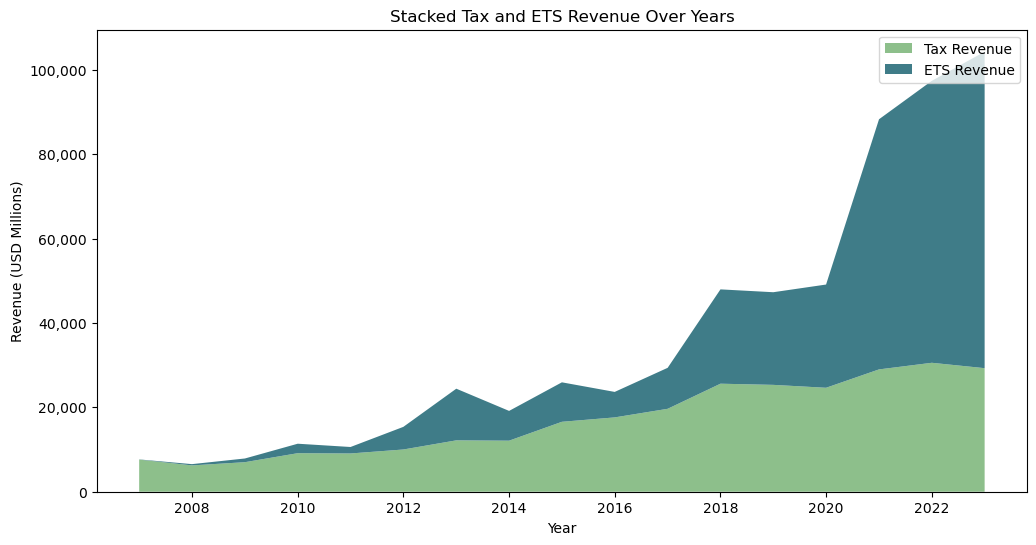

In [14]:
plt.figure(figsize=(12, 6))

colors = ['#8dbf8b', '#3F7C88']

tax_revenue_values = ts_tax_sum['tax_Revenue']
ets_revenue_values = ts_ets_sum['ets_Revenue']

years = ts_tax_sum.index

plt.stackplot(years, tax_revenue_values, ets_revenue_values, labels=['Tax Revenue', 'ETS Revenue'], colors=colors)

plt.title('Stacked Tax and ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')

plt.legend()

# format y-axis
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

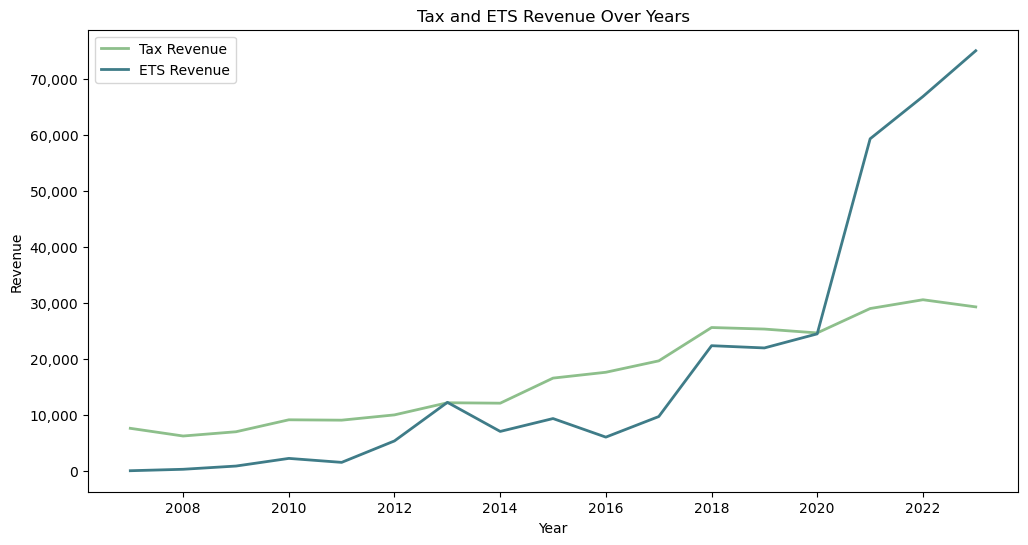

In [15]:
plt.figure(figsize=(12, 6))

colors = ['#8dbf8b', '#3F7C88']

sns.lineplot(data=ts_tax_sum, x=ts_tax_sum.index, y='tax_Revenue', label='Tax Revenue', linewidth=2, color=colors[0])
sns.lineplot(data=ts_ets_sum, x=ts_ets_sum.index, y='ets_Revenue', label='ETS Revenue', linewidth=2, color=colors[1])

plt.title('Tax and ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue')

plt.legend()

# format y-axis
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 依照「機制」分別看Tax、ETS排名

In [16]:
ts_tax

Name        Type  \
0                      Finland carbon tax  Carbon tax   
1                       Poland carbon tax  Carbon tax   
2                       Norway carbon tax  Carbon tax   
3                       Sweden carbon tax  Carbon tax   
4                      Denmark carbon tax  Carbon tax   
..                                    ...         ...   
760  Newfoundland and Labrador carbon tax  Carbon tax   
761              New Brunswick carbon tax  Carbon tax   
762            Baja California carbon tax  Carbon tax   
763                 Tamaulipas carbon tax  Carbon tax   
764                    Alberta carbon tax  Carbon tax   

                  Jurisdiction  Year  tax_Revenue  
0                      Finland  2007     706.4300  
1                       Poland  2007       1.6400  
2                       Norway  2007    1558.5400  
3                       Sweden  2007    4200.0800  
4                      Denmark  2007    1079.2600  
..                         ...   ...          ...  
760  Newfoundland and Labrador  2023      25.8627  
761              New Brunswick  2023     118.2295  
762            Baja California  2023          NaN  
763                 Tamaulipas  2023       0.0000  
764                    Alberta  2023          NaN  

[765 rows x 5 columns]

In [17]:
# Group by 'Name'並計算各年度revenues加總
tax_total_revenue = ts_tax.groupby('Name')['tax_Revenue'].sum()
tax_top_10 = tax_total_revenue.sort_values(ascending=False).head(10)

tax_top_10

Name
France carbon tax             67440.7580
Sweden carbon tax             52221.9410
Norway carbon tax             25200.3170
Japan carbon tax              21685.1460
Canada federal fuel charge    20864.6169
Finland carbon tax            20811.4780
BC carbon tax                 17616.6590
Switzerland carbon tax        14337.9130
UK Carbon Price Support       13753.2120
Denmark carbon tax            12457.3190
Name: tax_Revenue, dtype: float64

In [18]:
ts_tax_top = ts_tax[ts_tax['Name'].isin(['Sweden carbon tax','France carbon tax', 'Norway carbon tax', 'Finland carbon tax', 'Japan carbon tax',
                                         'Canada federal fuel charge', 'BC carbon tax', 'Denmark carbon tax', 'Switzerland carbon tax', 'UK Carbon Price Support'])]
ts_tax_top

Name        Type      Jurisdiction  Year  \
0            Finland carbon tax  Carbon tax           Finland  2007   
2             Norway carbon tax  Carbon tax            Norway  2007   
3             Sweden carbon tax  Carbon tax            Sweden  2007   
4            Denmark carbon tax  Carbon tax           Denmark  2007   
8        Switzerland carbon tax  Carbon tax       Switzerland  2007   
..                          ...         ...               ...   ...   
729               BC carbon tax  Carbon tax  British Columbia  2023   
732            Japan carbon tax  Carbon tax             Japan  2023   
733     UK Carbon Price Support  Carbon tax    United Kingdom  2023   
734           France carbon tax  Carbon tax            France  2023   
744  Canada federal fuel charge  Carbon tax            Canada  2023   

     tax_Revenue  
0       706.4300  
2      1558.5400  
3      4200.0800  
4      1079.2600  
8         0.0000  
..           ...  
729    1958.1760  
732    1673.1570  
733     994.4950  
734    8373.7500  
744    5719.3527  

[170 rows x 5 columns]

In [19]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_data = ts_tax_top.pivot_table(index='Year', columns='Name', values='tax_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_data.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_data = pivot_data[sorted_columns]
sorted_pivot_data

Name  France carbon tax  Canada federal fuel charge  Sweden carbon tax  \
Year                                                                     
2007              0.000                      0.0000           4200.080   
2008              0.000                      0.0000           3090.900   
2009              0.000                      0.0000           3611.360   
2010              0.000                      0.0000           4323.290   
2011              0.000                      0.0000           3841.110   
2012              0.000                      0.0000           3894.800   
2013              0.000                      0.0000           3725.270   
2014            322.650                      0.0000           2704.366   
2015           2858.000                      0.0000           3046.353   
2016           4344.160                      0.0000           2809.968   
2017           5813.773                      0.0000           2648.175   
2018          10220.908                      0.0000           2879.056   
2019           9213.515                   1461.5343           2492.295   
2020           8967.522                   3010.8319           2004.256   
2021           8926.960                   4777.3577           2435.323   
2022           8399.520                   5895.5403           2342.245   
2023           8373.750                   5719.3527           2173.094   

Name  BC carbon tax  Japan carbon tax  Norway carbon tax  Finland carbon tax  \
Year                                                                           
2007          0.000             0.000           1558.540             706.430   
2008        145.220             0.000           1206.160             644.520   
2009        524.960             0.000           1150.510             544.660   
2010        717.880             0.000           1272.460             689.620   
2011        912.070             0.000           1278.190             936.350   
2012       1062.010           416.440           1208.000            1283.220   
2013       1085.060           871.500           1392.510            1427.170   
2014        954.646          1417.260           1247.205            1137.057   
2015        932.015          1558.530           1500.436            1456.000   
2016        920.518          2337.790           1544.153            1349.691   
2017        932.385          2340.920           1498.542            1351.745   
2018       1091.885          2486.726           1812.840            1609.415   
2019       1220.663          2361.360           1650.773            1458.572   
2020       1118.731          2435.397           1454.774            1419.493   
2021       2283.327          1985.739           1759.786            1644.440   
2022       1757.113          1800.327           2157.497            1734.451   
2023       1958.176          1673.157           1507.941            1418.644   

Name  Switzerland carbon tax  UK Carbon Price Support  Denmark carbon tax  
Year                                                                       
2007                   0.000                    0.000            1079.260  
2008                 191.970                    0.000             912.860  
2009                 206.210                    0.000             913.080  
2010                 638.340                    0.000            1102.430  
2011                 551.680                    0.000            1068.290  
2012                 586.070                    0.000             989.510  
2013                 734.910                 1117.160            1098.510  
2014                 781.702                 1765.490             531.642  
2015                 881.034                 2600.052             567.737  
2016                1045.772                 1340.988             567.737  
2017                1060.944                 1092.861             513.139  
2018                1231.868                 1177.461             600.654  
2019    

<Figure size 1200x600 with 0 Axes>

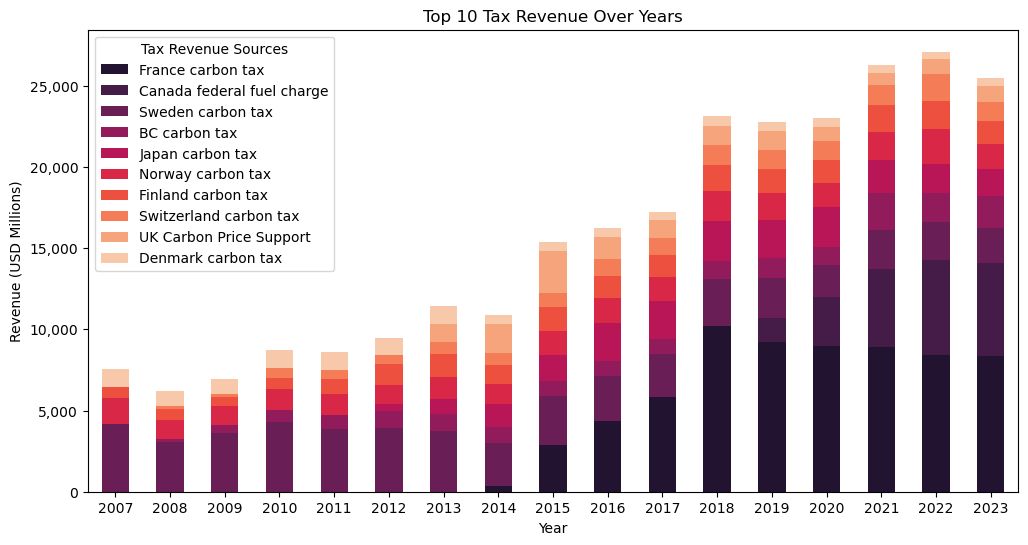

In [20]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_data.columns))

ax = sorted_pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Tax Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Tax Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

<Figure size 1200x600 with 0 Axes>

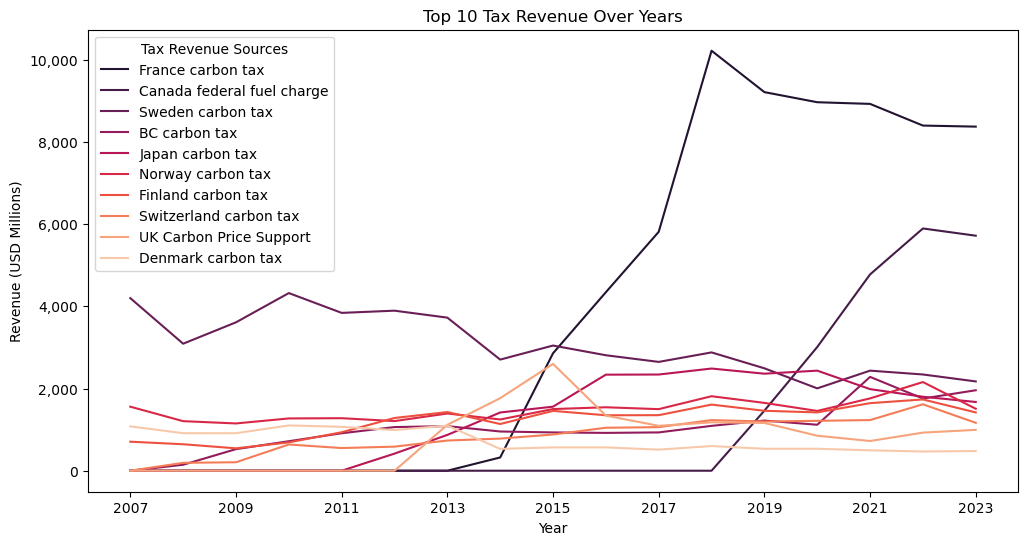

In [21]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_data.columns)) #如果要用這張折線圖上面那張就要改成'viridis'

ax = sorted_pivot_data.plot(kind='line', figsize=(12, 6), color=colors)

plt.title('Top 10 Tax Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Tax Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [22]:
ts_ets

Name Type    Jurisdiction  Year  ets_Revenue
0             EU ETS  ETS              EU  2007       0.0000
1       Alberta TIER  ETS         Alberta  2007      44.0100
2    Switzerland ETS  ETS     Switzerland  2007       0.0000
3    New Zealand ETS  ETS     New Zealand  2007       0.0000
4               RGGI  ETS            RGGI  2007       0.0000
..               ...  ...             ...   ...          ...
641   Montenegro ETS  ETS      Montenegro  2023          NaN
642           UK ETS  ETS  United Kingdom  2023    5201.2627
643      Austria ETS  ETS         Austria  2023     917.0888
644    Australia CPM  ETS       Australia  2023          NaN
645      Ontario CaT  ETS         Ontario  2023          NaN

[646 rows x 5 columns]

In [23]:
# Group by 'Name'並計算各年度revenues加總
ets_total_revenue = ts_ets.groupby('Name')['ets_Revenue'].sum()
ets_top_10 = ets_total_revenue.sort_values(ascending=False).head(10)

ets_top_10

Name
EU ETS             211530.0560
Germany ETS         27194.4865
California CaT      26976.4240
UK ETS              19199.5323
Australia CPM       12282.1940
RGGI                 7160.0660
Quebec CaT           6021.5610
New Zealand ETS      3507.5830
Alberta TIER         3291.5520
Ontario CaT          2205.6074
Name: ets_Revenue, dtype: float64

In [24]:
ts_ets_top = ts_ets[ts_ets['Name'].isin(['EU ETS', 'Germany ETS', 'California CaT', 'UK ETS', 'Australia CPM',
                                        'RGGI', 'Quebec CaT', 'New Zealand ETS', 'Alberta TIER', 'Ontario CaT'])]
ts_ets_top

Name Type    Jurisdiction  Year  ets_Revenue
0             EU ETS  ETS              EU  2007       0.0000
1       Alberta TIER  ETS         Alberta  2007      44.0100
3    New Zealand ETS  ETS     New Zealand  2007       0.0000
4               RGGI  ETS            RGGI  2007       0.0000
7     California CaT  ETS      California  2007       0.0000
..               ...  ...             ...   ...          ...
616       Quebec CaT  ETS          Quebec  2023    1048.8030
640      Germany ETS  ETS         Germany  2023   11679.8712
642           UK ETS  ETS  United Kingdom  2023    5201.2627
644    Australia CPM  ETS       Australia  2023          NaN
645      Ontario CaT  ETS         Ontario  2023          NaN

[170 rows x 5 columns]

In [25]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_data = ts_ets_top.pivot_table(index='Year', columns='Name', values='ets_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_data.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_data = pivot_data[sorted_columns]
sorted_pivot_data

Name     EU ETS  Germany ETS     UK ETS  California CaT      RGGI  Quebec CaT  \
Year                                                                            
2007      0.000       0.0000     0.0000           0.000     0.000       0.000   
2008     85.570       0.0000     0.0000           0.000   145.070       0.000   
2009    463.970       0.0000     0.0000           0.000   349.360       0.000   
2010   1879.390       0.0000     0.0000           0.000   283.080       0.000   
2011   1295.430       0.0000     0.0000           0.000   174.640       0.000   
2012   1632.320       0.0000     0.0000          55.760   167.650       0.000   
2013   4983.430       0.0000     0.0000         476.800   447.970       0.000   
2014   3407.877       0.0000     0.0000         437.110   367.287      30.800   
2015   5639.405       0.0000     0.0000        2558.160   435.977     651.100   
2016   4506.722       0.0000     0.0000         901.096   266.466     257.574   
2017   5906.509       0.0000     0.0000        2024.168   198.376     358.855   
2018  17597.546       0.0000     0.0000        3020.000   239.360     497.597   
2019  16450.445       0.0000     0.0000        3064.750   283.989     726.294   
2020  20992.751       0.0000     0.0000        1698.320   416.300     485.264   
2021  36481.590    8438.1302  5937.0546        3992.300   926.000     895.901   
2022  42837.663    7076.4851  8061.2150        4027.400  1193.600    1069.373   
2023  47369.438   11679.8712  5201.2627        4720.560  1264.941    1048.803   

Name  Alberta TIER  New Zealand ETS  Australia CPM  Ontario CaT  
Year                                                             
2007        44.010            0.000          0.000       0.0000  
2008        69.840            0.000          0.000       0.0000  
2009        65.810            0.000          0.000       0.0000  
2010        81.940            0.360          0.000       0.0000  
2011        63.430            1.420          0.000       0.0000  
2012        92.160            1.060       3415.035       0.0000  
2013        85.610            0.000       6226.790       0.0000  
2014        66.841            0.000       2640.369       0.0000  
2015        63.923            0.000          0.000       0.0000  
2016       103.932            0.001          0.000       0.0000  
2017       101.879            0.024          0.000    1120.3903  
2018       352.077            0.382          0.000     551.6043  
2019       391.862          286.944          0.000     533.6128  
2020       301.576          128.140          0.000       0.0000  
2021       292.280         1661.478          0.000       0.0000  
2022       475.943         1405.987          0.000       0.0000  
2023       638.439           21.787          0.000       0.0000

<Figure size 1200x600 with 0 Axes>

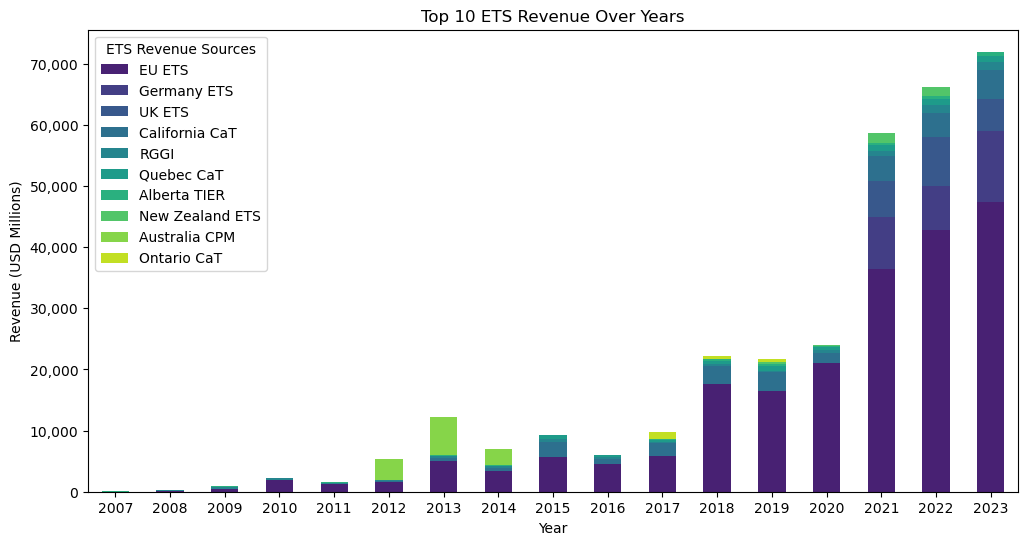

In [26]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_data.columns))

ax = sorted_pivot_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='ETS Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

<Figure size 1200x600 with 0 Axes>

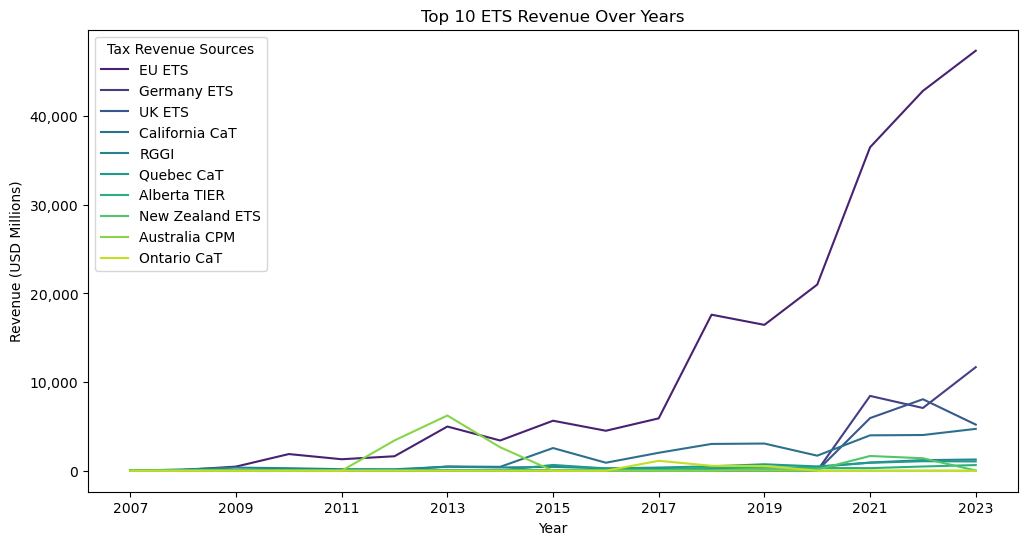

In [27]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_data.columns))

ax = sorted_pivot_data.plot(kind='line', figsize=(12, 6), color=colors)

plt.title('Top 10 ETS Revenue Over Years')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Tax Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 依照各國分別看Tax、ETS收益排名

In [28]:
ts_tax

Name        Type  \
0                      Finland carbon tax  Carbon tax   
1                       Poland carbon tax  Carbon tax   
2                       Norway carbon tax  Carbon tax   
3                       Sweden carbon tax  Carbon tax   
4                      Denmark carbon tax  Carbon tax   
..                                    ...         ...   
760  Newfoundland and Labrador carbon tax  Carbon tax   
761              New Brunswick carbon tax  Carbon tax   
762            Baja California carbon tax  Carbon tax   
763                 Tamaulipas carbon tax  Carbon tax   
764                    Alberta carbon tax  Carbon tax   

                  Jurisdiction  Year  tax_Revenue  
0                      Finland  2007     706.4300  
1                       Poland  2007       1.6400  
2                       Norway  2007    1558.5400  
3                       Sweden  2007    4200.0800  
4                      Denmark  2007    1079.2600  
..                         ...   ...          ...  
760  Newfoundland and Labrador  2023      25.8627  
761              New Brunswick  2023     118.2295  
762            Baja California  2023          NaN  
763                 Tamaulipas  2023       0.0000  
764                    Alberta  2023          NaN  

[765 rows x 5 columns]

In [29]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = ts_tax


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Moldova', 'Philippines', 'Taiwan', 'El Salvador', 'India', 'Belarus', 'South Sudan', 'Rwanda', 'Guyana', 'Northern Cyprus', 'Qatar', 'Puerto Rico', 'Brazil', 'Cuba', 'Malawi', 'Myanmar', 'Peru', 'Guatemala', 'Israel', 'Laos', 'Madagascar', 'Uzbekistan', 'West Bank', 'Togo', 'East Timor', 'Bhutan', 'Tajikistan', 'Dominican Republic', 'Oman', 'Suriname', 'Turkmenistan', 'Cyprus', 'Ecuador', 'Australia', 'Fiji', 'Bangladesh', 'Saudi Arabia', 'Turkey', 'Germany', 'Cambodia', 'Gabon', 'New Zealand', 'Iran', 'Guinea', 'Botswana', 'Ethiopia', 'Sudan', 'Romania', 'Greenland', 'Afghanistan', 'Solomon Islands', 'Russia', 'China', 'Jamaica', 'Syria', 'Burundi', 'Azerbaijan', 'Mozambique', 'Bulgaria', 'Morocco', 'North Korea', 'Slovakia', 'Benin', 'Kazakhstan', 'South Korea', 'Pakistan', 'Uganda', 'Macedonia', 'United States of America', 'Kosovo', 'Georgia', 'Bosnia and Herzegovina', 'Indonesia', 'Republic of the Congo', 'Antarctica', 'Paragu

In [30]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {
    'Tamaulipas': 'Mexico',
    'Taiwan, China': 'Taiwan',
    'Prince Edward Island': 'Canada',
    'New York State': 'United States of America',
    'New Brunswick': 'Canada',
    'Shenzhen': 'China',
    'Ontario': 'Canada',
    'Manitoba': 'Canada',
    'Korea, Rep.': 'South Korea',
    'Quebec': 'Canada',
    'Northwest Territories': 'Canada',
    'Alberta': 'Canada',
    'EU': None,
    'State of Mexico': 'Mexico',
    'Washington': 'United States of America',
    'Zacatecas': 'Mexico',
    'Yucatan': 'Mexico',
    'Catalonia': 'Spain',
    'British Columbia': 'Canada',
    'Baja California': 'United States of America',
    'Queretaro': 'Mexico',
    'Durango': 'Mexico',
    'Guanajuato': 'Mexico',
    'Newfoundland and Labrador': 'Canada',
    'Colima': 'Mexico'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)


Countries present in Jurisdiction but not in GeoJSON after mapping:
{'Singapore', 'Liechtenstein'}


In [31]:
# 利用country_name_mapping重新命名
ts_tax['Jurisdiction'] = ts_tax['Jurisdiction'].replace(country_name_mapping)
ts_tax

Name        Type  \
0                      Finland carbon tax  Carbon tax   
1                       Poland carbon tax  Carbon tax   
2                       Norway carbon tax  Carbon tax   
3                       Sweden carbon tax  Carbon tax   
4                      Denmark carbon tax  Carbon tax   
..                                    ...         ...   
760  Newfoundland and Labrador carbon tax  Carbon tax   
761              New Brunswick carbon tax  Carbon tax   
762            Baja California carbon tax  Carbon tax   
763                 Tamaulipas carbon tax  Carbon tax   
764                    Alberta carbon tax  Carbon tax   

                 Jurisdiction  Year  tax_Revenue  
0                     Finland  2007     706.4300  
1                      Poland  2007       1.6400  
2                      Norway  2007    1558.5400  
3                      Sweden  2007    4200.0800  
4                     Denmark  2007    1079.2600  
..                        ...   ...          ...  
760                    Canada  2023      25.8627  
761                    Canada  2023     118.2295  
762  United States of America  2023          NaN  
763                    Mexico  2023       0.0000  
764                    Canada  2023          NaN  

[765 rows x 5 columns]

In [32]:
# Group by 'Name'並計算各年度revenues加總
tax_total_revenue = ts_tax.groupby('Jurisdiction')['tax_Revenue'].sum()
tax_top_10 = tax_total_revenue.sort_values(ascending=False).head(10)

tax_top_10

Jurisdiction
France            67440.7580
Sweden            52221.9410
Canada            42139.3151
Norway            25200.3170
Japan             21685.1460
Finland           20811.4780
Switzerland       14337.9130
United Kingdom    13753.2120
Denmark           12457.3190
Ireland            7546.0385
Name: tax_Revenue, dtype: float64

In [33]:
ts_tax_top = ts_tax[ts_tax['Jurisdiction'].isin(['Sweden', 'France', 'Canada', 'Norway', 'Finland', 
                                                 'Japan', 'Denmark', 'Switzerland', 'United Kingdom', 'Ireland'])]
ts_tax_top

Name        Type Jurisdiction  Year  \
0                      Finland carbon tax  Carbon tax      Finland  2007   
2                       Norway carbon tax  Carbon tax       Norway  2007   
3                       Sweden carbon tax  Carbon tax       Sweden  2007   
4                      Denmark carbon tax  Carbon tax      Denmark  2007   
8                  Switzerland carbon tax  Carbon tax  Switzerland  2007   
..                                    ...         ...          ...   ...   
744            Canada federal fuel charge  Carbon tax       Canada  2023   
759       Prince Edward Island Carbon tax  Carbon tax       Canada  2023   
760  Newfoundland and Labrador carbon tax  Carbon tax       Canada  2023   
761              New Brunswick carbon tax  Carbon tax       Canada  2023   
764                    Alberta carbon tax  Carbon tax       Canada  2023   

     tax_Revenue  
0       706.4300  
2      1558.5400  
3      4200.0800  
4      1079.2600  
8         0.0000  
..           ...  
744    5719.3527  
759      10.3451  
760      25.8627  
761     118.2295  
764          NaN  

[272 rows x 5 columns]

In [34]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_tax = ts_tax_top.pivot_table(index='Year', columns='Jurisdiction', values='tax_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_tax.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_tax = pivot_tax[sorted_columns]
sorted_pivot_tax

Jurisdiction     France     Canada    Sweden     Japan    Norway   Finland  \
Year                                                                         
2007              0.000     0.0000  4200.080     0.000  1558.540   706.430   
2008              0.000   145.2200  3090.900     0.000  1206.160   644.520   
2009              0.000   524.9600  3611.360     0.000  1150.510   544.660   
2010              0.000   717.8800  4323.290     0.000  1272.460   689.620   
2011              0.000   912.0700  3841.110     0.000  1278.190   936.350   
2012              0.000  1062.0100  3894.800   416.440  1208.000  1283.220   
2013              0.000  1085.0600  3725.270   871.500  1392.510  1427.170   
2014            322.650   954.6460  2704.366  1417.260  1247.205  1137.057   
2015           2858.000   932.0150  3046.353  1558.530  1500.436  1456.000   
2016           4344.160   920.5180  2809.968  2337.790  1544.153  1349.691   
2017           5813.773  1625.1001  2648.175  2340.920  1498.542  1351.745   
2018          10220.908  2139.0093  2879.056  2486.726  1812.840  1609.415   
2019           9213.515  3750.8819  2492.295  2361.360  1650.773  1458.572   
2020           8967.522  4280.5159  2004.256  2435.397  1454.774  1419.493   
2021           8926.960  7287.4973  2435.323  1985.739  1759.786  1644.440   
2022           8399.520  7927.1074  2342.245  1800.327  2157.497  1734.451   
2023           8373.750  7874.8242  2173.094  1673.157  1507.941  1418.644   

Jurisdiction  Switzerland    Ireland  United Kingdom   Denmark  
Year                                                            
2007                0.000     0.0000           0.000  1079.260  
2008              191.970     0.0000           0.000   912.860  
2009              206.210     0.0000           0.000   913.080  
2010              638.340   313.9300           0.000  1102.430  
2011              551.680   398.2400           0.000  1068.290  
2012              586.070   455.8200           0.000   989.510  
2013              734.910   535.0500        1117.160  1098.510  
2014              781.702   414.0675        1765.490   531.642  
2015              881.034   474.4280        2600.052   567.737  
2016             1045.772   497.2920        1340.988   567.737  
2017             1060.944   475.7500        1092.861   513.139  
2018             1231.868   539.3130        1177.461   600.654  
2019             1197.750   494.3840        1162.413   534.249  
2020             1214.005   481.1840         851.744   534.777  
2021             1232.493   575.5540         723.188   496.418  
2022             1616.762   874.2130         927.360   467.831  
2023             1166.403  1016.8130         994.495   479.195

<Figure size 1200x600 with 0 Axes>

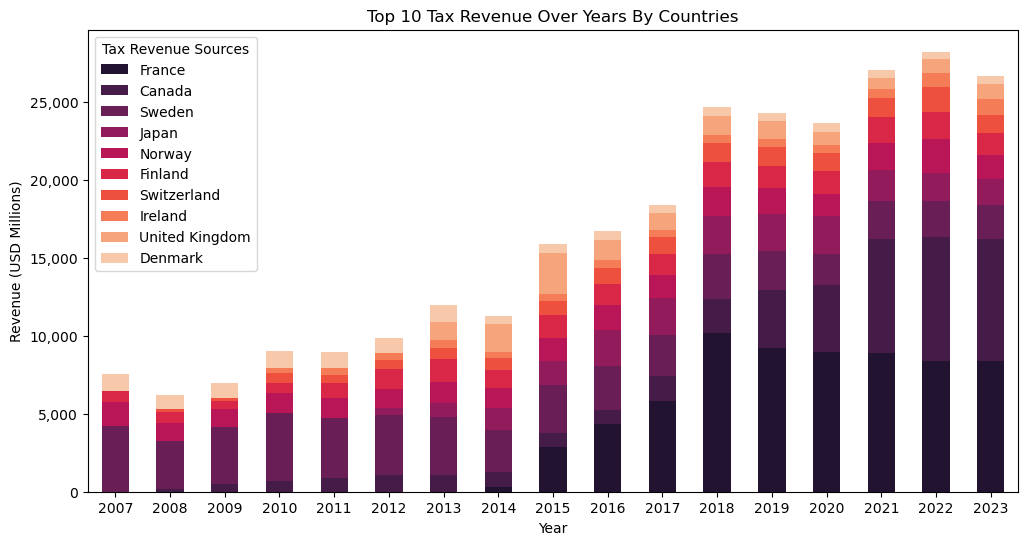

In [35]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_tax.columns))

ax = sorted_pivot_tax.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Tax Revenue Over Years By Countries')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Tax Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [36]:
ts_ets

Name Type    Jurisdiction  Year  ets_Revenue
0             EU ETS  ETS              EU  2007       0.0000
1       Alberta TIER  ETS         Alberta  2007      44.0100
2    Switzerland ETS  ETS     Switzerland  2007       0.0000
3    New Zealand ETS  ETS     New Zealand  2007       0.0000
4               RGGI  ETS            RGGI  2007       0.0000
..               ...  ...             ...   ...          ...
641   Montenegro ETS  ETS      Montenegro  2023          NaN
642           UK ETS  ETS  United Kingdom  2023    5201.2627
643      Austria ETS  ETS         Austria  2023     917.0888
644    Australia CPM  ETS       Australia  2023          NaN
645      Ontario CaT  ETS         Ontario  2023          NaN

[646 rows x 5 columns]

In [37]:
ts_ets['Jurisdiction'].value_counts()

Jurisdiction
Australia                      34
Ontario                        34
Massachusetts                  17
Washington                     17
Fujian                         17
Canada                         17
China                          17
Mexico                         17
Newfoundland and Labrador      17
EU                             17
Alberta                        17
Saskatchewan                   17
New Brunswick                  17
Indonesia                      17
Germany                        17
Montenegro                     17
United Kingdom                 17
Nova Scotia                    17
British Columbia               17
Korea, Rep.                    17
Quebec                         17
Switzerland                    17
New Zealand                    17
RGGI                           17
Tokyo                          17
Saitama                        17
California                     17
Kazakhstan                     17
Chongqing                      17
S

In [38]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = ts_ets


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Moldova', 'Philippines', 'Taiwan', 'South Africa', 'Belarus', 'India', 'El Salvador', 'Ukraine', 'South Sudan', 'Rwanda', 'Guyana', 'Northern Cyprus', 'Qatar', 'Ireland', 'Puerto Rico', 'Brazil', 'Cuba', 'Malawi', 'Myanmar', 'Peru', 'Guatemala', 'Israel', 'Laos', 'Madagascar', 'Uzbekistan', 'West Bank', 'Togo', 'East Timor', 'Bhutan', 'Tajikistan', 'Dominican Republic', 'Oman', 'Suriname', 'Turkmenistan', 'Cyprus', 'Ecuador', 'Fiji', 'Bangladesh', 'Saudi Arabia', 'Turkey', 'Cambodia', 'Gabon', 'Iran', 'Guinea', 'Botswana', 'Ethiopia', 'Sudan', 'Romania', 'Latvia', 'Greenland', 'Afghanistan', 'Solomon Islands', 'Slovenia', 'Russia', 'Jamaica', 'Syria', 'Burundi', 'Azerbaijan', 'Mozambique', 'Bulgaria', 'Morocco', 'Luxembourg', 'North Korea', 'Slovakia', 'Benin', 'South Korea', 'Pakistan', 'Uganda', 'Macedonia', 'United States of America', 'Kosovo', 'Georgia', 'Chile', 'Sweden', 'France', 'Albania', 'Bosnia and Herzegovina', 'Republ

In [39]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {    
    'Ontario': 'Canada',
    'Shanghai': 'China',
    'Tianjin': 'China',
    'Korea, Rep.': 'South Korea',
    'Newfoundland and Labrador': 'Canada',
    'Massachusetts': 'United States of America',
    'Washington': 'United States of America',
    'Hubei': 'China',
    'Quebec': 'Canada',
    'New Brunswick': 'Canada',
    'Fujian': 'China',
    'British Columbia': 'Canada',
    'EU': None,
    'California': 'United States of America',
    'Nova Scotia': 'Canada',
    'Guangdong (except Shenzhen)': 'China',
    'Chongqing': 'China', 
    'Saitama': 'Japan',
    'Saskatchewan': 'Canada',
    'Alberta': 'Canada',
     'Beijing': 'China',
    'RGGI': 'United States of America',
    'Shenzhen': 'China',
    'Tokyo': 'Japan'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)


Countries present in Jurisdiction but not in GeoJSON after mapping:
{None}


In [40]:
# 利用country_name_mapping重新命名
ts_ets['Jurisdiction'] = ts_ets['Jurisdiction'].replace(country_name_mapping)
ts_ets

Name Type              Jurisdiction  Year  ets_Revenue
0             EU ETS  ETS                      None  2007       0.0000
1       Alberta TIER  ETS                    Canada  2007      44.0100
2    Switzerland ETS  ETS               Switzerland  2007       0.0000
3    New Zealand ETS  ETS               New Zealand  2007       0.0000
4               RGGI  ETS  United States of America  2007       0.0000
..               ...  ...                       ...   ...          ...
641   Montenegro ETS  ETS                Montenegro  2023          NaN
642           UK ETS  ETS            United Kingdom  2023    5201.2627
643      Austria ETS  ETS                   Austria  2023     917.0888
644    Australia CPM  ETS                 Australia  2023          NaN
645      Ontario CaT  ETS                    Canada  2023          NaN

[646 rows x 5 columns]

In [41]:
# Group by 'Name'並計算各年度revenues加總
ets_total_revenue = ts_ets.groupby('Jurisdiction')['ets_Revenue'].sum()
ets_top_10 = ets_total_revenue.sort_values(ascending=False).head(10)

ets_top_10

Jurisdiction
United States of America    36127.4452
Germany                     27194.4865
United Kingdom              19199.5323
Canada                      12294.9925
Australia                   12282.1940
New Zealand                  3507.5830
South Korea                  1080.5980
Austria                       917.0888
China                         526.3574
Switzerland                   146.5800
Name: ets_Revenue, dtype: float64

In [42]:
ts_ets_top = ts_ets[ts_ets['Jurisdiction'].isin(['United States of America',  'Germany', 'United Kingdom', 'Canada', 'Australia',
                                                 'New Zealand', 'South Korea', 'Austria', 'China', 'Switzerland'])]
    
ts_ets_top

Name Type              Jurisdiction  Year  ets_Revenue
1       Alberta TIER  ETS                    Canada  2007      44.0100
2    Switzerland ETS  ETS               Switzerland  2007       0.0000
3    New Zealand ETS  ETS               New Zealand  2007       0.0000
4               RGGI  ETS  United States of America  2007       0.0000
7     California CaT  ETS  United States of America  2007       0.0000
..               ...  ...                       ...   ...          ...
640      Germany ETS  ETS                   Germany  2023   11679.8712
642           UK ETS  ETS            United Kingdom  2023    5201.2627
643      Austria ETS  ETS                   Austria  2023     917.0888
644    Australia CPM  ETS                 Australia  2023          NaN
645      Ontario CaT  ETS                    Canada  2023          NaN

[527 rows x 5 columns]

In [43]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_ets = ts_ets_top.pivot_table(index='Year', columns='Jurisdiction', values='ets_Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_ets.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ets = pivot_ets[sorted_columns]
sorted_pivot_ets

Jurisdiction     Germany  United States of America  United Kingdom     Canada  \
Year                                                                            
2007              0.0000                    0.0000          0.0000    44.0100   
2008              0.0000                  145.0700          0.0000    69.8400   
2009              0.0000                  349.3600          0.0000    65.8100   
2010              0.0000                  283.0800          0.0000    81.9400   
2011              0.0000                  174.6400          0.0000    63.4300   
2012              0.0000                  223.4100          0.0000    92.1600   
2013              0.0000                  924.7700          0.0000    85.6100   
2014              0.0000                  804.3970          0.0000    97.6410   
2015              0.0000                 2994.1370          0.0000   715.0230   
2016              0.0000                 1167.5620          0.0000   361.5060   
2017              0.0000                 2222.5440          0.0000  1581.1243   
2018              0.0000                 3262.2893          0.0000  1401.2783   
2019              0.0000                 3356.9376          0.0000  1651.7688   
2020              0.0000                 2130.4000          0.0000   986.9160   
2021           8438.1302                 4962.6000       5937.0546  1486.4699   
2022           7076.4851                 5274.8000       8061.2150  1679.9210   
2023          11679.8712                 7851.4483       5201.2627  1830.5442   

Jurisdiction   Austria  South Korea     China  Switzerland  New Zealand  \
Year                                                                      
2007            0.0000        0.000    0.0000        0.000        0.000   
2008            0.0000        0.000    0.0000        0.000        0.000   
2009            0.0000        0.000    0.0000        0.000        0.000   
2010            0.0000        0.000    0.0000        0.000        0.360   
2011            0.0000        0.000    0.0000        0.000        1.420   
2012            0.0000        0.000    0.0000        0.000        1.060   
2013            0.0000        0.000   29.2700        0.000        0.000   
2014            0.0000        0.000   99.9500        8.585        0.000   
2015            0.0000        0.000    5.6800        4.967        0.000   
2016            0.0000        0.000    2.2026        4.182        0.001   
2017            0.0000        0.000    2.5210        4.697        0.024   
2018            0.0000       97.790    2.0190        4.639        0.382   
2019            0.0000      192.517   18.8110        8.600      286.944   
2020            0.0000      203.525   28.7820        7.562      128.140   
2021            0.0000      260.286   66.9412       17.124     1661.478   
2022            0.0000      261.915  211.9486       47.069     1405.987   
2023          917.0888       64.565   58.2320       39.155       21.787   

Jurisdiction  Australia  
Year                     
2007              0.000  
2008              0.000  
2009              0.000  
2010              0.000  
2011              0.000  
2012           3415.035  
2013           6226.790  
2014           2640.369  
2015              0.000  
2016              0.000  
2017              0.000  
2018              0.000  
2019              0.000  
2020              0.000  
2021              0.000  
2022              0.000  
2023              0.000

<Figure size 1200x600 with 0 Axes>

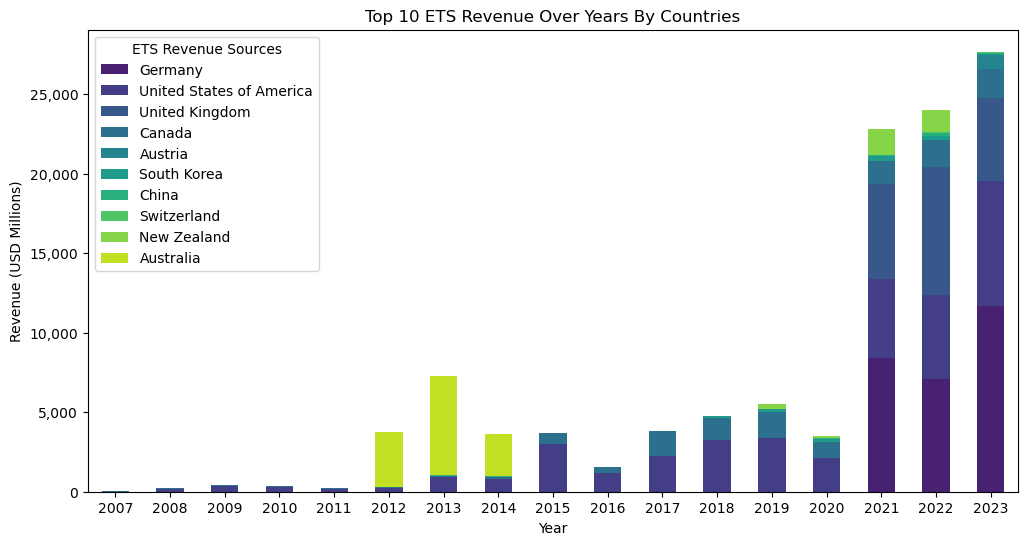

In [44]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_ets.columns))

ax = sorted_pivot_ets.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 ETS Revenue Over Years By Countries')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='ETS Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 將Tax & ETS依照國家看總和排名

In [45]:
df

Name        Type     Jurisdiction     2007     2008  \
0           Finland carbon tax  Carbon tax          Finland   706.43   644.52   
1            Poland carbon tax  Carbon tax           Poland     1.64     1.12   
2            Norway carbon tax  Carbon tax           Norway  1558.54  1206.16   
3            Sweden carbon tax  Carbon tax           Sweden  4200.08  3090.90   
4           Denmark carbon tax  Carbon tax          Denmark  1079.26   912.86   
..                         ...         ...              ...      ...      ...   
78  Baja California carbon tax  Carbon tax  Baja California                     
79       Tamaulipas carbon tax  Carbon tax       Tamaulipas        0        0   
80               Australia CPM         ETS        Australia        0        0   
81          Alberta carbon tax  Carbon tax          Alberta        0        0   
82                 Ontario CaT         ETS          Ontario        0        0   

       2009     2010     2011      2012      2013      2014      2015  \
0    544.66   689.62   936.35   1283.22   1427.17  1137.057      1456   
1      1.35     1.43     1.41      1.39      1.52     1.223     1.211   
2   1150.51  1272.46  1278.19      1208   1392.51  1247.205  1500.436   
3   3611.36  4323.29  3841.11   3894.80   3725.27  2704.366  3046.353   
4    913.08  1102.43  1068.29    989.51   1098.51   531.642   567.737   
..      ...      ...      ...       ...       ...       ...       ...   
78                                                                      
79        0        0        0         0         0         0         0   
80        0        0        0  3415.035  6226.790  2640.369         0   
81        0        0        0         0         0         0         0   
82        0        0        0         0         0         0         0   

             2016           2017           2018           2019           2020  \
0        1349.691       1351.745       1609.415       1458.572       1419.493   
1           1.211          1.142          1.327          1.218          5.936   
2        1544.153       1498.542       1812.840       1650.773       1454.774   
3        2809.968       2648.175       2879.056       2492.295       2004.256   
4         567.737        513.139        600.654        534.249        534.777   
..            ...            ...            ...            ...            ...   
78         0.0000         0.0000         0.0000         0.0000         0.0000   
79         0.0000         0.0000         0.0000         0.0000         0.0000   
80  Not available  Not available  Not available  Not available  Not available   
81  Not available       692.7151      1047.1243      1012.9706  Not available   
82  Not available      1120.3903       551.6043       533.6128  Not available   

             2021           2022           2023  
0        1644.440       1734.451       1418.644  
1           1.220          6.623          1.258  
2        1759.786       2157.497       1507.941  
3        2435.323       2342.245       2173.094  
4         496.418        467.831        479.195  
..            ...            ...            ...  
78         1.1787         1.2142  Not available  
79         0.0000         1.8964         0.0000  
80  Not available  Not available  Not available  
81  Not available  Not available  Not available  
82  Not available  Not available  Not available  

[83 rows x 20 columns]

In [46]:
ts = df.melt(id_vars=['Name', 'Type', 'Jurisdiction'], var_name='Year', value_name='Revenue')
ts

Name        Type     Jurisdiction  Year  \
0             Finland carbon tax  Carbon tax          Finland  2007   
1              Poland carbon tax  Carbon tax           Poland  2007   
2              Norway carbon tax  Carbon tax           Norway  2007   
3              Sweden carbon tax  Carbon tax           Sweden  2007   
4             Denmark carbon tax  Carbon tax          Denmark  2007   
...                          ...         ...              ...   ...   
1406  Baja California carbon tax  Carbon tax  Baja California  2023   
1407       Tamaulipas carbon tax  Carbon tax       Tamaulipas  2023   
1408               Australia CPM         ETS        Australia  2023   
1409          Alberta carbon tax  Carbon tax          Alberta  2023   
1410                 Ontario CaT         ETS          Ontario  2023   

            Revenue  
0            706.43  
1              1.64  
2           1558.54  
3           4200.08  
4           1079.26  
...             ...  
1406  Not available  
1407         0.0000  
1408  Not available  
1409  Not available  
1410  Not available  

[1411 rows x 5 columns]

In [47]:
# Load GeoJSON data
world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
world_geojson = json.load(urllib.request.urlopen(world_geojson_url))

data = ts


geojson_country_names = set([feature['properties']['name'] for feature in world_geojson['features']])

# Extract country names from Jurisdiction column
jurisdiction_country_names = set(data['Jurisdiction'])

# Find the differences
missing_countries_in_jurisdiction = geojson_country_names - jurisdiction_country_names
missing_countries_in_geojson = jurisdiction_country_names - geojson_country_names

print("Countries present in GeoJSON but not in Jurisdiction:")
print(missing_countries_in_jurisdiction)

print("\nCountries present in Jurisdiction but not in GeoJSON:")
print(missing_countries_in_geojson)

Countries present in GeoJSON but not in Jurisdiction:
{'Moldova', 'Philippines', 'Taiwan', 'El Salvador', 'India', 'Belarus', 'South Sudan', 'Rwanda', 'Guyana', 'Northern Cyprus', 'Qatar', 'Puerto Rico', 'Brazil', 'Cuba', 'Malawi', 'Myanmar', 'Peru', 'Guatemala', 'Israel', 'Laos', 'Madagascar', 'Uzbekistan', 'West Bank', 'Togo', 'East Timor', 'Bhutan', 'Tajikistan', 'Dominican Republic', 'Oman', 'Suriname', 'Turkmenistan', 'Cyprus', 'Ecuador', 'Fiji', 'Saudi Arabia', 'Bangladesh', 'Turkey', 'Cambodia', 'Gabon', 'Iran', 'Guinea', 'Botswana', 'Ethiopia', 'Sudan', 'Romania', 'Greenland', 'Afghanistan', 'Solomon Islands', 'Russia', 'Jamaica', 'Syria', 'Burundi', 'Azerbaijan', 'Mozambique', 'Bulgaria', 'Morocco', 'North Korea', 'Slovakia', 'Benin', 'Uganda', 'South Korea', 'Pakistan', 'Macedonia', 'United States of America', 'Kosovo', 'Georgia', 'Bosnia and Herzegovina', 'Republic of the Congo', 'Antarctica', 'Paraguay', 'Czech Republic', 'Nepal', 'Mongolia', 'Lebanon', 'United Arab Emirate

In [48]:
# Define a dictionary to map the discrepancies between the datasets
country_name_mapping = {
    'New York State': 'United States of America',
    'Tianjin': 'China',
    'New Brunswick': 'Canada',
    'Shenzhen': 'China',
    'Maryland': 'United States of America',
    'Ontario': 'Canada',
    'Manitoba': 'Canada',
    'Korea, Rep.': 'South Korea',
    'Quebec': 'Canada',
    'Northwest Territories': 'Canada',
    'San Luis Potosí': 'Mexico',
    'Jalisco': 'Mexico',
    'Sakhalin': 'Russia',
    'Guangdong (except Shenzhen)': 'China',
    'Chongqing': 'China',
    'Massachusetts': 'United States of America',
    'Saitama': 'Japan',
    'Alberta': 'Canada',
    'EU': None,
    'Hawaii': 'United States of America',
    'Colorado': 'United States of America',
    'Türkiye': 'Turkey',
    'Saskatchewan': 'Canada',
    'Oregon': 'United States of America',
    'Pennsylvania': 'United States of America',
    'State of Mexico': 'Mexico',
    'Washington': 'United States of America',
    'Zacatecas': 'Mexico',
    'Yucatan': 'Mexico',
    'Catalonia': 'Spain',
    'Nova Scotia': 'Canada',
    'RGGI': 'United States of America',
    'British Columbia': 'Canada',
    'EU27+': None,
    'Shanghai': 'China',
    'Hubei': 'China',
    'Beijing': 'China',
    'Fujian':'China',
    'California': 'United States of America',
    'Queretaro': 'Mexico',
    'Durango': 'Mexico',
    'Côte d’Ivoire': 'Ivory Coast',  # 更新為正式名稱
    'Brunei Darussalam': 'Brunei',
    'Guanajuato': 'Mexico',
    'Newfoundland and Labrador': 'Canada',
    'Viet Nam': 'Vietnam',  # 更新為正式名稱
    'Tokyo': 'Japan',
    'Colima': 'Mexico',
    'Tamaulipas': 'Mexico',
    'Taiwan, China': 'Taiwan',
    'Prince Edward Island': 'Canada',
    'New York State': 'United States of America',
    'New Brunswick': 'Canada',
    'Singapore': None,
    'Liechtenstein': None,
    'Baja California': 'United States of America'
}

# Update country names in the Jurisdiction column based on the mapping
data['Jurisdiction'] = data['Jurisdiction'].replace(country_name_mapping)

# Check if all country names in the Jurisdiction column match those in the GeoJSON data
missing_countries_in_jurisdiction = set(data['Jurisdiction']) - geojson_country_names
print("Countries present in Jurisdiction but not in GeoJSON after mapping:")
print(missing_countries_in_jurisdiction)



Countries present in Jurisdiction but not in GeoJSON after mapping:
{None}


In [49]:
# 利用country_name_mapping重新命名
ts['Jurisdiction'] = ts['Jurisdiction'].replace(country_name_mapping)
ts

Name        Type              Jurisdiction  Year  \
0             Finland carbon tax  Carbon tax                   Finland  2007   
1              Poland carbon tax  Carbon tax                    Poland  2007   
2              Norway carbon tax  Carbon tax                    Norway  2007   
3              Sweden carbon tax  Carbon tax                    Sweden  2007   
4             Denmark carbon tax  Carbon tax                   Denmark  2007   
...                          ...         ...                       ...   ...   
1406  Baja California carbon tax  Carbon tax  United States of America  2023   
1407       Tamaulipas carbon tax  Carbon tax                    Mexico  2023   
1408               Australia CPM         ETS                 Australia  2023   
1409          Alberta carbon tax  Carbon tax                    Canada  2023   
1410                 Ontario CaT         ETS                    Canada  2023   

            Revenue  
0            706.43  
1              1.64  
2           1558.54  
3           4200.08  
4           1079.26  
...             ...  
1406  Not available  
1407         0.0000  
1408  Not available  
1409  Not available  
1410  Not available  

[1411 rows x 5 columns]

In [50]:
# Group by 'Name'並計算各年度revenues加總
ts['Revenue'] = pd.to_numeric(ts['Revenue'], errors='coerce')
ts_sum = ts.groupby('Year')['Revenue'].sum().reset_index()

ts_sum['Year'] = pd.to_datetime(ts_sum['Year'], format='%Y')

ts_total_revenue = ts.groupby('Jurisdiction')['Revenue'].sum()
ts_top_10 = ts_total_revenue.sort_values(ascending=False).head(10)

ts_top_10

Jurisdiction
France                      67440.7580
Canada                      54434.3076
Sweden                      52221.9410
United States of America    36129.8381
United Kingdom              32952.7443
Germany                     27194.4865
Norway                      25200.3170
Japan                       21685.1460
Finland                     20811.4780
Switzerland                 14484.4930
Name: Revenue, dtype: float64

In [51]:
ts_top = ts[ts['Jurisdiction'].isin(['Sweden', 'France', 'Canada', 'United States of America',  'United Kingdom',
                                     'Norway', 'Germany', 'Finland', 'Japan', 'Denmark'])]
    
ts_top

Name        Type  \
0                       Finland carbon tax  Carbon tax   
2                        Norway carbon tax  Carbon tax   
3                        Sweden carbon tax  Carbon tax   
4                       Denmark carbon tax  Carbon tax   
9                             Alberta TIER         ETS   
...                                    ...         ...   
1404  Newfoundland and Labrador carbon tax  Carbon tax   
1405              New Brunswick carbon tax  Carbon tax   
1406            Baja California carbon tax  Carbon tax   
1409                    Alberta carbon tax  Carbon tax   
1410                           Ontario CaT         ETS   

                  Jurisdiction  Year    Revenue  
0                      Finland  2007   706.4300  
2                       Norway  2007  1558.5400  
3                       Sweden  2007  4200.0800  
4                      Denmark  2007  1079.2600  
9                       Canada  2007    44.0100  
...                        ...   ...        ...  
1404                    Canada  2023    25.8627  
1405                    Canada  2023   118.2295  
1406  United States of America  2023        NaN  
1409                    Canada  2023        NaN  
1410                    Canada  2023        NaN  

[561 rows x 5 columns]

In [52]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Jurisdiction', values='Revenue', aggfunc='sum').fillna(0)

# 取2023年的排序
data_2023 = pivot_ts.loc['2023']

# 獲取2023年數據排序列名
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Jurisdiction     Germany     Canada     France  United States of America  \
Year                                                                       
2007              0.0000    44.0100      0.000                    0.0000   
2008              0.0000   215.0600      0.000                  145.0700   
2009              0.0000   590.7700      0.000                  349.3600   
2010              0.0000   799.8200      0.000                  283.0800   
2011              0.0000   975.5000      0.000                  174.6400   
2012              0.0000  1154.1700      0.000                  223.4100   
2013              0.0000  1170.6700      0.000                  924.7700   
2014              0.0000  1052.2870    322.650                  804.3970   
2015              0.0000  1647.0380   2858.000                 2994.1370   
2016              0.0000  1282.0240   4344.160                 1167.5620   
2017              0.0000  3206.2244   5813.773                 2222.5440   
2018              0.0000  3540.2876  10220.908                 3262.2893   
2019              0.0000  5402.6507   9213.515                 3356.9376   
2020              0.0000  5267.4319   8967.522                 2130.4000   
2021           8438.1302  8773.9672   8926.960                 4963.7787   
2022           7076.4851  9607.0284   8399.520                 5276.0142   
2023          11679.8712  9705.3684   8373.750                 7851.4483   

Jurisdiction  United Kingdom    Sweden     Japan    Norway   Finland   Denmark  
Year                                                                            
2007                  0.0000  4200.080     0.000  1558.540   706.430  1079.260  
2008                  0.0000  3090.900     0.000  1206.160   644.520   912.860  
2009                  0.0000  3611.360     0.000  1150.510   544.660   913.080  
2010                  0.0000  4323.290     0.000  1272.460   689.620  1102.430  
2011                  0.0000  3841.110     0.000  1278.190   936.350  1068.290  
2012                  0.0000  3894.800   416.440  1208.000  1283.220   989.510  
2013               1117.1600  3725.270   871.500  1392.510  1427.170  1098.510  
2014               1765.4900  2704.366  1417.260  1247.205  1137.057   531.642  
2015               2600.0520  3046.353  1558.530  1500.436  1456.000   567.737  
2016               1340.9880  2809.968  2337.790  1544.153  1349.691   567.737  
2017               1092.8610  2648.175  2340.920  1498.542  1351.745   513.139  
2018               1177.4610  2879.056  2486.726  1812.840  1609.415   600.654  
2019               1162.4130  2492.295  2361.360  1650.773  1458.572   534.249  
2020                851.7440  2004.256  2435.397  1454.774  1419.493   534.777  
2021               6660.2426  2435.323  1985.739  1759.786  1644.440   496.418  
2022               8988.5750  2342.245  1800.327  2157.497  1734.451   467.831  
2023               6195.7577  2173.094  1673.157  1507.941  1418.644   479.195

<Figure size 1200x600 with 0 Axes>

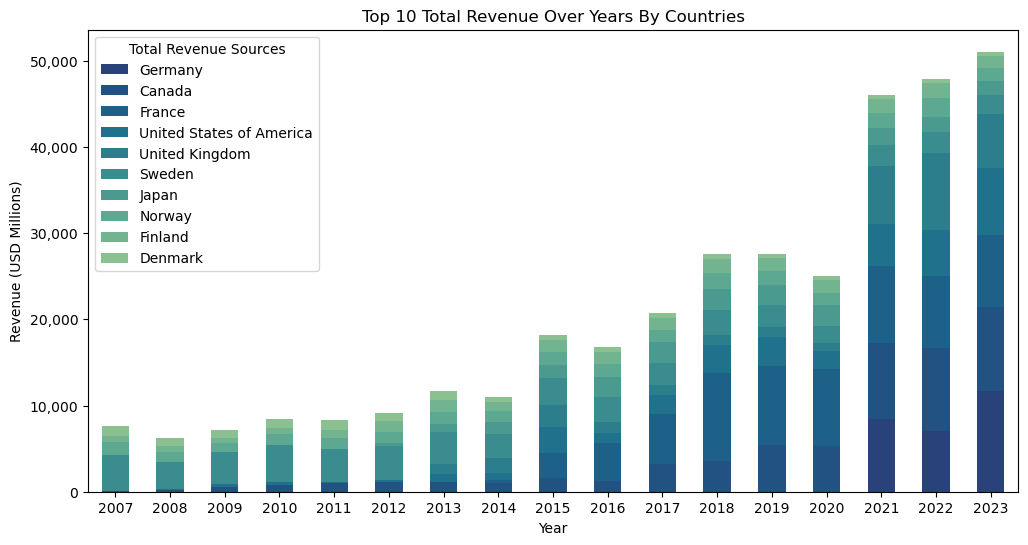

In [53]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('crest_r', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Total Revenue Over Years By Countries')
plt.xlabel('Year')
plt.ylabel('Revenue (USD Millions)')
plt.xticks(rotation=0)

plt.legend(title='Total Revenue Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

## Crediting Market

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import config
import folium
import json
import matplotlib.ticker as ticker
import urllib.request
import pycountry

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [2]:
sql_query = """
SELECT * FROM `carbon_pricing_latest_crediting_detail_`
"""

In [3]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_64094/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Mechanism Administration  \
0                      Alberta Emission Offset System   Governmental   
1                            American Carbon Registry    Independent   
2         Australian Carbon Credit Unit Scheme (ACCU)   Governmental   
3                   Beijing Forestry Offset Mechanism   Governmental   
4          Beijing Parking Offset Crediting Mechanism   Governmental   
5                     British Columbia Offset Program   Governmental   
6                California Compliance Offset Program   Governmental   
7                    Canada Federal GHG Offset System   Governmental   
8         Chile Green Tax Emissions Offsetting Scheme   Governmental   
9                         Clean Development Mechanism  International   
10                             Climate Action Reserve    Independent   
11                              Climate Credit System   Governmental   
12                       Colombia Crediting Mechanism   Governmental   
13                        Ecuador Crediting Mechanism   Governmental   
14                          Egypt Crediting Mechanism   Governmental   
15          EU Carbon Removal Certification Framework   Governmental   
16                                      Gold Standard    Independent   
17  Greenhouse Gas Crediting and Offsetting Mechan...   Governmental   
18                          India Crediting Mechanism   Governmental   
19                 Indo-Pacific Carbon Offsets Scheme   Governmental   
20                      Indonesia Crediting Mechanism   Governmental   
21                                    J-Credit Scheme   Governmental   
22                          Joint Crediting Mechanism   Governmental   
23                               Joint Implementation  International   
24                     Kazakhstan Crediting Mechanism   Governmental   
25                         Mexico Crediting Mechanism   Governmental   
26                         Murcia Crediting Mechanism   Governmental   
27                    Nova Scotia Crediting Mechanism   Governmental   
28                                      Peatland Code   Governmental   
29                                          Plan Vivo    Independent   
30                Portuguese Voluntary Carbon Market    Governmental   
31                  Quebec Offset Crediting Mechanism   Governmental   
32          Republic of Korea Offset Credit Mechanism   Governmental   
33                          RGGI CO2 Offset Mechanism   Governmental   
34     Saitama Forest Absorption Certification System   Governmental   
35    Saitama Target Setting Emissions Trading System   Governmental   
36          Sakhalin Oblast Pilot crediting mechanism   Governmental   
37                   South Africa Crediting Mechanism   Governmental   
38                              Spain FES-CO2 Program   Governmental   
39               Sri Lanka Carbon Crediting Mechanism   Governmental   
40   Switzerland CO2 Attestations Crediting Mechanism   Governmental   
41             Taiwan Voluntary GHG Reduction Program   Governmental   
42                           Verified Carbon Standard    Independent   
43                        Vietnam Crediting Mechanism   Governmental   
44                     Voluntary Carbon Credit System   Governmental   
45                     Washington Crediting Mechanism   Governmental   

               Status Year of Implementation        Scope  \
0         Implemented                   2007  Subnational   
1         Implemented                   1996       Global   
2         Implemented                   2012     National   
3         Implemented                   2014  Subnational   
4         Implemented                   2017  Subnational   
5         Implemented                   2016  Subnational   
6         Implemented                   2013  Subnational   
7         Implemented                   2022     National   
8         Implemented                   2024     National   
9         Implemented                   2006     

In [4]:
df.rename(columns={'Price (Range)': 'Price', 'Cumulativ_ credits_retired': 'Cumulative_credits_retired', 'Countries with project (ISO3 codes)': 'ISO'}, inplace=True)

df

Mechanism Administration  \
0                      Alberta Emission Offset System   Governmental   
1                            American Carbon Registry    Independent   
2         Australian Carbon Credit Unit Scheme (ACCU)   Governmental   
3                   Beijing Forestry Offset Mechanism   Governmental   
4          Beijing Parking Offset Crediting Mechanism   Governmental   
5                     British Columbia Offset Program   Governmental   
6                California Compliance Offset Program   Governmental   
7                    Canada Federal GHG Offset System   Governmental   
8         Chile Green Tax Emissions Offsetting Scheme   Governmental   
9                         Clean Development Mechanism  International   
10                             Climate Action Reserve    Independent   
11                              Climate Credit System   Governmental   
12                       Colombia Crediting Mechanism   Governmental   
13                        Ecuador Crediting Mechanism   Governmental   
14                          Egypt Crediting Mechanism   Governmental   
15          EU Carbon Removal Certification Framework   Governmental   
16                                      Gold Standard    Independent   
17  Greenhouse Gas Crediting and Offsetting Mechan...   Governmental   
18                          India Crediting Mechanism   Governmental   
19                 Indo-Pacific Carbon Offsets Scheme   Governmental   
20                      Indonesia Crediting Mechanism   Governmental   
21                                    J-Credit Scheme   Governmental   
22                          Joint Crediting Mechanism   Governmental   
23                               Joint Implementation  International   
24                     Kazakhstan Crediting Mechanism   Governmental   
25                         Mexico Crediting Mechanism   Governmental   
26                         Murcia Crediting Mechanism   Governmental   
27                    Nova Scotia Crediting Mechanism   Governmental   
28                                      Peatland Code   Governmental   
29                                          Plan Vivo    Independent   
30                Portuguese Voluntary Carbon Market    Governmental   
31                  Quebec Offset Crediting Mechanism   Governmental   
32          Republic of Korea Offset Credit Mechanism   Governmental   
33                          RGGI CO2 Offset Mechanism   Governmental   
34     Saitama Forest Absorption Certification System   Governmental   
35    Saitama Target Setting Emissions Trading System   Governmental   
36          Sakhalin Oblast Pilot crediting mechanism   Governmental   
37                   South Africa Crediting Mechanism   Governmental   
38                              Spain FES-CO2 Program   Governmental   
39               Sri Lanka Carbon Crediting Mechanism   Governmental   
40   Switzerland CO2 Attestations Crediting Mechanism   Governmental   
41             Taiwan Voluntary GHG Reduction Program   Governmental   
42                           Verified Carbon Standard    Independent   
43                        Vietnam Crediting Mechanism   Governmental   
44                     Voluntary Carbon Credit System   Governmental   
45                     Washington Crediting Mechanism   Governmental   

               Status Year of Implementation        Scope  \
0         Implemented                   2007  Subnational   
1         Implemented                   1996       Global   
2         Implemented                   2012     National   
3         Implemented                   2014  Subnational   
4         Implemented                   2017  Subnational   
5         Implemented                   2016  Subnational   
6         Implemented                   2013  Subnational   
7         Implemented                   2022     National   
8         Implemented                   2024     National   
9         Implemented                   2006     

### 價格

In [5]:
df['Price'].value_counts()

Price
                                                                                                                                                                                         20
Not available                                                                                                                                                                             2
n/a                                                                                                                                                                                       2
CAD65/tCO2e                                                                                                                                                                               1
US$1.62/tCO2e (2020)                                                                                                                                                                      1
CHF56-151/tCO2e (US$59-160/tCO2e) (2020)              

In [6]:
import re

# Extract price information from the text
def extract_price(text):
    # Regular expression pattern to find price information in the format US$X.XX
    pattern = r'US\$(\d+(\.\d+)?)'
    match = re.search(pattern, text)
    if match:
        return match.group(1)  # Return the price value
    else:
        return None  # Return None if price information is not found

# Apply the function to extract price information from the 'Price' column
df['Price_USD'] = df['Price'].apply(extract_price)

df['Price_USD']

0      None
1      5.38
2     20.05
3       2.1
4         7
5         6
6     20.99
7      None
8      None
9      None
10     2.34
11     None
12     None
13     None
14     None
15     None
16     5.27
17     None
18     None
19     None
20     None
21       67
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29      2.0
30     None
31    20.88
32      5.6
33        5
34     None
35        1
36     None
37     None
38    11.39
39     None
40       59
41     None
42     1.62
43     None
44     None
45     None
Name: Price_USD, dtype: object

In [7]:
import numpy as np
# 先將空值替換成NaN
df['Price'] = df['Price'].replace('', np.nan)

df_price = pd.DataFrame({'Mechanism': df['Mechanism'], 'Price': df['Price_USD']})
df_price

Mechanism  Price
0                      Alberta Emission Offset System   None
1                            American Carbon Registry   5.38
2         Australian Carbon Credit Unit Scheme (ACCU)  20.05
3                   Beijing Forestry Offset Mechanism    2.1
4          Beijing Parking Offset Crediting Mechanism      7
5                     British Columbia Offset Program      6
6                California Compliance Offset Program  20.99
7                    Canada Federal GHG Offset System   None
8         Chile Green Tax Emissions Offsetting Scheme   None
9                         Clean Development Mechanism   None
10                             Climate Action Reserve   2.34
11                              Climate Credit System   None
12                       Colombia Crediting Mechanism   None
13                        Ecuador Crediting Mechanism   None
14                          Egypt Crediting Mechanism   None
15          EU Carbon Removal Certification Framework   None
16                                      Gold Standard   5.27
17  Greenhouse Gas Crediting and Offsetting Mechan...   None
18                          India Crediting Mechanism   None
19                 Indo-Pacific Carbon Offsets Scheme   None
20                      Indonesia Crediting Mechanism   None
21                                    J-Credit Scheme     67
22                          Joint Crediting Mechanism   None
23                               Joint Implementation   None
24                     Kazakhstan Crediting Mechanism   None
25                         Mexico Crediting Mechanism   None
26                         Murcia Crediting Mechanism   None
27                    Nova Scotia Crediting Mechanism   None
28                                      Peatland Code   None
29                                          Plan Vivo    2.0
30                Portuguese Voluntary Carbon Market    None
31                  Quebec Offset Crediting Mechanism  20.88
32          Republic of Korea Offset Credit Mechanism    5.6
33                          RGGI CO2 Offset Mechanism      5
34     Saitama Forest Absorption Certification System   None
35    Saitama Target Setting Emissions Trading System      1
36          Sakhalin Oblast Pilot crediting mechanism   None
37                   South Africa Crediting Mechanism   None
38                              Spain FES-CO2 Program  11.39
39               Sri Lanka Carbon Crediting Mechanism   None
40   Switzerland CO2 Attestations Crediting Mechanism     59
41             Taiwan Voluntary GHG Reduction Program   None
42                           Verified Carbon Standard   1.62
43                        Vietnam Crediting Mechanism   None
44                     Voluntary Carbon Credit System   None
45                     Washington Crediting Mechanism   None

In [8]:
df_price = df_price.dropna(subset=['Price'])
df_price

Mechanism  Price
1                           American Carbon Registry   5.38
2        Australian Carbon Credit Unit Scheme (ACCU)  20.05
3                  Beijing Forestry Offset Mechanism    2.1
4         Beijing Parking Offset Crediting Mechanism      7
5                    British Columbia Offset Program      6
6               California Compliance Offset Program  20.99
10                            Climate Action Reserve   2.34
16                                     Gold Standard   5.27
21                                   J-Credit Scheme     67
29                                         Plan Vivo    2.0
31                 Quebec Offset Crediting Mechanism  20.88
32         Republic of Korea Offset Credit Mechanism    5.6
33                         RGGI CO2 Offset Mechanism      5
35   Saitama Target Setting Emissions Trading System      1
38                             Spain FES-CO2 Program  11.39
40  Switzerland CO2 Attestations Crediting Mechanism     59
42                          Verified Carbon Standard   1.62

### 從價格來看，各機制的平均數大概是在每公噸CO2排放量為14.27美元左右

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_64094/1037738310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')


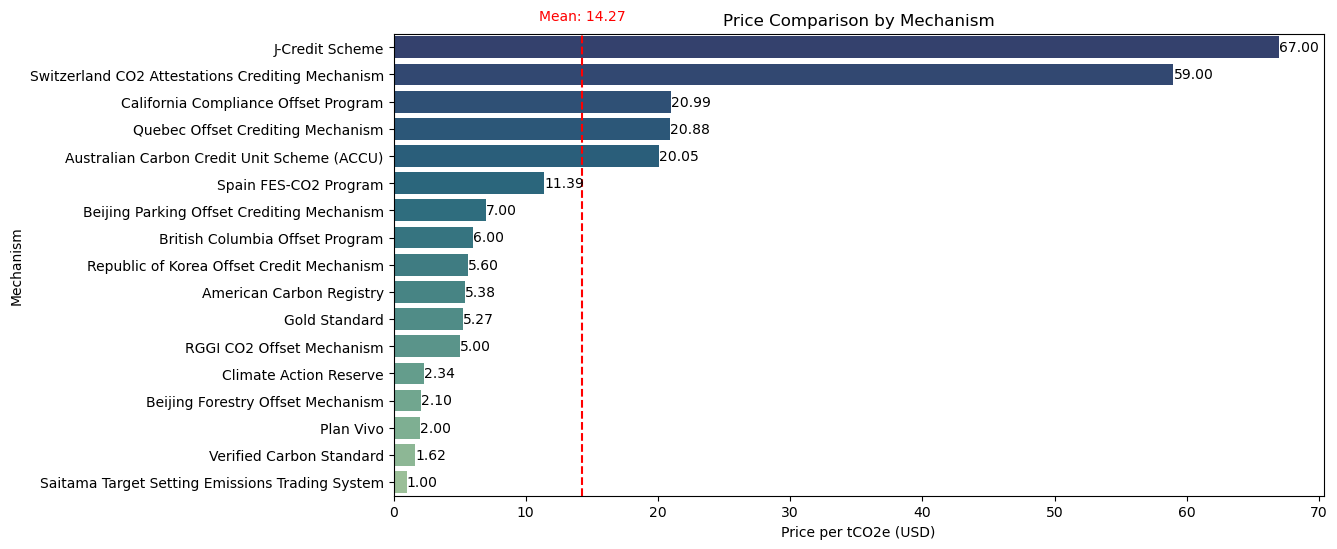

In [9]:
df_price['Price'] = pd.to_numeric(df_price['Price'], errors='coerce')
df_price = df_price.sort_values(by='Price', ascending=False)

plt.figure(figsize=(12, 6))

# Use barplot instead of histplot
sns.barplot(data=df_price, x='Price', y='Mechanism', palette='crest_r')

# Add text labels for each bar
for index, value in enumerate(df_price['Price']):
    plt.text(value, index, f'{value:.2f}', va='center')

# Calculate mean and add a vertical line
mean_price = df_price['Price'].mean()
plt.axvline(mean_price, color='red', linestyle='--', label=f'Mean Price: {mean_price:.2f} USD')

# Display the mean value on the plot
plt.text(mean_price, plt.gca().get_ylim()[1] - 0.5, f'Mean: {mean_price:.2f}', color='red', ha='center')

plt.title('Price Comparison by Mechanism')
plt.xlabel('Price per tCO2e (USD)')
plt.ylabel('Mechanism')

plt.show()

### 累計發行的碳信用額度、累計銷售的碳信用額度、累計取消的碳信用額度、累計註冊的項目

In [10]:
df.columns

Index(['Mechanism', 'Administration', 'Status', 'Year of Implementation',
       'Scope', 'Administering Jurisdiction or organisation', 'Region',
       'Credit name', 'Price', 'ISO', 'Agriculture', 'CCS / CCU',
       'Energy Efficiency / Fuel Switching', 'Forestry / Land Use',
       'Fugitive Emissions', 'Industrial Gases/Manufacturing',
       'Renewable Energy', 'Transport', 'Waste', 'Cumulative_credits_issued',
       'Cumulative_credits_retired', 'Cumulative_credits_cancelled',
       'Cumulative_projects_registered', 'Price_USD'],
      dtype='object')

In [11]:
def clean_and_convert(column):
    return pd.to_numeric(column.str.replace(',', '').str.strip(), errors='coerce').fillna(0).astype(int)

# Apply the function to specific columns
columns_to_convert = ['Cumulative_credits_issued', 'Cumulative_credits_retired', 'Cumulative_credits_cancelled', 'Cumulative_projects_registered']
df[columns_to_convert] = df[columns_to_convert].apply(clean_and_convert)
df[columns_to_convert]

Cumulative_credits_issued  Cumulative_credits_retired  \
0                       88589                       62869   
1                      267860                      190889   
2                      140400                      104200   
3                         200                           0   
4                         200                          15   
5                       17151                        6336   
6                      256912                      164614   
7                           0                           0   
8                         259                           0   
9                     2431808                           0   
10                     198487                      173188   
11                          0                           0   
12                     135926                       97108   
13                          0                           0   
14                          0                           0   
15                          0                           0   
16                     262753                      157490   
17                          0                           0   
18                          0                           0   
19                          0                           0   
20                          0                           0   
21                       9297                        6074   
22                        739                          78   
23                     871894                           0   
24                       1097                           0   
25                          0                           0   
26                          0                           0   
27                          0                           0   
28                          0                           0   
29                      10534                        7068   
30                          0                           0   
31                       1482                         988   
32                      51330                       33557   
33                         48                           0   
34                          4                           0   
35                      14190                        1621   
36                          0                           0   
37                      14710                       13589   
38                       4422                        4422   
39                         61                          35   
40                      13818                        8060   
41                      24370                           0   
42                    1185281                      670505   
43                          0                           0   
44                          0                           0   
45                        249                           0   

    Cumulative_credits_cancelled  Cumulative_projects_registered  
0                           1255                             406  
1                          12696                             282  
2                            200                            2048  
3                              0                               0  
4                              0                               0  
5                              0                              46  
6                           6451                             521  
7                              0                               1  
8                              0                               8  
9                           1035                            8535  
10                          1468                             674  
11                             0                               0  
12                             0                             383  
13                             0                               0  
14                             0                               0  
15                             0                               0

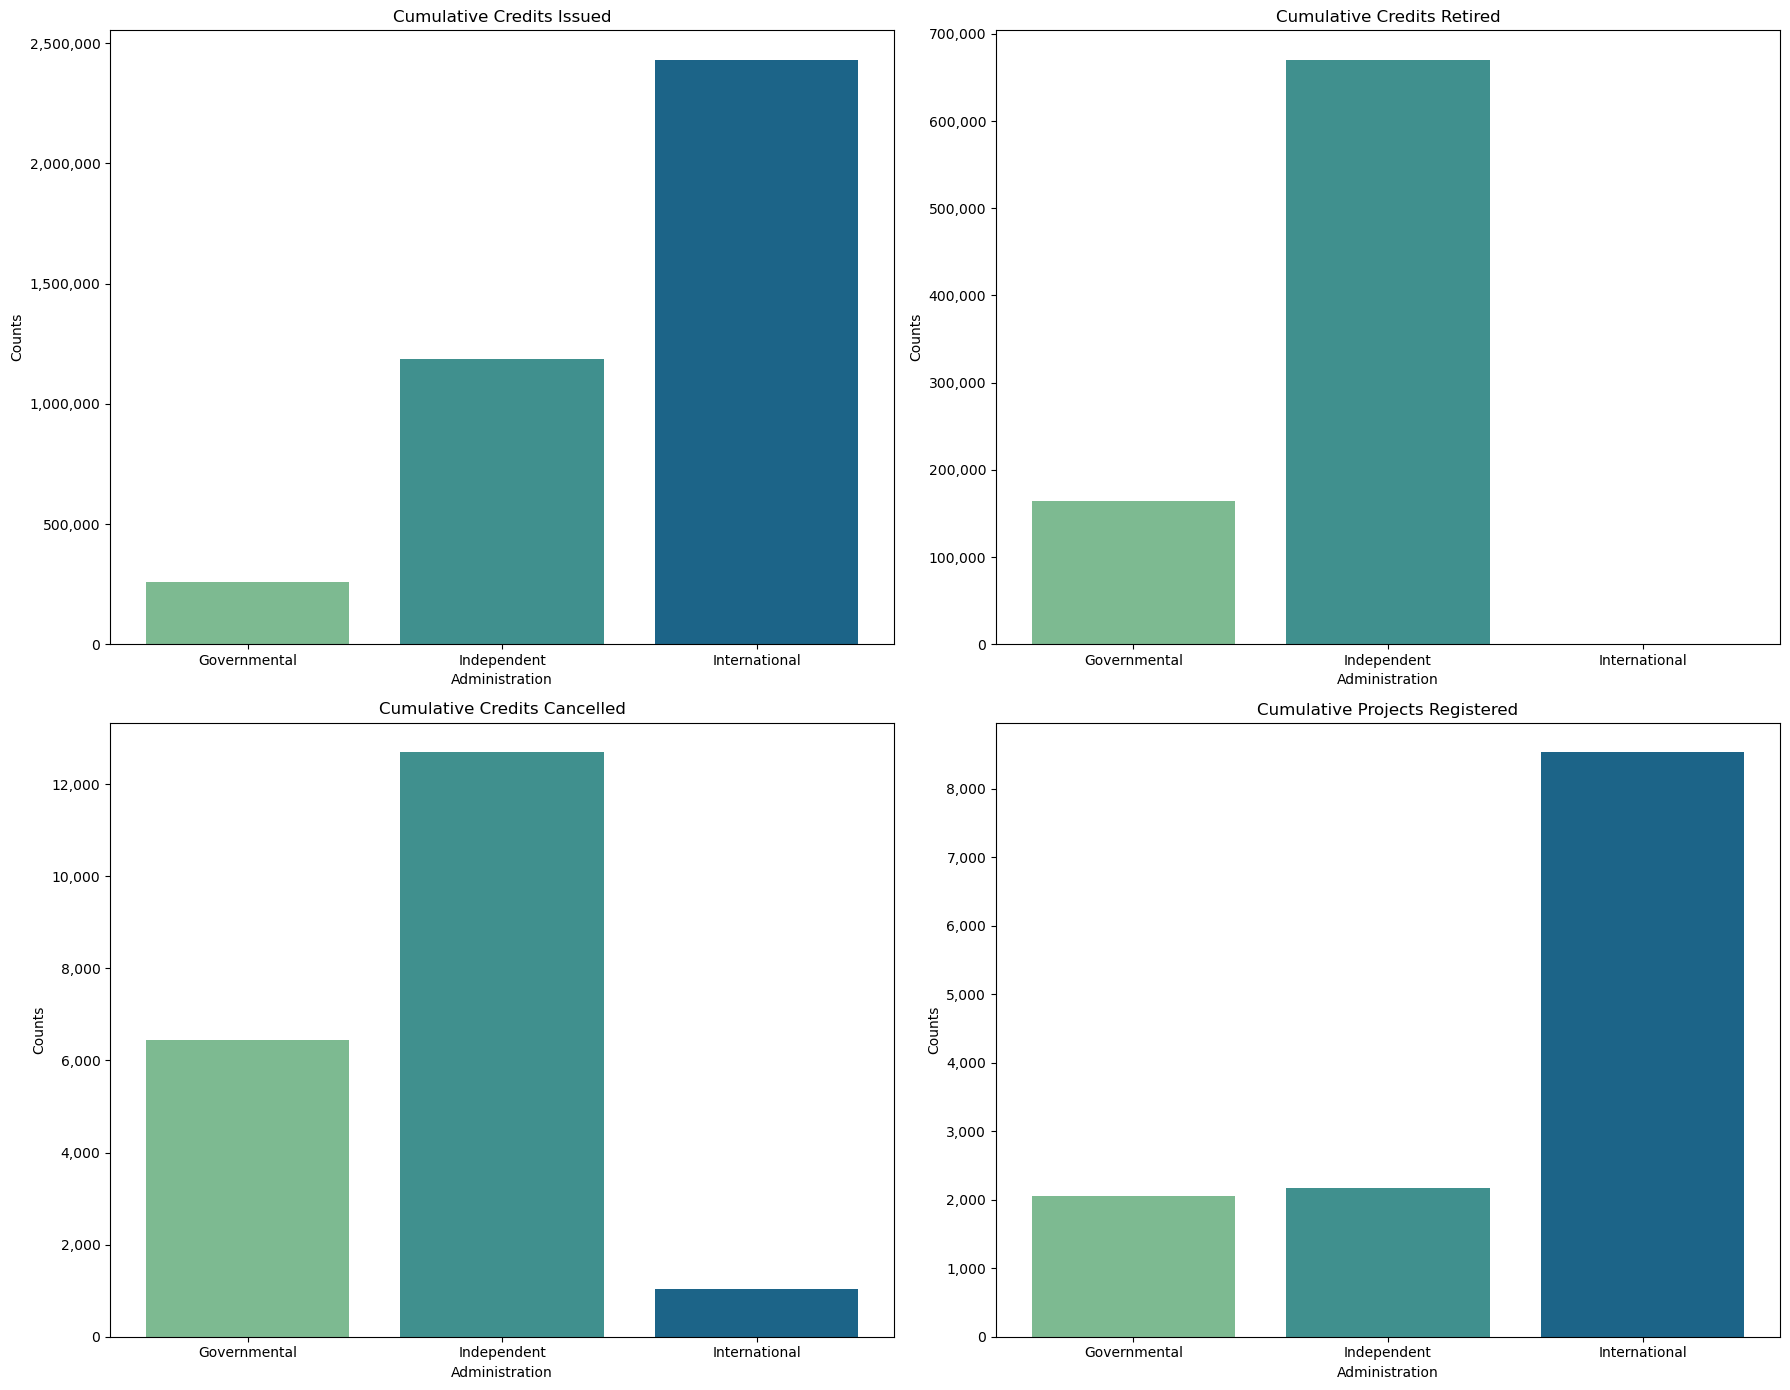

In [12]:
colors = {
    'Governmental': sns.color_palette('crest')[0],
    'Independent': sns.color_palette('crest')[2],
    'International': sns.color_palette('crest')[4]
}

df['Color'] = df['Administration'].map(colors)

# Create custom formatter for y-axis labels
formatter = ticker.StrMethodFormatter('{x:,.0f}')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Plot Cumulative Credits Issued
axes[0, 0].bar(df['Administration'], df['Cumulative_credits_issued'], color=df['Color'])
axes[0, 0].set_title('Cumulative Credits Issued')
axes[0, 0].set_xlabel('Administration')
axes[0, 0].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[0, 0].tick_params(axis='x')
axes[0, 0].yaxis.set_major_formatter(formatter)

# Plot Cumulative Credits Retired
axes[0, 1].bar(df['Administration'], df['Cumulative_credits_retired'], color=df['Color'])
axes[0, 1].set_title('Cumulative Credits Retired')
axes[0, 1].set_xlabel('Administration')
axes[0, 1].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[0, 1].tick_params(axis='x')
axes[0, 1].yaxis.set_major_formatter(formatter)

# Plot Cumulative Credits Cancelled
axes[1, 0].bar(df['Administration'], df['Cumulative_credits_cancelled'], color=df['Color'])
axes[1, 0].set_title('Cumulative Credits Cancelled')
axes[1, 0].set_xlabel('Administration')
axes[1, 0].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[1, 0].tick_params(axis='x')
axes[1, 0].yaxis.set_major_formatter(formatter)

# Plot Cumulative Projects Registered
axes[1, 1].bar(df['Administration'], df['Cumulative_projects_registered'], color=df['Color'])
axes[1, 1].set_title('Cumulative Projects Registered')
axes[1, 1].set_xlabel('Administration')
axes[1, 1].set_ylabel('Counts')  # Change ylabel to 'Counts'
axes[1, 1].tick_params(axis='x')
axes[1, 1].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

---

## 分布狀況

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import config
import folium
import json
import matplotlib.ticker as ticker
import urllib.request
import pycountry

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'trading',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [2]:
sql_query = """
SELECT * FROM `crediting_detail`
"""

In [3]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_3329/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Mechanism Administration  \
0                            American Carbon Registry    Independent   
1         Australian Carbon Credit Unit Scheme (ACCU)   Governmental   
2                   Beijing Forestry Offset Mechanism   Governmental   
3          Beijing Parking Offset Crediting Mechanism   Governmental   
4                     British Columbia Offset Program   Governmental   
5                California Compliance Offset Program   Governmental   
6                    Canada Federal GHG Offset System   Governmental   
7         Chile Green Tax Emissions Offsetting Scheme   Governmental   
8      China GHG Voluntary Emission Reduction Program   Governmental   
9                   Chongqing carbon offset mechanism   Governmental   
10                        Clean Development Mechanism  International   
11                             Climate Action Reserve    Independent   
12                              Climate Credit System   Governmental   
13                       Colombia Crediting Mechanism   Governmental   
14                        Ecuador Crediting Mechanism   Governmental   
15                          Egypt Crediting Mechanism   Governmental   
16          EU Carbon Removal Certification Framework   Governmental   
17         Fujian Forestry Offset Crediting Mechanism   Governmental   
18                                      Gold Standard    Independent   
19  Greenhouse Gas Crediting and Offsetting Mechan...   Governmental   
20        Guangdong Pu Hui Offset Crediting Mechanism   Governmental   
21                          India Crediting Mechanism   Governmental   
22                 Indo-Pacific Carbon Offsets Scheme   Governmental   
23                      Indonesia Crediting Mechanism   Governmental   
24                                    J-Credit Scheme   Governmental   
25                          Joint Crediting Mechanism   Governmental   
26                               Joint Implementation  International   
27                     Kazakhstan Crediting Mechanism   Governmental   
28                         Mexico Crediting Mechanism   Governmental   
29                         Murcia Crediting Mechanism   Governmental   
30                    Nova Scotia Crediting Mechanism   Governmental   
31                                      Peatland Code   Governmental   
32                                          Plan Vivo    Independent   
33                Portuguese Voluntary Carbon Market    Governmental   
34                  Quebec Offset Crediting Mechanism   Governmental   
35          Republic of Korea Offset Credit Mechanism   Governmental   
36                          RGGI CO2 Offset Mechanism   Governmental   
37     Saitama Forest Absorption Certification System   Governmental   
38    Saitama Target Setting Emissions Trading System   Governmental   
39          Sakhalin Oblast Pilot crediting mechanism   Governmental   
40                   South Africa Crediting Mechanism   Governmental   
41                              Spain FES-CO2 Program   Governmental   
42               Sri Lanka Carbon Crediting Mechanism   Governmental   
43   Switzerland CO2 Attestations Crediting Mechanism   Governmental   
44             Taiwan Voluntary GHG Reduction Program         Taiwan   
45      Thailand Voluntary Emission Reduction Program   Governmental   
46                            UK Woodland Carbon Code   Governmental   
47                           Verified Carbon Standard    Independent   
48                        Vietnam Crediting Mechanism   Governmental   
49                     Voluntary Carbon Credit System   Governmental   
50                     Washington Crediting Mechanism   Governmental   

               Status  Year        Scope  \
0         Implemented  1996       Global   
1         Implemented  2012     National   
2         Implemented  2014  Subnational   
3         Implemented  2017  Subnational   
4         Implemented  2016  Subnational   
5         Implemented  2013  Subnat

In [4]:
df.rename(columns={'Price (Range)': 'Price', 'Cumulativ_ credits_retired': 'Cumulative_credits_retired', 'Countries with project (ISO3 codes)': 'ISO'}, inplace=True)

df

Mechanism Administration  \
0                            American Carbon Registry    Independent   
1         Australian Carbon Credit Unit Scheme (ACCU)   Governmental   
2                   Beijing Forestry Offset Mechanism   Governmental   
3          Beijing Parking Offset Crediting Mechanism   Governmental   
4                     British Columbia Offset Program   Governmental   
5                California Compliance Offset Program   Governmental   
6                    Canada Federal GHG Offset System   Governmental   
7         Chile Green Tax Emissions Offsetting Scheme   Governmental   
8      China GHG Voluntary Emission Reduction Program   Governmental   
9                   Chongqing carbon offset mechanism   Governmental   
10                        Clean Development Mechanism  International   
11                             Climate Action Reserve    Independent   
12                              Climate Credit System   Governmental   
13                       Colombia Crediting Mechanism   Governmental   
14                        Ecuador Crediting Mechanism   Governmental   
15                          Egypt Crediting Mechanism   Governmental   
16          EU Carbon Removal Certification Framework   Governmental   
17         Fujian Forestry Offset Crediting Mechanism   Governmental   
18                                      Gold Standard    Independent   
19  Greenhouse Gas Crediting and Offsetting Mechan...   Governmental   
20        Guangdong Pu Hui Offset Crediting Mechanism   Governmental   
21                          India Crediting Mechanism   Governmental   
22                 Indo-Pacific Carbon Offsets Scheme   Governmental   
23                      Indonesia Crediting Mechanism   Governmental   
24                                    J-Credit Scheme   Governmental   
25                          Joint Crediting Mechanism   Governmental   
26                               Joint Implementation  International   
27                     Kazakhstan Crediting Mechanism   Governmental   
28                         Mexico Crediting Mechanism   Governmental   
29                         Murcia Crediting Mechanism   Governmental   
30                    Nova Scotia Crediting Mechanism   Governmental   
31                                      Peatland Code   Governmental   
32                                          Plan Vivo    Independent   
33                Portuguese Voluntary Carbon Market    Governmental   
34                  Quebec Offset Crediting Mechanism   Governmental   
35          Republic of Korea Offset Credit Mechanism   Governmental   
36                          RGGI CO2 Offset Mechanism   Governmental   
37     Saitama Forest Absorption Certification System   Governmental   
38    Saitama Target Setting Emissions Trading System   Governmental   
39          Sakhalin Oblast Pilot crediting mechanism   Governmental   
40                   South Africa Crediting Mechanism   Governmental   
41                              Spain FES-CO2 Program   Governmental   
42               Sri Lanka Carbon Crediting Mechanism   Governmental   
43   Switzerland CO2 Attestations Crediting Mechanism   Governmental   
44             Taiwan Voluntary GHG Reduction Program         Taiwan   
45      Thailand Voluntary Emission Reduction Program   Governmental   
46                            UK Woodland Carbon Code   Governmental   
47                           Verified Carbon Standard    Independent   
48                        Vietnam Crediting Mechanism   Governmental   
49                     Voluntary Carbon Credit System   Governmental   
50                     Washington Crediting Mechanism   Governmental   

               Status  Year        Scope  \
0         Implemented  1996       Global   
1         Implemented  2012     National   
2         Implemented  2014  Subnational   
3         Implemented  2017  Subnational   
4         Implemented  2016  Subnational   
5         Implemented  2013  Subnat

In [5]:
# Splitting ISO codes and creating a new DataFrame with individual ISO codes
iso_split = df['ISO'].str.split(', ')
scope_iso = pd.DataFrame({
    'Mechanism': df['Mechanism'].repeat(iso_split.str.len()),
    'Scope': df['Scope'].repeat(iso_split.str.len()),
    'ISO': [iso for sublist in iso_split for iso in sublist]
})

# Reset index
scope_iso.reset_index(drop=True, inplace=True)
scope_iso

Mechanism        Scope  ISO
0          American Carbon Registry       Global  BOL
1          American Carbon Registry       Global  BRA
2          American Carbon Registry       Global  CAN
3          American Carbon Registry       Global  FRA
4          American Carbon Registry       Global  MEX
..                              ...          ...  ...
339        Verified Carbon Standard       Global  ZMB
340        Verified Carbon Standard       Global  ZWE
341     Vietnam Crediting Mechanism     National     
342  Voluntary Carbon Credit System  Subnational     
343  Washington Crediting Mechanism  Subnational  USA

[344 rows x 3 columns]

In [6]:
# Mapping country names to ISO codes
country_iso_mapping = {}
for country in pycountry.countries:
    if hasattr(country, 'alpha_3'):
        country_iso_mapping[country.name] = country.alpha_3

country_iso_mapping

{'Aruba': 'ABW',
 'Afghanistan': 'AFG',
 'Angola': 'AGO',
 'Anguilla': 'AIA',
 'Åland Islands': 'ALA',
 'Albania': 'ALB',
 'Andorra': 'AND',
 'United Arab Emirates': 'ARE',
 'Argentina': 'ARG',
 'Armenia': 'ARM',
 'American Samoa': 'ASM',
 'Antarctica': 'ATA',
 'French Southern Territories': 'ATF',
 'Antigua and Barbuda': 'ATG',
 'Australia': 'AUS',
 'Austria': 'AUT',
 'Azerbaijan': 'AZE',
 'Burundi': 'BDI',
 'Belgium': 'BEL',
 'Benin': 'BEN',
 'Bonaire, Sint Eustatius and Saba': 'BES',
 'Burkina Faso': 'BFA',
 'Bangladesh': 'BGD',
 'Bulgaria': 'BGR',
 'Bahrain': 'BHR',
 'Bahamas': 'BHS',
 'Bosnia and Herzegovina': 'BIH',
 'Saint Barthélemy': 'BLM',
 'Belarus': 'BLR',
 'Belize': 'BLZ',
 'Bermuda': 'BMU',
 'Bolivia, Plurinational State of': 'BOL',
 'Brazil': 'BRA',
 'Barbados': 'BRB',
 'Brunei Darussalam': 'BRN',
 'Bhutan': 'BTN',
 'Bouvet Island': 'BVT',
 'Botswana': 'BWA',
 'Central African Republic': 'CAF',
 'Canada': 'CAN',
 'Cocos (Keeling) Islands': 'CCK',
 'Switzerland': 'CHE',
 

In [7]:
# Splitting ISO codes and creating a new DataFrame with individual ISO codes
iso_split = df['ISO'].str.split(', ')
scope_iso = pd.DataFrame({
    'Mechanism': df['Mechanism'].repeat(iso_split.str.len()),
    'Scope': df['Scope'].repeat(iso_split.str.len()),
    'ISO': [iso for sublist in iso_split for iso in sublist]
})

# Reset indexx
scope_iso.reset_index(drop=True, inplace=True)
scope_iso

Mechanism        Scope  ISO
0          American Carbon Registry       Global  BOL
1          American Carbon Registry       Global  BRA
2          American Carbon Registry       Global  CAN
3          American Carbon Registry       Global  FRA
4          American Carbon Registry       Global  MEX
..                              ...          ...  ...
339        Verified Carbon Standard       Global  ZMB
340        Verified Carbon Standard       Global  ZWE
341     Vietnam Crediting Mechanism     National     
342  Voluntary Carbon Credit System  Subnational     
343  Washington Crediting Mechanism  Subnational  USA

[344 rows x 3 columns]

In [8]:
# 找出ISO包含中國的所有機制數量（包括Global）
count = (scope_iso['ISO'] == 'CHN').sum()
count

9

In [9]:
df_iso_codes = set(scope_iso['ISO'])

# Extract ISO codes from country_iso_mapping
country_iso_mapping_codes = set(country_iso_mapping.values())

# Find ISO codes present in DataFrame but not in country_iso_mapping
missing_iso_codes_in_mapping = df_iso_codes - country_iso_mapping_codes

print('ISO codes present in DataFrame but not in country_iso_mapping:')
print(missing_iso_codes_in_mapping)

ISO codes present in DataFrame but not in country_iso_mapping:
{'', 'INT'}


In [10]:
# 修改台灣名稱
country_iso_mapping['Taiwan'] = country_iso_mapping.pop('Taiwan, Province of China')

In [11]:
import pandas as pd
import json
import urllib.request
import folium
import seaborn as sns
import matplotlib.colors as mcolors
import branca.colormap as cm

iso_split = df['ISO'].str.split(', ')
scope_iso = pd.DataFrame({
    'Mechanism': df['Mechanism'].repeat(iso_split.str.len()),
    'Scope': df['Scope'].repeat(iso_split.str.len()),
    'ISO': [iso for sublist in iso_split for iso in sublist]
})

# reset index
scope_iso.reset_index(drop=True, inplace=True)

# 計算各國參與機制數
country_counts = scope_iso['ISO'].value_counts().to_dict()

world_geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'
with urllib.request.urlopen(world_geojson_url) as response:
    world_geojson = json.load(response)


cmap = sns.color_palette('crest', as_cmap=True)

m = folium.Map(location=[0, 0], zoom_start=2, min_zoom=2, max_zoom=10)

def style_function(feature):
    country_iso = feature['id']
    count = country_counts.get(country_iso, 0)
    
    if count > 0:
        color = cmap(count / max(country_counts.values()))
        color = mcolors.rgb2hex(color)
    else:
        color = '#e8dfd8'
    
    return {
        'fillColor': color,
        'fillOpacity': 0.7,
        'weight': 1.0,
        'color': None
    }

geojson_layer = folium.GeoJson(
    world_geojson, 
    style_function=style_function
).add_to(m)

# tooltip
for feature in world_geojson['features']:
    country_iso = feature['id']
    if country_iso in country_iso_mapping.values():
        country_name = [name for name, iso in country_iso_mapping.items() if iso == country_iso][0]
        count = country_counts.get(country_iso, 0)
        tooltip = folium.Tooltip(f"""
            Country: {country_name}<br>
            Mechanism Count: {count}
        """)
        folium.GeoJson(
            feature, 
            tooltip=tooltip, 
            style_function=style_function
        ).add_to(m)

# colormap
colormap = cm.LinearColormap(
    cmap.colors,
    vmin=1, # min=1, not 0(Not Applicable)
    vmax=max(country_counts.values()),
    caption='Mechanism Count'
)

colormap.add_to(m)

legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 30px; width: 180px; height: 80px; 
                 border:2px solid grey; z-index:9999; font-size:11px;
                 background-color:white; opacity: 0.8; padding: 10px;">
     </div>
     '''
m.save('credit.html')
m

In [12]:
df

Mechanism Administration  \
0                            American Carbon Registry    Independent   
1         Australian Carbon Credit Unit Scheme (ACCU)   Governmental   
2                   Beijing Forestry Offset Mechanism   Governmental   
3          Beijing Parking Offset Crediting Mechanism   Governmental   
4                     British Columbia Offset Program   Governmental   
5                California Compliance Offset Program   Governmental   
6                    Canada Federal GHG Offset System   Governmental   
7         Chile Green Tax Emissions Offsetting Scheme   Governmental   
8      China GHG Voluntary Emission Reduction Program   Governmental   
9                   Chongqing carbon offset mechanism   Governmental   
10                        Clean Development Mechanism  International   
11                             Climate Action Reserve    Independent   
12                              Climate Credit System   Governmental   
13                       Colombia Crediting Mechanism   Governmental   
14                        Ecuador Crediting Mechanism   Governmental   
15                          Egypt Crediting Mechanism   Governmental   
16          EU Carbon Removal Certification Framework   Governmental   
17         Fujian Forestry Offset Crediting Mechanism   Governmental   
18                                      Gold Standard    Independent   
19  Greenhouse Gas Crediting and Offsetting Mechan...   Governmental   
20        Guangdong Pu Hui Offset Crediting Mechanism   Governmental   
21                          India Crediting Mechanism   Governmental   
22                 Indo-Pacific Carbon Offsets Scheme   Governmental   
23                      Indonesia Crediting Mechanism   Governmental   
24                                    J-Credit Scheme   Governmental   
25                          Joint Crediting Mechanism   Governmental   
26                               Joint Implementation  International   
27                     Kazakhstan Crediting Mechanism   Governmental   
28                         Mexico Crediting Mechanism   Governmental   
29                         Murcia Crediting Mechanism   Governmental   
30                    Nova Scotia Crediting Mechanism   Governmental   
31                                      Peatland Code   Governmental   
32                                          Plan Vivo    Independent   
33                Portuguese Voluntary Carbon Market    Governmental   
34                  Quebec Offset Crediting Mechanism   Governmental   
35          Republic of Korea Offset Credit Mechanism   Governmental   
36                          RGGI CO2 Offset Mechanism   Governmental   
37     Saitama Forest Absorption Certification System   Governmental   
38    Saitama Target Setting Emissions Trading System   Governmental   
39          Sakhalin Oblast Pilot crediting mechanism   Governmental   
40                   South Africa Crediting Mechanism   Governmental   
41                              Spain FES-CO2 Program   Governmental   
42               Sri Lanka Carbon Crediting Mechanism   Governmental   
43   Switzerland CO2 Attestations Crediting Mechanism   Governmental   
44             Taiwan Voluntary GHG Reduction Program         Taiwan   
45      Thailand Voluntary Emission Reduction Program   Governmental   
46                            UK Woodland Carbon Code   Governmental   
47                           Verified Carbon Standard    Independent   
48                        Vietnam Crediting Mechanism   Governmental   
49                     Voluntary Carbon Credit System   Governmental   
50                     Washington Crediting Mechanism   Governmental   

               Status  Year        Scope  \
0         Implemented  1996       Global   
1         Implemented  2012     National   
2         Implemented  2014  Subnational   
3         Implemented  2017  Subnational   
4         Implemented  2016  Subnational   
5         Implemented  2013  Subnat

In [13]:
# 取出只在中國實行的機制
def China(df):
    chn_data = df[df['ISO'] == 'CHN']
    return chn_data

chn_df = China(df)
chn_df

Mechanism Administration  \
2                Beijing Forestry Offset Mechanism   Governmental   
3       Beijing Parking Offset Crediting Mechanism   Governmental   
8   China GHG Voluntary Emission Reduction Program   Governmental   
9                Chongqing carbon offset mechanism   Governmental   
17      Fujian Forestry Offset Crediting Mechanism   Governmental   
20     Guangdong Pu Hui Offset Crediting Mechanism   Governmental   

         Status  Year        Scope Administering Jurisdiction or organisation  \
2   Implemented  2014  Subnational                                    Beijing   
3   Implemented  2017  Subnational                                    Beijing   
8   Implemented  2014     National                                      China   
9   Implemented  2021  Subnational                                  Chongqing   
17  Implemented  2017  Subnational                                     Fujian   
20  Implemented  2017  Subnational                Guangdong (except Shenzhen)   

                 Region                                        Credit name  \
2   East Asia & Pacific  Beijing Forestry Certified Emission Reductions...   
3   East Asia & Pacific      Parking Certified Emission Reductions (PCERs)   
8   East Asia & Pacific      Chinese Certified Emission Reductions (CCERs)   
9   East Asia & Pacific     Chongqing Certified Emission Reduction (CQCER)   
17  East Asia & Pacific  Fujian Forestry Certified Emission Reduction (...   
20  East Asia & Pacific     Pu Hui Certified Emissions Reductions (PHCERs)   

    ISO Agriculture  ... Forestry / Land Use Fugitive Emissions  \
2   CHN          No  ...                 Yes                 No   
3   CHN          No  ...                  No                 No   
8   CHN          No  ...                 Yes                 No   
9   CHN          No  ...                 Yes                 No   
17  CHN          No  ...                 Yes                 No   
20  CHN          No  ...                 Yes                 No   

   Industrial Gases/Manufacturing Renewable Energy Transport Waste  \
2                              No               No        No    No   
3                              No               No       Yes    No   
8                              No              Yes        No   Yes   
9                              No              Yes        No   Yes   
17                             No               No        No    No   
20                             No              Yes        No    No   

   Cumulative_credits_issued Cumulative_credits_retired  \
2                       200                        -      
3                       200                         15    
8                    77,000                     69,000    
9                     1,915                        -      
17                    2,900              Not available    
20                    2,079              Not available    

   Cumulative_credits_cancelled Cumulative_projects_registered  
2                          -                    Not available   
3                Not available                  Not available   
8                        8,000                          1,047   
9                          -                    Not available   
17               Not available                             20   
20               Not available                            180   

[6 rows x 22 columns]

In [14]:
# 分別計算National、Subnational數量
national_counts = df[(df['Scope'] == 'National') & (df['Status'] == 'Implemented')].groupby('ISO').size()
subnational_counts = df[(df['Scope'] == 'Subnational') & (df['Status'] == 'Implemented')].groupby('ISO').size()

print(national_counts)
print(subnational_counts)

ISO
AUS    1
CAN    1
CHE    1
CHL    1
CHN    1
COL    1
ESP    1
GBR    2
JPN    1
KAZ    1
KOR    1
LKA    1
PRT    1
SAU    1
THA    1
TWN    1
ZAF    1
dtype: int64
ISO
CAN    3
CHN    5
JPN    2
RUS    1
USA    3
dtype: int64


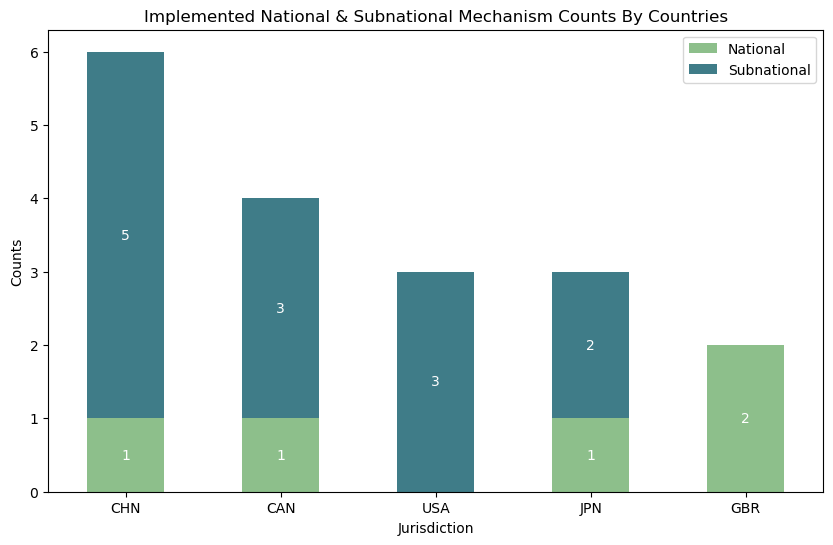

In [15]:
# 合併 National 和 Subnational 資料
merged_counts = pd.concat([national_counts, subnational_counts], axis=1)
merged_counts.columns = ['National', 'Subnational']

# # 替換'United States of America'為'United States'
# merged_counts.rename(index={'United States of America': 'United States'}, inplace=True)

# 計算每個jurisdiction的總數量並排序
merged_counts['Total'] = merged_counts.sum(axis=1)  # 計算總數量
merged_counts = merged_counts.sort_values(by='Total', ascending=False) 
erged_counts = merged_counts.head(5)

# 提取索引中的國家名稱作為 x 軸標籤
countries = merged_counts.index.get_level_values(0)

ax = merged_counts.head(5).drop(columns='Total').plot(kind='bar', stacked=True, figsize=(10, 6), color=['#8dbf8b', '#3F7C88'])

for p in ax.patches:
    width = p.get_width()  # width
    height = p.get_height()  # height
    x, y = p.get_xy()  # 起始點座標
    if height > 0: 
        ax.annotate(f'{height:.0f}', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')
        
    
# 設置標籤和標題
plt.xlabel('Jurisdiction')
plt.ylabel('Counts')
plt.title('Implemented National & Subnational Mechanism Counts By Countries')
plt.xticks(rotation=0)

# 顯示圖形
plt.show()

---

### 實行中類型、數量

In [16]:
df

Mechanism Administration  \
0                            American Carbon Registry    Independent   
1         Australian Carbon Credit Unit Scheme (ACCU)   Governmental   
2                   Beijing Forestry Offset Mechanism   Governmental   
3          Beijing Parking Offset Crediting Mechanism   Governmental   
4                     British Columbia Offset Program   Governmental   
5                California Compliance Offset Program   Governmental   
6                    Canada Federal GHG Offset System   Governmental   
7         Chile Green Tax Emissions Offsetting Scheme   Governmental   
8      China GHG Voluntary Emission Reduction Program   Governmental   
9                   Chongqing carbon offset mechanism   Governmental   
10                        Clean Development Mechanism  International   
11                             Climate Action Reserve    Independent   
12                              Climate Credit System   Governmental   
13                       Colombia Crediting Mechanism   Governmental   
14                        Ecuador Crediting Mechanism   Governmental   
15                          Egypt Crediting Mechanism   Governmental   
16          EU Carbon Removal Certification Framework   Governmental   
17         Fujian Forestry Offset Crediting Mechanism   Governmental   
18                                      Gold Standard    Independent   
19  Greenhouse Gas Crediting and Offsetting Mechan...   Governmental   
20        Guangdong Pu Hui Offset Crediting Mechanism   Governmental   
21                          India Crediting Mechanism   Governmental   
22                 Indo-Pacific Carbon Offsets Scheme   Governmental   
23                      Indonesia Crediting Mechanism   Governmental   
24                                    J-Credit Scheme   Governmental   
25                          Joint Crediting Mechanism   Governmental   
26                               Joint Implementation  International   
27                     Kazakhstan Crediting Mechanism   Governmental   
28                         Mexico Crediting Mechanism   Governmental   
29                         Murcia Crediting Mechanism   Governmental   
30                    Nova Scotia Crediting Mechanism   Governmental   
31                                      Peatland Code   Governmental   
32                                          Plan Vivo    Independent   
33                Portuguese Voluntary Carbon Market    Governmental   
34                  Quebec Offset Crediting Mechanism   Governmental   
35          Republic of Korea Offset Credit Mechanism   Governmental   
36                          RGGI CO2 Offset Mechanism   Governmental   
37     Saitama Forest Absorption Certification System   Governmental   
38    Saitama Target Setting Emissions Trading System   Governmental   
39          Sakhalin Oblast Pilot crediting mechanism   Governmental   
40                   South Africa Crediting Mechanism   Governmental   
41                              Spain FES-CO2 Program   Governmental   
42               Sri Lanka Carbon Crediting Mechanism   Governmental   
43   Switzerland CO2 Attestations Crediting Mechanism   Governmental   
44             Taiwan Voluntary GHG Reduction Program         Taiwan   
45      Thailand Voluntary Emission Reduction Program   Governmental   
46                            UK Woodland Carbon Code   Governmental   
47                           Verified Carbon Standard    Independent   
48                        Vietnam Crediting Mechanism   Governmental   
49                     Voluntary Carbon Credit System   Governmental   
50                     Washington Crediting Mechanism   Governmental   

               Status  Year        Scope  \
0         Implemented  1996       Global   
1         Implemented  2012     National   
2         Implemented  2014  Subnational   
3         Implemented  2017  Subnational   
4         Implemented  2016  Subnational   
5         Implemented  2013  Subnat

In [17]:
df['Scope'].value_counts()

Scope
National       24
Subnational    17
Global          7
Regional        3
Name: count, dtype: int64

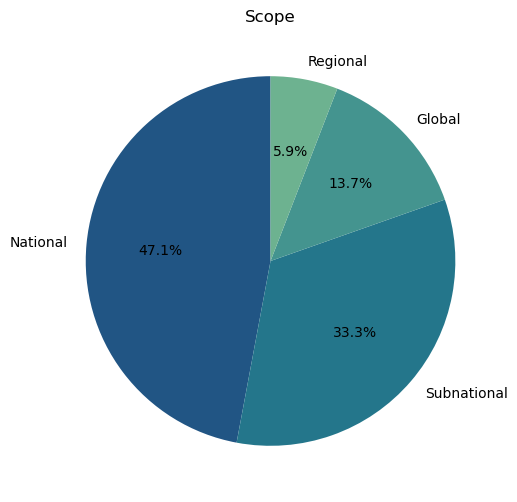

In [18]:
# Define your scope data
scope_data = pd.DataFrame({'Scope': ['National', 'Subnational', 'Global', 'Regional'], 'count': [24, 17, 7, 3]})

# Set a custom color palette
colors = sns.color_palette('crest_r', len(scope_data)) #'YlGn_r'

plt.figure(figsize=(8, 6))
plt.pie(scope_data['count'], labels=scope_data['Scope'], colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Scope')

plt.show()


In [19]:
df['Status'].value_counts()

Status
Implemented          40
Under development    11
Name: count, dtype: int64

### 目前全球已經開始實行的合規機制數量為40個（78.4%），還沒正式上路、仍在計畫中的為11個（21.6%）

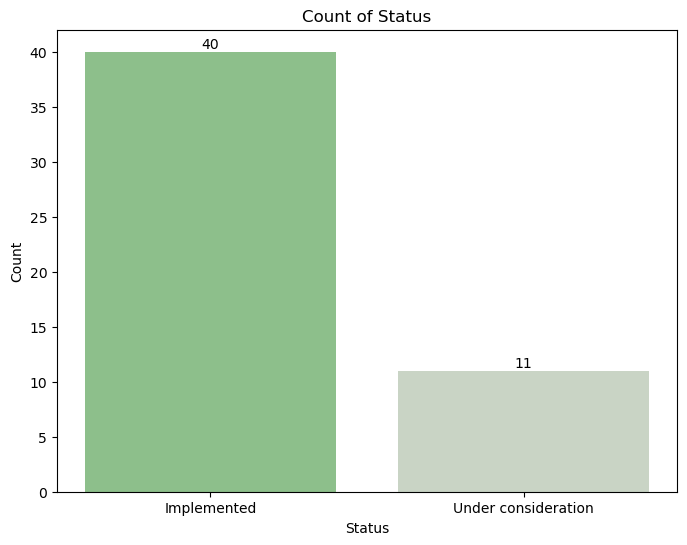

In [20]:
status_data = pd.DataFrame({'df': ['Implemented', 'Under consideration'], 'count': [40, 11]})

colors=['#8dbf8b', '#C9D4C5']

plt.figure(figsize=(8, 6))
bars = plt.bar(status_data['df'], status_data['count'], color=colors)

# 標數值
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.xlabel('Status')
plt.ylabel('Count')
plt.title('Count of Status')

plt.show()

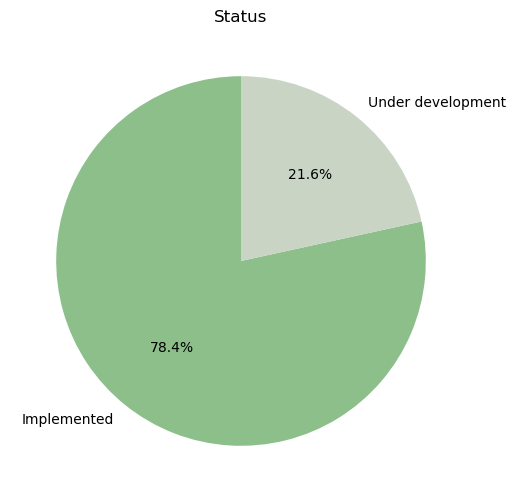

In [21]:
status_data = pd.DataFrame({'Status': ['Implemented', 'Under development'], 'count': [40, 11]})

colors=['#8dbf8b', '#C9D4C5'] #colors = sns.color_palette('YlGn_r', len(status_data))

plt.figure(figsize=(8, 6))
plt.pie(status_data['count'], labels=status_data['Status'], colors=colors, autopct='%1.1f%%', startangle=90)

plt.title('Status')

plt.show()

---

## Crediting Issuance

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import config
import folium
import json
import urllib

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'carbon',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [2]:
sql_query = """
SELECT * FROM `Crediting_Issuance`
"""

In [3]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_64588/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Mechanism       2002      2003  \
0                     Alberta Emission Offset System       -         -      
1                           American Carbon Registry   125,000       -      
2               Australian Carbon Credit Unit Scheme       -         -      
3                  Beijing Forestry Offset Mechanism       -         -      
4         Beijing Parking Offset Crediting Mechanism       -         -      
5                    British Columbia Offset Program       -         -      
6               California Compliance Offset Program       -         -      
7                          Chile Crediting Mechanism       -         -      
8     China GHG Voluntary Emission Reduction Program       -         -      
9                  Chongqing carbon offset mechanism       -         -      
10                       Clean Development Mechanism       -         -      
11                            Climate Action Reserve       -         -      
12                      Colombia Crediting Mechanism       -         -      
13        Fujian Forestry Offset Crediting Mechanism       -         -      
14                                     Gold Standard       -         -      
15       Guangdong Pu Hui Offset Crediting Mechanism       -         -      
16                                   J-Credit Scheme       -         -      
17                         Joint Crediting Mechanism       -         -      
18                              Joint Implementation       -         -      
19                    Kazakhstan Crediting Mechanism       -         -      
20                                         Plan Vivo    46,679    48,755    
21                 Quebec Offset Crediting Mechanism       -         -      
22         Republic of Korea Offset Credit Mechanism       -         -      
23                         RGGI CO2 Offset Mechanism       -         -      
24    Saitama Forest Absorption Certification System       -         -      
25   Saitama Target Setting Emissions Trading System       -         -      
26         Sakhalin Oblast Pilot crediting mechanism       -         -      
27                  South Africa Crediting Mechanism       -         -      
28                             Spain FES-CO2 Program       -         -      
29              Sri Lanka Carbon Crediting Mechanism       -         -      
30  Switzerland CO2 Attestations Crediting Mechanism       -         -      
31              Taiwan GHG Offset Management Program       -         -      
32     Thailand Voluntary Emission Reduction Program       -         -      
33                       Tokyo Cap-and-Trade Program       -         -      
34                           UK Woodland Carbon Code       -         -      
35                          Verified Carbon Standard       -         -      

        2004         2005          2006          2007           2008  \
0       -            -             -             -              -      
1       500    2,880,358    11,027,146     5,847,510      7,938,812    
2       -            -             -             -              -      
3       -            -             -             -              -      
4       -            -             -             -              -      
5       -            -             -             -              -      
6       -            -             -             -              -      
7       -            -             -             -              -      
8       -            -             -             -              -      
9       -            -             -             -              -      
10      -        103,732    25,688,774    76,688,338    137,874,364    
11      -            -             -             -          426,862    
12      -            -             -             -              -      
13      -            -             -             -              -      
14      -            -             -             -          819,181    
15      -            -             -     

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Mechanism  36 non-null     object
 1   2002       36 non-null     object
 2   2003       36 non-null     object
 3   2004       36 non-null     object
 4   2005       36 non-null     object
 5   2006       36 non-null     object
 6   2007       36 non-null     object
 7   2008       36 non-null     object
 8   2009       36 non-null     object
 9   2010       36 non-null     object
 10  2011       36 non-null     object
 11  2012       36 non-null     object
 12  2013       36 non-null     object
 13  2014       36 non-null     object
 14  2015       36 non-null     object
 15  2016       36 non-null     object
 16  2017       36 non-null     object
 17  2018       36 non-null     object
 18  2019       36 non-null     object
 19  2020       36 non-null     object
 20  2021       36 non-null     object


In [5]:
country = ['Canada', 'United States', 'Australia', 'China', 'China', 'Canada', 'United States',
           'Canada', 'Chile', 'China', 'China', None, None, 'Colombia', 'Ecuador', 'Egypt', None, 
           'China', None, None, 'China', None, 'India', None, 'Indonesia', None, None, None,
           'Kazakhstan', 'Mexico', 'Spain', 'Canada', 'United Kingdom', None, 'Portugal', 'Canada', 
           'South Korea', 'United States', 'Japan', 'Japan', 'Russia', 'South Africa', 'Spain', 
           'Sri Lanka', 'Switzerland', 'Taiwan', 'Thailand', 'United Kingdom', None, None, 'United States']
country_series = pd.Series(country)

In [6]:
df['country'] = country_series
df

Mechanism       2002      2003  \
0                     Alberta Emission Offset System       -         -      
1                           American Carbon Registry   125,000       -      
2               Australian Carbon Credit Unit Scheme       -         -      
3                  Beijing Forestry Offset Mechanism       -         -      
4         Beijing Parking Offset Crediting Mechanism       -         -      
5                    British Columbia Offset Program       -         -      
6               California Compliance Offset Program       -         -      
7                          Chile Crediting Mechanism       -         -      
8     China GHG Voluntary Emission Reduction Program       -         -      
9                  Chongqing carbon offset mechanism       -         -      
10                       Clean Development Mechanism       -         -      
11                            Climate Action Reserve       -         -      
12                      Colombia Crediting Mechanism       -         -      
13        Fujian Forestry Offset Crediting Mechanism       -         -      
14                                     Gold Standard       -         -      
15       Guangdong Pu Hui Offset Crediting Mechanism       -         -      
16                                   J-Credit Scheme       -         -      
17                         Joint Crediting Mechanism       -         -      
18                              Joint Implementation       -         -      
19                    Kazakhstan Crediting Mechanism       -         -      
20                                         Plan Vivo    46,679    48,755    
21                 Quebec Offset Crediting Mechanism       -         -      
22         Republic of Korea Offset Credit Mechanism       -         -      
23                         RGGI CO2 Offset Mechanism       -         -      
24    Saitama Forest Absorption Certification System       -         -      
25   Saitama Target Setting Emissions Trading System       -         -      
26         Sakhalin Oblast Pilot crediting mechanism       -         -      
27                  South Africa Crediting Mechanism       -         -      
28                             Spain FES-CO2 Program       -         -      
29              Sri Lanka Carbon Crediting Mechanism       -         -      
30  Switzerland CO2 Attestations Crediting Mechanism       -         -      
31              Taiwan GHG Offset Management Program       -         -      
32     Thailand Voluntary Emission Reduction Program       -         -      
33                       Tokyo Cap-and-Trade Program       -         -      
34                           UK Woodland Carbon Code       -         -      
35                          Verified Carbon Standard       -         -      

        2004         2005          2006          2007           2008  \
0       -            -             -             -              -      
1       500    2,880,358    11,027,146     5,847,510      7,938,812    
2       -            -             -             -              -      
3       -            -             -             -              -      
4       -            -             -             -              -      
5       -            -             -             -              -      
6       -            -             -             -              -      
7       -            -             -             -              -      
8       -            -             -             -              -      
9       -            -             -             -              -      
10      -        103,732    25,688,774    76,688,338    137,874,364    
11      -            -             -             -          426,862    
12      -            -             -             -              -      
13      -            -             -             -              -      
14      -            -             -             -          819,181    
15      -            -             -     

In [7]:
# transpose year
ts = df.melt(id_vars=['Mechanism', 'country'], var_name='Year')
ts

Mechanism         country  Year  \
0                   Alberta Emission Offset System          Canada  2002   
1                         American Carbon Registry   United States  2002   
2             Australian Carbon Credit Unit Scheme       Australia  2002   
3                Beijing Forestry Offset Mechanism           China  2002   
4       Beijing Parking Offset Crediting Mechanism           China  2002   
..                                             ...             ...   ...   
787           Taiwan GHG Offset Management Program          Canada  2023   
788  Thailand Voluntary Emission Reduction Program  United Kingdom  2023   
789                    Tokyo Cap-and-Trade Program            None  2023   
790                        UK Woodland Carbon Code        Portugal  2023   
791                       Verified Carbon Standard          Canada  2023   

             value  
0             -     
1         125,000   
2             -     
3             -     
4             -     
..             ...  
787           -     
788           -     
789           -     
790           -     
791   127,836,684   

[792 rows x 4 columns]

In [8]:
ts['Year'] = pd.to_datetime(ts['Year'], format='%Y')
ts

Mechanism         country       Year  \
0                   Alberta Emission Offset System          Canada 2002-01-01   
1                         American Carbon Registry   United States 2002-01-01   
2             Australian Carbon Credit Unit Scheme       Australia 2002-01-01   
3                Beijing Forestry Offset Mechanism           China 2002-01-01   
4       Beijing Parking Offset Crediting Mechanism           China 2002-01-01   
..                                             ...             ...        ...   
787           Taiwan GHG Offset Management Program          Canada 2023-01-01   
788  Thailand Voluntary Emission Reduction Program  United Kingdom 2023-01-01   
789                    Tokyo Cap-and-Trade Program            None 2023-01-01   
790                        UK Woodland Carbon Code        Portugal 2023-01-01   
791                       Verified Carbon Standard          Canada 2023-01-01   

             value  
0             -     
1         125,000   
2             -     
3             -     
4             -     
..             ...  
787           -     
788           -     
789           -     
790           -     
791   127,836,684   

[792 rows x 4 columns]

In [9]:
ts['value'].dtype

dtype('O')

In [10]:
# 由於原始數據包含千分符號，直接轉換numeric會變成NaN
# Method1: 將非數字的符號移除
# 移除千分符號
ts['value'] = ts['value'].str.replace(',', '')
ts['value'] = pd.to_numeric(ts['value'], errors='coerce')
# ts.dropna(subset=['value'], inplace=True)
ts

# # Method2: 移除千分符號
# ts['value'] = ts['value'].str.replace(',', '')
# ts['value'] = ts['value'].str.extract('(\d+)', expand=False)  # 提取數字部分
# ts['value'] = pd.to_numeric(ts['value'], errors='coerce')  # 轉換為數字
# ts.dropna(subset=['value'], inplace=True)
# ts

Mechanism         country       Year  \
0                   Alberta Emission Offset System          Canada 2002-01-01   
1                         American Carbon Registry   United States 2002-01-01   
2             Australian Carbon Credit Unit Scheme       Australia 2002-01-01   
3                Beijing Forestry Offset Mechanism           China 2002-01-01   
4       Beijing Parking Offset Crediting Mechanism           China 2002-01-01   
..                                             ...             ...        ...   
787           Taiwan GHG Offset Management Program          Canada 2023-01-01   
788  Thailand Voluntary Emission Reduction Program  United Kingdom 2023-01-01   
789                    Tokyo Cap-and-Trade Program            None 2023-01-01   
790                        UK Woodland Carbon Code        Portugal 2023-01-01   
791                       Verified Carbon Standard          Canada 2023-01-01   

           value  
0            NaN  
1       125000.0  
2            NaN  
3            NaN  
4            NaN  
..           ...  
787          NaN  
788          NaN  
789          NaN  
790          NaN  
791  127836684.0  

[792 rows x 4 columns]

In [11]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Mechanism  792 non-null    object        
 1   country    550 non-null    object        
 2   Year       792 non-null    datetime64[ns]
 3   value      208 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 24.9+ KB


In [12]:
ts['value'].fillna(0, inplace=True)
ts

Mechanism         country       Year  \
0                   Alberta Emission Offset System          Canada 2002-01-01   
1                         American Carbon Registry   United States 2002-01-01   
2             Australian Carbon Credit Unit Scheme       Australia 2002-01-01   
3                Beijing Forestry Offset Mechanism           China 2002-01-01   
4       Beijing Parking Offset Crediting Mechanism           China 2002-01-01   
..                                             ...             ...        ...   
787           Taiwan GHG Offset Management Program          Canada 2023-01-01   
788  Thailand Voluntary Emission Reduction Program  United Kingdom 2023-01-01   
789                    Tokyo Cap-and-Trade Program            None 2023-01-01   
790                        UK Woodland Carbon Code        Portugal 2023-01-01   
791                       Verified Carbon Standard          Canada 2023-01-01   

           value  
0            0.0  
1       125000.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
787          0.0  
788          0.0  
789          0.0  
790          0.0  
791  127836684.0  

[792 rows x 4 columns]

In [13]:
ts['value'].dtype

# 將年份從日期中提取出來
ts['Year'] = ts['Year'].dt.year #跑第二次要先c/
ts

Mechanism         country  Year  \
0                   Alberta Emission Offset System          Canada  2002   
1                         American Carbon Registry   United States  2002   
2             Australian Carbon Credit Unit Scheme       Australia  2002   
3                Beijing Forestry Offset Mechanism           China  2002   
4       Beijing Parking Offset Crediting Mechanism           China  2002   
..                                             ...             ...   ...   
787           Taiwan GHG Offset Management Program          Canada  2023   
788  Thailand Voluntary Emission Reduction Program  United Kingdom  2023   
789                    Tokyo Cap-and-Trade Program            None  2023   
790                        UK Woodland Carbon Code        Portugal  2023   
791                       Verified Carbon Standard          Canada  2023   

           value  
0            0.0  
1       125000.0  
2            0.0  
3            0.0  
4            0.0  
..           ...  
787          0.0  
788          0.0  
789          0.0  
790          0.0  
791  127836684.0  

[792 rows x 4 columns]

In [14]:
# Group by 'Name'並計算各年度revenues加總
ts['value'] = pd.to_numeric(ts['value'], errors='coerce')
ts_sum = ts.groupby('Year')['value'].sum().reset_index()

# ts_sum['Year'] = pd.to_datetime(ts_sum['Year'], format='%Y')

In [15]:
# 過濾掉country沒有資料的
ts_filtered = ts.dropna(subset=['country'])

ts_total_value = ts_filtered.groupby('country')['value'].sum()

ts_top_10 = ts_total_value.sort_values(ascending=False).head(10)

ts_top_10

country
China             2.434775e+09
Canada            1.211282e+09
Ecuador           2.485544e+08
United States     2.351242e+08
Australia         1.094211e+08
Chile             4.050900e+07
Spain             9.411573e+06
United Kingdom    7.442436e+06
Portugal          4.438000e+06
Colombia          2.330000e+06
Name: value, dtype: float64

In [16]:
ts_grouped = ts.groupby(['country', 'Mechanism', 'Year'])['value'].sum().reset_index()

# 检查结果
ts_grouped

country                             Mechanism  Year  value
0        Australia  Australian Carbon Credit Unit Scheme  2002    0.0
1        Australia  Australian Carbon Credit Unit Scheme  2003    0.0
2        Australia  Australian Carbon Credit Unit Scheme  2004    0.0
3        Australia  Australian Carbon Credit Unit Scheme  2005    0.0
4        Australia  Australian Carbon Credit Unit Scheme  2006    0.0
..             ...                                   ...   ...    ...
545  United States  California Compliance Offset Program  2019    0.0
546  United States  California Compliance Offset Program  2020    0.0
547  United States  California Compliance Offset Program  2021    0.0
548  United States  California Compliance Offset Program  2022    0.0
549  United States  California Compliance Offset Program  2023    0.0

[550 rows x 4 columns]

In [17]:
# 'country'設置為索引
ts.set_index('country', inplace=True)

# 指定要保留的國家
countries_to_keep = ['China', 'Canada', 'Ecuador', 'United States', 'Australia', 
                     'Chile', 'Spain', 'United Kingdom', 'Portugal', 'Colombia']

# 使用loc函數根據索引篩選出所需國家
ts_top = ts.loc[countries_to_keep]

# 恢復原始索引（如果需要）
ts.reset_index(inplace=True)

ts_top

Mechanism  Year     value
country                                                             
China              Beijing Forestry Offset Mechanism  2002       0.0
China     Beijing Parking Offset Crediting Mechanism  2002       0.0
China              Chongqing carbon offset mechanism  2002       0.0
China                    Clean Development Mechanism  2002       0.0
China                      Joint Crediting Mechanism  2002       0.0
...                                              ...   ...       ...
Colombia  Fujian Forestry Offset Crediting Mechanism  2019  767000.0
Colombia  Fujian Forestry Offset Crediting Mechanism  2020  160000.0
Colombia  Fujian Forestry Offset Crediting Mechanism  2021  330000.0
Colombia  Fujian Forestry Offset Crediting Mechanism  2022       0.0
Colombia  Fujian Forestry Offset Crediting Mechanism  2023       0.0

[440 rows x 3 columns]

In [18]:
# 使用 pivot_table將數據轉成寬格式
pivot_ts_top = ts_top.pivot_table(index='Year', columns='country', values='value', aggfunc='sum').fillna(0)

pivot_ts_top

country   Australia       Canada       Chile        China   Colombia  \
Year                                                                   
2002            0.0          0.0         0.0      46679.0        0.0   
2003            0.0          0.0         0.0      48755.0        0.0   
2004            0.0          0.0         0.0      36756.0        0.0   
2005            0.0          0.0         0.0     158813.0        0.0   
2006            0.0          0.0         0.0   25744953.0        0.0   
2007            0.0          0.0         0.0   76779210.0        0.0   
2008            0.0          0.0         0.0  137909076.0        0.0   
2009            0.0   20731991.0         0.0  123548063.0        0.0   
2010            0.0   24014316.0         0.0  132440834.0        0.0   
2011            0.0   24153406.0         0.0  319725642.0        0.0   
2012            0.0   33844512.0         0.0  339559205.0        0.0   
2013            0.0   28742372.0         0.0  265720973.0        0.0   
2014            0.0   17939993.0         0.0  104134469.0        0.0   
2015     10578000.0   24727791.0  26905000.0  122826920.0        0.0   
2016     12894000.0   23987382.0  13604000.0  130847408.0        0.0   
2017     12191000.0   49116129.0         0.0  124124765.0  1073000.0   
2018     13660000.0   54622001.0         0.0   79038470.0        0.0   
2019      9020000.0  121036734.0         0.0   51427529.0   767000.0   
2020     16300000.0  148858883.0         0.0   71671574.0   160000.0   
2021     17040000.0  301139841.0         0.0  103529603.0   330000.0   
2022     17738059.0  210530223.0         0.0  152606713.0        0.0   
2023            0.0  127836684.0         0.0   72848430.0        0.0   

country     Ecuador   Portugal      Spain  United Kingdom  United States  
Year                                                                      
2002            0.0        0.0        0.0             0.0       125000.0  
2003            0.0        0.0        0.0             0.0            0.0  
2004            0.0        0.0        0.0             0.0          500.0  
2005            0.0        0.0        0.0             0.0      2880358.0  
2006            0.0        0.0        0.0             0.0     11027146.0  
2007            0.0        0.0        0.0             0.0      5847510.0  
2008       819181.0        0.0        0.0             0.0      7938812.0  
2009      1096855.0        0.0        0.0             0.0      6245281.0  
2010      2678915.0        0.0        0.0             0.0       171069.0  
2011      3599785.0        0.0        0.0             0.0       519754.0  
2012      6441069.0        0.0        0.0             0.0      3012027.0  
2013      9244855.0        0.0        0.0             0.0      1676242.0  
2014     11976513.0        0.0        0.0             0.0      3824014.0  
2015      9922232.0        0.0   689110.0             0.0      7945382.0  
2016     10235206.0        0.0   828576.0             0.0     23223141.0  
2017     10737598.0        0.0  1060399.0             0.0     40855175.0  
2018     16649816.0        0.0  1297777.0             0.0     10652351.0  
2019     13727240.0   921000.0  1345615.0             0.0     12565173.0  
2020     27943126.0  1263000.0  1462664.0             0.0     25485209.0  
2021     36226671.0  1054000.0  1447432.0       3030000.0     16488987.0  
2022     39098294.0  1200000.0  1280000.0       4412436.0     28368453.0  
2023     48157031.0        0.0        0.0             0.0     26272571.0

In [19]:
# 取2023年的排序
data_2023 = pivot_ts_top.loc[2023]

# 獲得2023年數據排序
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列 pivot_ts_top DataFrame 的列
sorted_pivot_ts = pivot_ts_top[sorted_columns]
sorted_pivot_ts

country       Canada        China     Ecuador  United States   Australia  \
Year                                                                       
2002             0.0      46679.0         0.0       125000.0         0.0   
2003             0.0      48755.0         0.0            0.0         0.0   
2004             0.0      36756.0         0.0          500.0         0.0   
2005             0.0     158813.0         0.0      2880358.0         0.0   
2006             0.0   25744953.0         0.0     11027146.0         0.0   
2007             0.0   76779210.0         0.0      5847510.0         0.0   
2008             0.0  137909076.0    819181.0      7938812.0         0.0   
2009      20731991.0  123548063.0   1096855.0      6245281.0         0.0   
2010      24014316.0  132440834.0   2678915.0       171069.0         0.0   
2011      24153406.0  319725642.0   3599785.0       519754.0         0.0   
2012      33844512.0  339559205.0   6441069.0      3012027.0         0.0   
2013      28742372.0  265720973.0   9244855.0      1676242.0         0.0   
2014      17939993.0  104134469.0  11976513.0      3824014.0         0.0   
2015      24727791.0  122826920.0   9922232.0      7945382.0  10578000.0   
2016      23987382.0  130847408.0  10235206.0     23223141.0  12894000.0   
2017      49116129.0  124124765.0  10737598.0     40855175.0  12191000.0   
2018      54622001.0   79038470.0  16649816.0     10652351.0  13660000.0   
2019     121036734.0   51427529.0  13727240.0     12565173.0   9020000.0   
2020     148858883.0   71671574.0  27943126.0     25485209.0  16300000.0   
2021     301139841.0  103529603.0  36226671.0     16488987.0  17040000.0   
2022     210530223.0  152606713.0  39098294.0     28368453.0  17738059.0   
2023     127836684.0   72848430.0  48157031.0     26272571.0         0.0   

country       Chile   Colombia   Portugal      Spain  United Kingdom  
Year                                                                  
2002            0.0        0.0        0.0        0.0             0.0  
2003            0.0        0.0        0.0        0.0             0.0  
2004            0.0        0.0        0.0        0.0             0.0  
2005            0.0        0.0        0.0        0.0             0.0  
2006            0.0        0.0        0.0        0.0             0.0  
2007            0.0        0.0        0.0        0.0             0.0  
2008            0.0        0.0        0.0        0.0             0.0  
2009            0.0        0.0        0.0        0.0             0.0  
2010            0.0        0.0        0.0        0.0             0.0  
2011            0.0        0.0        0.0        0.0             0.0  
2012            0.0        0.0        0.0        0.0             0.0  
2013            0.0        0.0        0.0        0.0             0.0  
2014            0.0        0.0        0.0        0.0             0.0  
2015     26905000.0        0.0        0.0   689110.0             0.0  
2016     13604000.0        0.0        0.0   828576.0             0.0  
2017            0.0  1073000.0        0.0  1060399.0             0.0  
2018            0.0        0.0        0.0  1297777.0             0.0  
2019            0.0   767000.0   921000.0  1345615.0             0.0  
2020            0.0   160000.0  1263000.0  1462664.0             0.0  
2021            0.0   330000.0  1054000.0  1447432.0       3030000.0  
2022            0.0        0.0  1200000.0  1280000.0       4412436.0  
2023            0.0        0.0        0.0        0.0             0.0

### 以下是關於credit的發行狀況，在2023年一共發行了兩億八千多萬（284,039,709）張

<Figure size 1200x600 with 0 Axes>

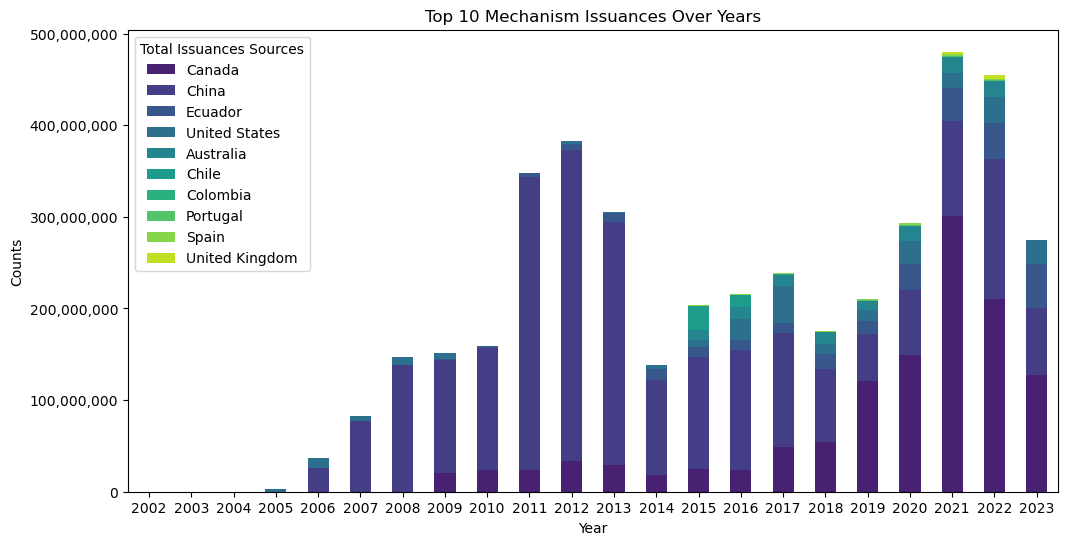

In [20]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

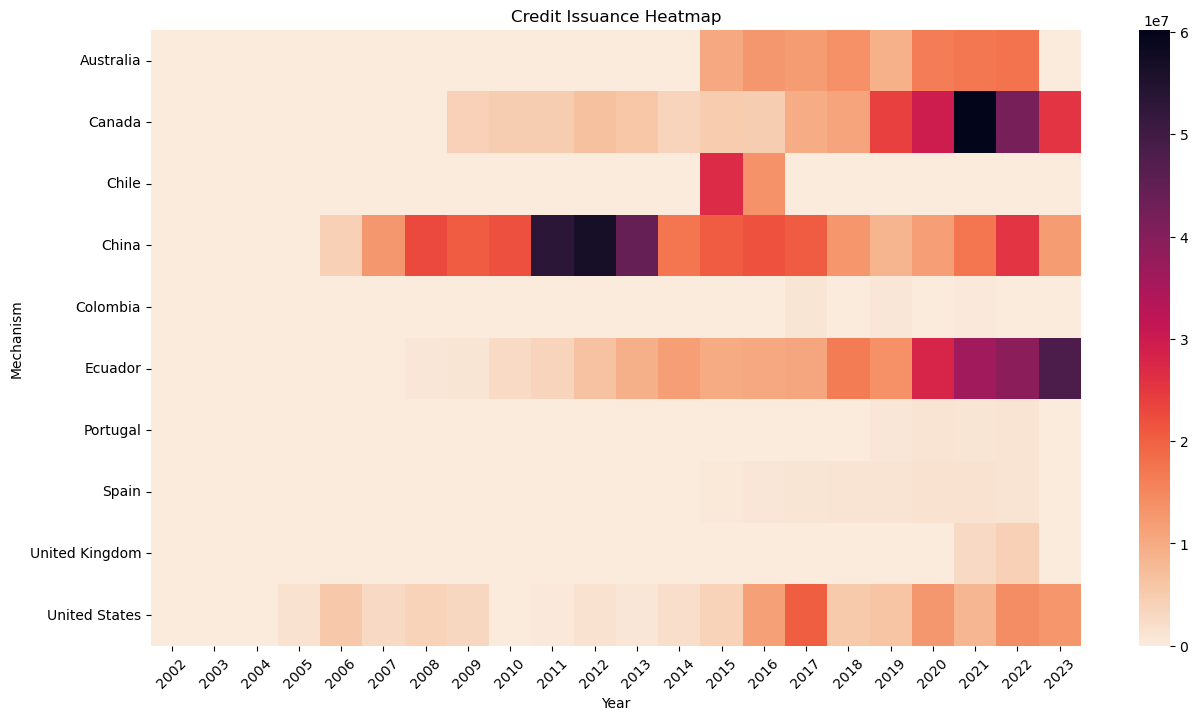

In [21]:
# 將數據按照年份和機制進行重塑，以便用於繪製熱度圖

heatmap_data = ts_top.pivot_table(index='country', columns='Year', values='value')

plt.figure(figsize=(15, 8))

# 繪製熱度圖，設置顏色的透明度
sns.heatmap(heatmap_data, cmap='rocket_r')

# 添加標題和標籤
plt.title('Credit Issuance Heatmap')
plt.xlabel('Year')
plt.ylabel('Mechanism')
plt.xticks(rotation=45)

plt.show()

<Figure size 1200x600 with 0 Axes>

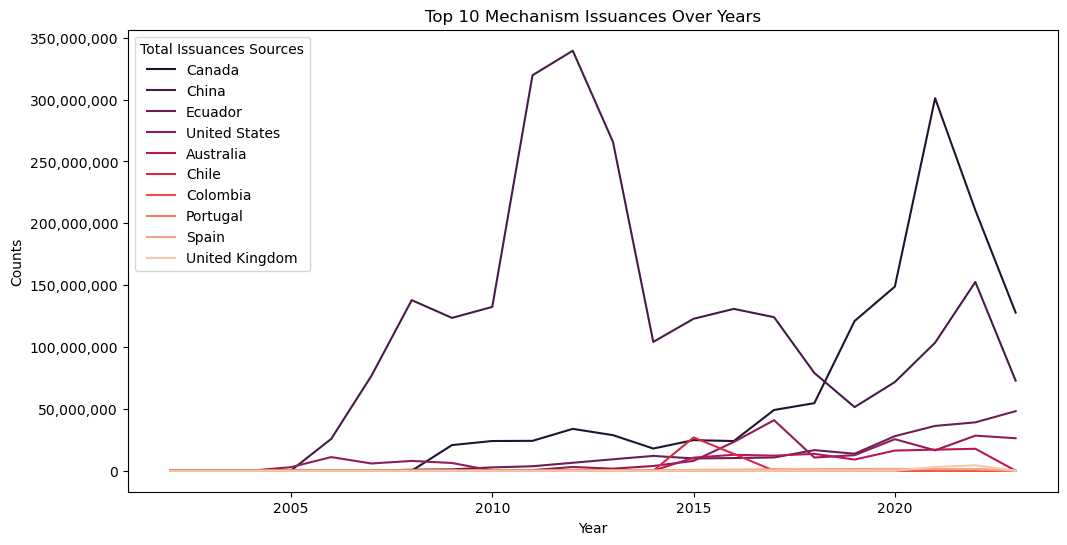

In [22]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='line', figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

### 用單一機制看成長

In [23]:
ts_total_value = ts.groupby('Mechanism')['value'].sum()
ts_top_10 = ts_total_value.sort_values(ascending=False).head(10)

ts_top_10

Mechanism
Clean Development Mechanism                        2.423390e+09
Verified Carbon Standard                           1.150597e+09
Joint Implementation                               8.718936e+08
Gold Standard                                      2.485544e+08
American Carbon Registry                           2.351242e+08
Climate Action Reserve                             1.967739e+08
Australian Carbon Credit Unit Scheme               1.094211e+08
China GHG Voluntary Emission Reduction Program     4.050900e+07
Alberta Emission Offset System                     3.720800e+07
Saitama Target Setting Emissions Trading System    1.430000e+07
Name: value, dtype: float64

In [24]:
ts_top = ts[ts['Mechanism'].isin(['Clean Development Mechanism', 'Verified Carbon Standard',  'Joint Implementation',
                                  'Gold Standard', 'American Carbon Registry', 'Climate Action Reserve', 'Australian Carbon Credit Unit Scheme',
                                  'China GHG Voluntary Emission Reduction Program', 'Alberta Emission Offset System', 'Saitama Target Setting Emissions Trading System'])]
    
ts_top

country                                        Mechanism  Year  \
0           Canada                   Alberta Emission Offset System  2002   
1    United States                         American Carbon Registry  2002   
2        Australia             Australian Carbon Credit Unit Scheme  2002   
8            Chile   China GHG Voluntary Emission Reduction Program  2002   
10           China                      Clean Development Mechanism  2002   
..             ...                                              ...   ...   
767           None                           Climate Action Reserve  2023   
770        Ecuador                                    Gold Standard  2023   
774           None                             Joint Implementation  2023   
781           None  Saitama Target Setting Emissions Trading System  2023   
791         Canada                         Verified Carbon Standard  2023   

           value  
0            0.0  
1       125000.0  
2            0.0  
8            0.0  
10           0.0  
..           ...  
767   11757148.0  
770   48157031.0  
774          0.0  
781          0.0  
791  127836684.0  

[220 rows x 4 columns]

In [25]:
# 使用pivot將數據轉換乘寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Mechanism', values='value', aggfunc='sum').fillna(0)
pivot_ts

Mechanism  Alberta Emission Offset System  American Carbon Registry  \
Year                                                                  
2002                                  0.0                  125000.0   
2003                                  0.0                       0.0   
2004                                  0.0                     500.0   
2005                                  0.0                 2880358.0   
2006                                  0.0                11027146.0   
2007                                  0.0                 5847510.0   
2008                                  0.0                 7938812.0   
2009                                  0.0                 6245281.0   
2010                                  0.0                  171069.0   
2011                                  0.0                  519754.0   
2012                                  0.0                 3012027.0   
2013                                  0.0                 1676242.0   
2014                                  0.0                 3824014.0   
2015                            4011000.0                 7945382.0   
2016                            4463000.0                23223141.0   
2017                            5057000.0                40855175.0   
2018                            4866000.0                10652351.0   
2019                            3618000.0                12565173.0   
2020                            8400000.0                25485209.0   
2021                             393000.0                16488987.0   
2022                            6400000.0                28368453.0   
2023                                  0.0                26272571.0   

Mechanism  Australian Carbon Credit Unit Scheme  \
Year                                              
2002                                        0.0   
2003                                        0.0   
2004                                        0.0   
2005                                        0.0   
2006                                        0.0   
2007                                        0.0   
2008                                        0.0   
2009                                        0.0   
2010                                        0.0   
2011                                        0.0   
2012                                        0.0   
2013                                        0.0   
2014                                        0.0   
2015                                 10578000.0   
2016                                 12894000.0   
2017                                 12191000.0   
2018                                 13660000.0   
2019                                  9020000.0   
2020                                 16300000.0   
2021                                 17040000.0   
2022                                 17738059.0   
2023                                        0.0   

Mechanism  China GHG Voluntary Emission Reduction Program  \
Year                                                        
2002                                                  0.0   
2003                                                  0.0   
2004                                                  0.0   
2005                                                  0.0   
2006                                                  0.0   
2007                                                  0.0   
2008                                                  0.0   
2009                                                  0.0   
2010                                                  0.0   
2011                                                  0.0   
2012                                                  0.0   
2013                                                  0.0   
2014                                                  0.0   
2015                                           26905000.0   
2016                                           13604000.0   
2017                             

In [26]:
# 取2023年的排序
data_2023 = pivot_ts.loc[2023]

# 獲得2023年數據排序
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Mechanism  Verified Carbon Standard  Clean Development Mechanism  \
Year                                                               
2002                            0.0                          0.0   
2003                            0.0                          0.0   
2004                            0.0                          0.0   
2005                            0.0                     103732.0   
2006                            0.0                   25688774.0   
2007                            0.0                   76688338.0   
2008                            0.0                  137874364.0   
2009                     20731991.0                  123427031.0   
2010                     24014316.0                  132396048.0   
2011                     24153406.0                  319516481.0   
2012                     33844512.0                  339393698.0   
2013                     28742372.0                  265350749.0   
2014                     17939993.0                  103956913.0   
2015                     18883791.0                  122563467.0   
2016                     18049382.0                  130442400.0   
2017                     43153129.0                  123832242.0   
2018                     49494001.0                   78732685.0   
2019                    117418734.0                   50995101.0   
2020                    138858883.0                   70930939.0   
2021                    288336841.0                  101017026.0   
2022                    199138942.0                  150463412.0   
2023                    127836684.0                   70016275.0   

Mechanism  Gold Standard  American Carbon Registry  Climate Action Reserve  \
Year                                                                         
2002                 0.0                  125000.0                     0.0   
2003                 0.0                       0.0                     0.0   
2004                 0.0                     500.0                     0.0   
2005                 0.0                 2880358.0                     0.0   
2006                 0.0                11027146.0                     0.0   
2007                 0.0                 5847510.0                     0.0   
2008            819181.0                 7938812.0                426862.0   
2009           1096855.0                 6245281.0               1895410.0   
2010           2678915.0                  171069.0               7890136.0   
2011           3599785.0                  519754.0               9765382.0   
2012           6441069.0                 3012027.0              10734499.0   
2013           9244855.0                 1676242.0              12875064.0   
2014          11976513.0                 3824014.0              13101763.0   
2015           9922232.0                 7945382.0              16461305.0   
2016          10235206.0                23223141.0              13591251.0   
2017          10737598.0                40855175.0              16026345.0   
2018          16649816.0                10652351.0              18886550.0   
2019          13727240.0                12565173.0              18887796.0   
2020          27943126.0                25485209.0              19209838.0   
2021          36226671.0                16488987.0               9928909.0   
2022          39098294.0                28368453.0              15335659.0   
2023          48157031.0                26272571.0              11757148.0   

Mechanism  Alberta Emission Offset System  \
Year                                        
2002                                  0.0   
2003                                  0.0   
2004                                  0.0   
2005                                  0.0   
2006                                  0.0   
2007                                  0.0   
2008                                  0.0   
2009                                  0.0   
2010                                  0.0   

### 以下是關於credit的發行狀況，在2023年一共發行了兩億八千多萬（284,039,709）張

<Figure size 1200x600 with 0 Axes>

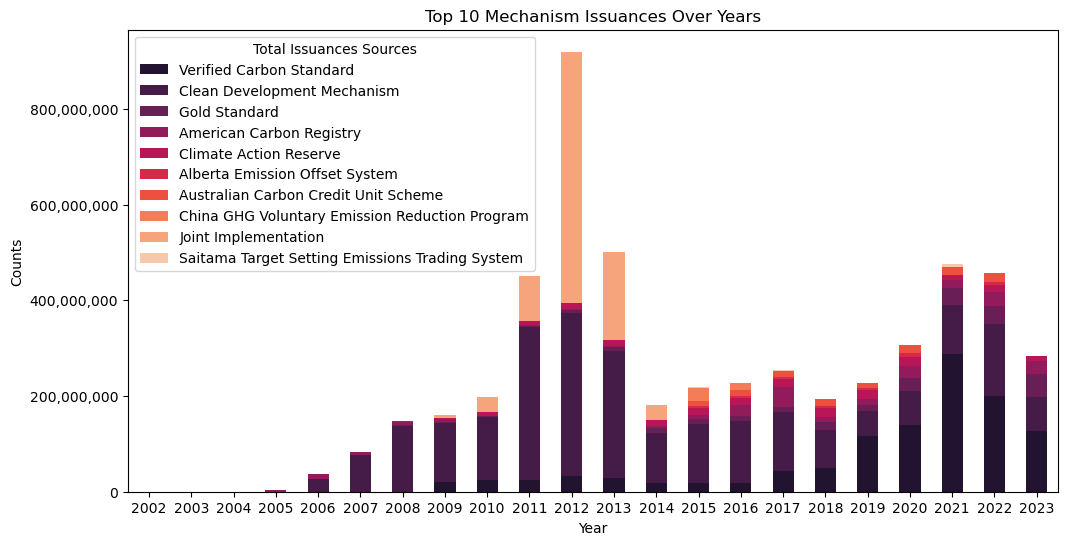

In [27]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

In [28]:
# 使用pivot將數據轉換乘寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Mechanism', values='value', aggfunc='sum').fillna(0)
pivot_ts

Mechanism  Alberta Emission Offset System  American Carbon Registry  \
Year                                                                  
2002                                  0.0                  125000.0   
2003                                  0.0                       0.0   
2004                                  0.0                     500.0   
2005                                  0.0                 2880358.0   
2006                                  0.0                11027146.0   
2007                                  0.0                 5847510.0   
2008                                  0.0                 7938812.0   
2009                                  0.0                 6245281.0   
2010                                  0.0                  171069.0   
2011                                  0.0                  519754.0   
2012                                  0.0                 3012027.0   
2013                                  0.0                 1676242.0   
2014                                  0.0                 3824014.0   
2015                            4011000.0                 7945382.0   
2016                            4463000.0                23223141.0   
2017                            5057000.0                40855175.0   
2018                            4866000.0                10652351.0   
2019                            3618000.0                12565173.0   
2020                            8400000.0                25485209.0   
2021                             393000.0                16488987.0   
2022                            6400000.0                28368453.0   
2023                                  0.0                26272571.0   

Mechanism  Australian Carbon Credit Unit Scheme  \
Year                                              
2002                                        0.0   
2003                                        0.0   
2004                                        0.0   
2005                                        0.0   
2006                                        0.0   
2007                                        0.0   
2008                                        0.0   
2009                                        0.0   
2010                                        0.0   
2011                                        0.0   
2012                                        0.0   
2013                                        0.0   
2014                                        0.0   
2015                                 10578000.0   
2016                                 12894000.0   
2017                                 12191000.0   
2018                                 13660000.0   
2019                                  9020000.0   
2020                                 16300000.0   
2021                                 17040000.0   
2022                                 17738059.0   
2023                                        0.0   

Mechanism  China GHG Voluntary Emission Reduction Program  \
Year                                                        
2002                                                  0.0   
2003                                                  0.0   
2004                                                  0.0   
2005                                                  0.0   
2006                                                  0.0   
2007                                                  0.0   
2008                                                  0.0   
2009                                                  0.0   
2010                                                  0.0   
2011                                                  0.0   
2012                                                  0.0   
2013                                                  0.0   
2014                                                  0.0   
2015                                           26905000.0   
2016                                           13604000.0   
2017                             

In [29]:
# 取2023年的排序
data_2023 = pivot_ts.loc[2023]

# 獲得2023年數據排序
sorted_columns = data_2023.sort_values(ascending=False).index

# 重新排列DataFrame的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Mechanism  Verified Carbon Standard  Clean Development Mechanism  \
Year                                                               
2002                            0.0                          0.0   
2003                            0.0                          0.0   
2004                            0.0                          0.0   
2005                            0.0                     103732.0   
2006                            0.0                   25688774.0   
2007                            0.0                   76688338.0   
2008                            0.0                  137874364.0   
2009                     20731991.0                  123427031.0   
2010                     24014316.0                  132396048.0   
2011                     24153406.0                  319516481.0   
2012                     33844512.0                  339393698.0   
2013                     28742372.0                  265350749.0   
2014                     17939993.0                  103956913.0   
2015                     18883791.0                  122563467.0   
2016                     18049382.0                  130442400.0   
2017                     43153129.0                  123832242.0   
2018                     49494001.0                   78732685.0   
2019                    117418734.0                   50995101.0   
2020                    138858883.0                   70930939.0   
2021                    288336841.0                  101017026.0   
2022                    199138942.0                  150463412.0   
2023                    127836684.0                   70016275.0   

Mechanism  Gold Standard  American Carbon Registry  Climate Action Reserve  \
Year                                                                         
2002                 0.0                  125000.0                     0.0   
2003                 0.0                       0.0                     0.0   
2004                 0.0                     500.0                     0.0   
2005                 0.0                 2880358.0                     0.0   
2006                 0.0                11027146.0                     0.0   
2007                 0.0                 5847510.0                     0.0   
2008            819181.0                 7938812.0                426862.0   
2009           1096855.0                 6245281.0               1895410.0   
2010           2678915.0                  171069.0               7890136.0   
2011           3599785.0                  519754.0               9765382.0   
2012           6441069.0                 3012027.0              10734499.0   
2013           9244855.0                 1676242.0              12875064.0   
2014          11976513.0                 3824014.0              13101763.0   
2015           9922232.0                 7945382.0              16461305.0   
2016          10235206.0                23223141.0              13591251.0   
2017          10737598.0                40855175.0              16026345.0   
2018          16649816.0                10652351.0              18886550.0   
2019          13727240.0                12565173.0              18887796.0   
2020          27943126.0                25485209.0              19209838.0   
2021          36226671.0                16488987.0               9928909.0   
2022          39098294.0                28368453.0              15335659.0   
2023          48157031.0                26272571.0              11757148.0   

Mechanism  Alberta Emission Offset System  \
Year                                        
2002                                  0.0   
2003                                  0.0   
2004                                  0.0   
2005                                  0.0   
2006                                  0.0   
2007                                  0.0   
2008                                  0.0   
2009                                  0.0   
2010                                  0.0   

### 以下是關於credit的發行狀況，在2023年一共發行了兩億八千多萬（284,039,709）張

<Figure size 1200x600 with 0 Axes>

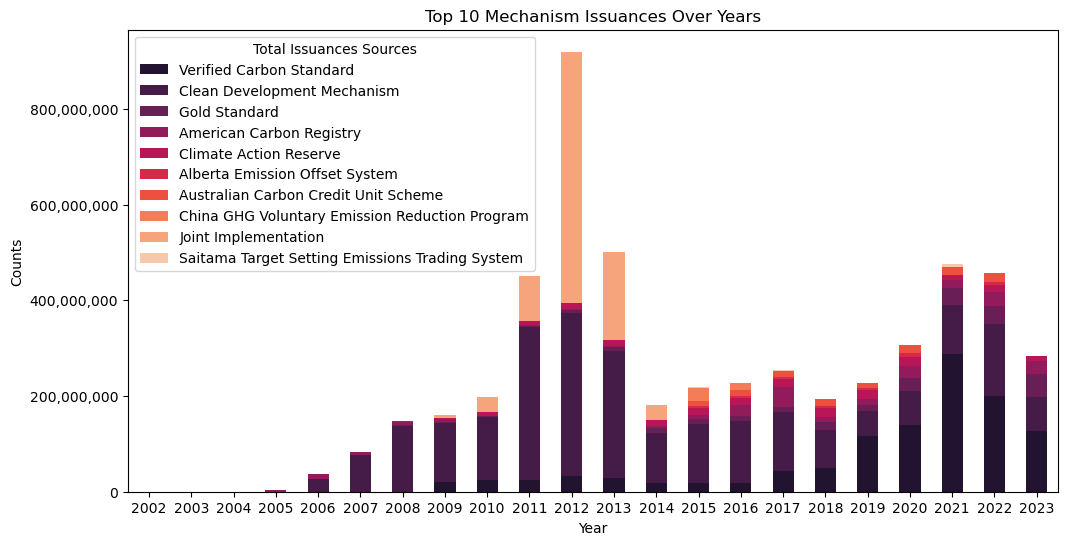

In [30]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

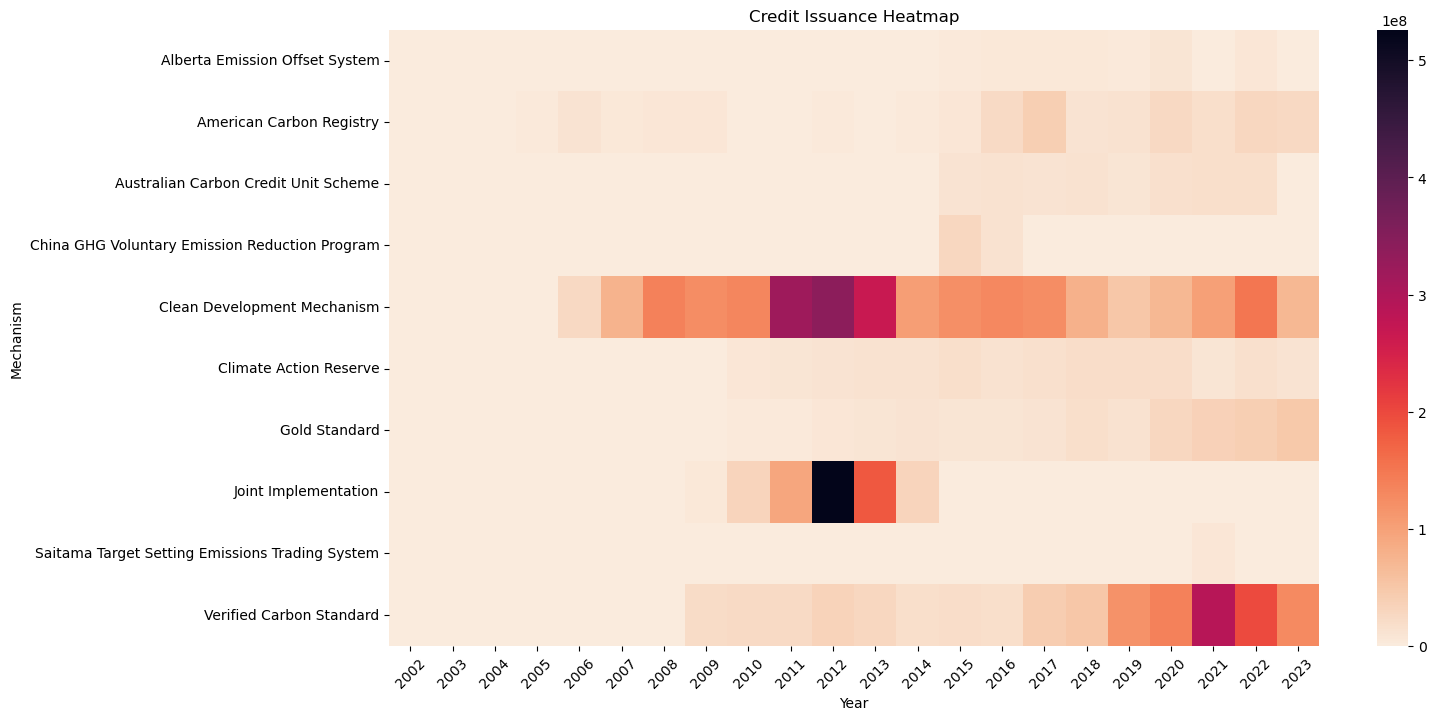

In [31]:
# 將數據按照年份和機制進行重塑，以便用於繪製熱度圖

heatmap_data = ts_top.pivot_table(index='Mechanism', columns='Year', values='value')

plt.figure(figsize=(15, 8))

# 繪製熱度圖，設置顏色的透明度
sns.heatmap(heatmap_data, cmap='rocket_r')

# 添加標題和標籤
plt.title('Credit Issuance Heatmap')
plt.xlabel('Year')
plt.ylabel('Mechanism')
plt.xticks(rotation=45)

plt.show()

<Figure size 1200x600 with 0 Axes>

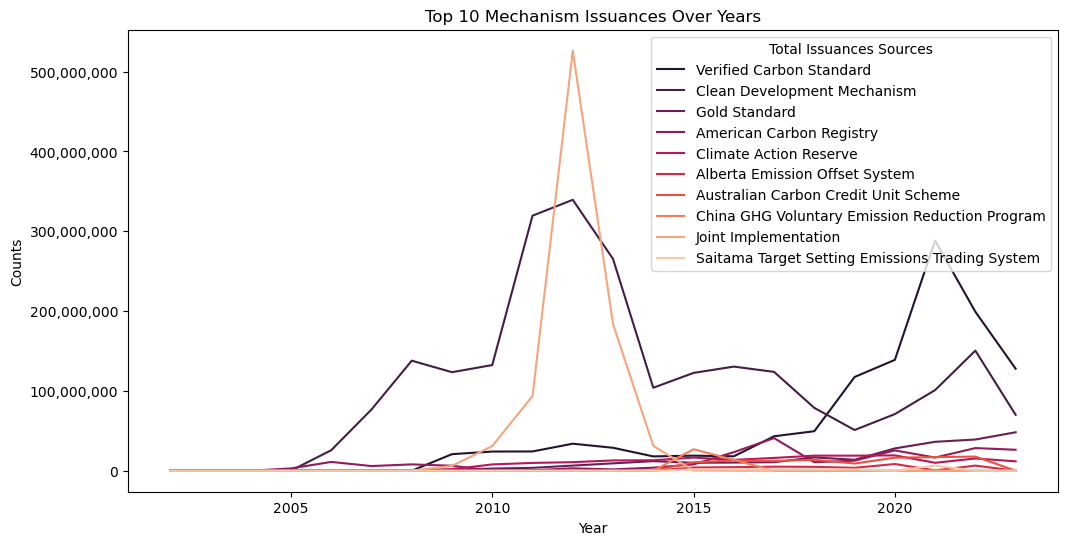

In [32]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('rocket', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='line', figsize=(12, 6), color=colors)

plt.title('Top 10 Mechanism Issuances Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Total Issuances Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

## 中國crediting市場

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
import config
import folium
import json
import urllib

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'root',
    'database': 'carbon',
    'unix_socket': '/Applications/MAMP/tmp/mysql/mysql.sock'
}
# Build MySQL connection
conn = mysql.connector.connect(**config)

if conn.is_connected():
    print("Connection successful!")
else:
    print("Connection failed!")

Connection successful!


In [2]:
sql_query = """
SELECT * FROM `Crediting_Issuance`
"""

In [3]:
df = pd.read_sql(sql_query, conn)
df

/var/folders/hg/3k68k_3x3rx9xqnpbl5zcjv00000gn/T/ipykernel_69564/1382583293.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql_query, conn)


Mechanism       2002      2003  \
0                     Alberta Emission Offset System       -         -      
1                           American Carbon Registry   125,000       -      
2               Australian Carbon Credit Unit Scheme       -         -      
3                  Beijing Forestry Offset Mechanism       -         -      
4         Beijing Parking Offset Crediting Mechanism       -         -      
5                    British Columbia Offset Program       -         -      
6               California Compliance Offset Program       -         -      
7                          Chile Crediting Mechanism       -         -      
8     China GHG Voluntary Emission Reduction Program       -         -      
9                  Chongqing carbon offset mechanism       -         -      
10                       Clean Development Mechanism       -         -      
11                            Climate Action Reserve       -         -      
12                      Colombia Crediting Mechanism       -         -      
13        Fujian Forestry Offset Crediting Mechanism       -         -      
14                                     Gold Standard       -         -      
15       Guangdong Pu Hui Offset Crediting Mechanism       -         -      
16                                   J-Credit Scheme       -         -      
17                         Joint Crediting Mechanism       -         -      
18                              Joint Implementation       -         -      
19                    Kazakhstan Crediting Mechanism       -         -      
20                                         Plan Vivo    46,679    48,755    
21                 Quebec Offset Crediting Mechanism       -         -      
22         Republic of Korea Offset Credit Mechanism       -         -      
23                         RGGI CO2 Offset Mechanism       -         -      
24    Saitama Forest Absorption Certification System       -         -      
25   Saitama Target Setting Emissions Trading System       -         -      
26         Sakhalin Oblast Pilot crediting mechanism       -         -      
27                  South Africa Crediting Mechanism       -         -      
28                             Spain FES-CO2 Program       -         -      
29              Sri Lanka Carbon Crediting Mechanism       -         -      
30  Switzerland CO2 Attestations Crediting Mechanism       -         -      
31              Taiwan GHG Offset Management Program       -         -      
32     Thailand Voluntary Emission Reduction Program       -         -      
33                       Tokyo Cap-and-Trade Program       -         -      
34                           UK Woodland Carbon Code       -         -      
35                          Verified Carbon Standard       -         -      

        2004         2005          2006          2007           2008  \
0       -            -             -             -              -      
1       500    2,880,358    11,027,146     5,847,510      7,938,812    
2       -            -             -             -              -      
3       -            -             -             -              -      
4       -            -             -             -              -      
5       -            -             -             -              -      
6       -            -             -             -              -      
7       -            -             -             -              -      
8       -            -             -             -              -      
9       -            -             -             -              -      
10      -        103,732    25,688,774    76,688,338    137,874,364    
11      -            -             -             -          426,862    
12      -            -             -             -              -      
13      -            -             -             -              -      
14      -            -             -             -          819,181    
15      -            -             -     

In [4]:
china_mechanism = [
    'Beijing Forestry Offset Mechanism',
    'Beijing Parking Offset Crediting Mechanism',
#     'China GHG Voluntary Emission Reduction Program', 數值太大導致其他不明顯
    'Chongqing carbon offset mechanism',
    'Fujian Forestry Offset Crediting Mechanism',
    'Guangdong Pu Hui Offset Crediting Mechanism'
]

# Filter the DataFrame
china_df = df[df['Mechanism'].isin(china_mechanism)]

china_df

Mechanism   2002   2003   2004   2005  \
3             Beijing Forestry Offset Mechanism   -      -      -      -      
4    Beijing Parking Offset Crediting Mechanism   -      -      -      -      
9             Chongqing carbon offset mechanism   -      -      -      -      
13   Fujian Forestry Offset Crediting Mechanism   -      -      -      -      
15  Guangdong Pu Hui Offset Crediting Mechanism   -      -      -      -      

     2006   2007   2008   2009   2010  ...   2014      2015      2016  \
3    -      -      -      -      -     ...   -      45,000    45,000    
4    -      -      -      -      -     ...   -         -         -      
9    -      -      -      -      -     ...   -         -         -      
13   -      -      -      -      -     ...   -         -         -      
15   -      -      -      -      -     ...   -         -         -      

           2017       2018       2019       2020         2021       2022  \
3          -          -          -          -            -          -      
4          -          -          -          -          2,128        -      
9          -          -          -          -      1,200,000    350,000    
13   1,073,000        -      767,000    160,000      330,000        -      
15     242,000    605,000    210,000    600,000      278,000        -      

     2023  
3    -     
4    -     
9    -     
13   -     
15   -     

[5 rows x 23 columns]

In [5]:
# transpose year
ts_china = china_df.melt(id_vars=['Mechanism'], var_name='Year')
ts_china

Mechanism  Year  value
0              Beijing Forestry Offset Mechanism  2002   -   
1     Beijing Parking Offset Crediting Mechanism  2002   -   
2              Chongqing carbon offset mechanism  2002   -   
3     Fujian Forestry Offset Crediting Mechanism  2002   -   
4    Guangdong Pu Hui Offset Crediting Mechanism  2002   -   
..                                           ...   ...    ...
105            Beijing Forestry Offset Mechanism  2023   -   
106   Beijing Parking Offset Crediting Mechanism  2023   -   
107            Chongqing carbon offset mechanism  2023   -   
108   Fujian Forestry Offset Crediting Mechanism  2023   -   
109  Guangdong Pu Hui Offset Crediting Mechanism  2023   -   

[110 rows x 3 columns]

In [6]:
ts_china['Year'] = pd.to_datetime(ts_china['Year'], format='%Y')
ts_china

Mechanism       Year  value
0              Beijing Forestry Offset Mechanism 2002-01-01   -   
1     Beijing Parking Offset Crediting Mechanism 2002-01-01   -   
2              Chongqing carbon offset mechanism 2002-01-01   -   
3     Fujian Forestry Offset Crediting Mechanism 2002-01-01   -   
4    Guangdong Pu Hui Offset Crediting Mechanism 2002-01-01   -   
..                                           ...        ...    ...
105            Beijing Forestry Offset Mechanism 2023-01-01   -   
106   Beijing Parking Offset Crediting Mechanism 2023-01-01   -   
107            Chongqing carbon offset mechanism 2023-01-01   -   
108   Fujian Forestry Offset Crediting Mechanism 2023-01-01   -   
109  Guangdong Pu Hui Offset Crediting Mechanism 2023-01-01   -   

[110 rows x 3 columns]

In [7]:
ts_china['value'] = ts_china['value'].str.replace(',', '')
ts_china['value'] = pd.to_numeric(ts_china['value'], errors='coerce')
# ts.dropna(subset=['value'], inplace=True)
ts_china

Mechanism       Year  value
0              Beijing Forestry Offset Mechanism 2002-01-01    NaN
1     Beijing Parking Offset Crediting Mechanism 2002-01-01    NaN
2              Chongqing carbon offset mechanism 2002-01-01    NaN
3     Fujian Forestry Offset Crediting Mechanism 2002-01-01    NaN
4    Guangdong Pu Hui Offset Crediting Mechanism 2002-01-01    NaN
..                                           ...        ...    ...
105            Beijing Forestry Offset Mechanism 2023-01-01    NaN
106   Beijing Parking Offset Crediting Mechanism 2023-01-01    NaN
107            Chongqing carbon offset mechanism 2023-01-01    NaN
108   Fujian Forestry Offset Crediting Mechanism 2023-01-01    NaN
109  Guangdong Pu Hui Offset Crediting Mechanism 2023-01-01    NaN

[110 rows x 3 columns]

In [8]:
ts_china['value'].fillna(0, inplace=True)
ts_china

Mechanism       Year  value
0              Beijing Forestry Offset Mechanism 2002-01-01    0.0
1     Beijing Parking Offset Crediting Mechanism 2002-01-01    0.0
2              Chongqing carbon offset mechanism 2002-01-01    0.0
3     Fujian Forestry Offset Crediting Mechanism 2002-01-01    0.0
4    Guangdong Pu Hui Offset Crediting Mechanism 2002-01-01    0.0
..                                           ...        ...    ...
105            Beijing Forestry Offset Mechanism 2023-01-01    0.0
106   Beijing Parking Offset Crediting Mechanism 2023-01-01    0.0
107            Chongqing carbon offset mechanism 2023-01-01    0.0
108   Fujian Forestry Offset Crediting Mechanism 2023-01-01    0.0
109  Guangdong Pu Hui Offset Crediting Mechanism 2023-01-01    0.0

[110 rows x 3 columns]

In [9]:
ts_china['value'] = pd.to_numeric(ts_china['value'], errors='coerce')
ts_china['Year'] = ts_china['Year'].dt.year

ts_china

Mechanism  Year  value
0              Beijing Forestry Offset Mechanism  2002    0.0
1     Beijing Parking Offset Crediting Mechanism  2002    0.0
2              Chongqing carbon offset mechanism  2002    0.0
3     Fujian Forestry Offset Crediting Mechanism  2002    0.0
4    Guangdong Pu Hui Offset Crediting Mechanism  2002    0.0
..                                           ...   ...    ...
105            Beijing Forestry Offset Mechanism  2023    0.0
106   Beijing Parking Offset Crediting Mechanism  2023    0.0
107            Chongqing carbon offset mechanism  2023    0.0
108   Fujian Forestry Offset Crediting Mechanism  2023    0.0
109  Guangdong Pu Hui Offset Crediting Mechanism  2023    0.0

[110 rows x 3 columns]

In [10]:
pivot = ts_china.pivot_table(index='Year', columns='Mechanism', values='value', aggfunc='sum').fillna(0)

pivot

Mechanism  Beijing Forestry Offset Mechanism  \
Year                                           
2002                                     0.0   
2003                                     0.0   
2004                                     0.0   
2005                                     0.0   
2006                                     0.0   
2007                                     0.0   
2008                                     0.0   
2009                                     0.0   
2010                                     0.0   
2011                                     0.0   
2012                                     0.0   
2013                                     0.0   
2014                                     0.0   
2015                                 45000.0   
2016                                 45000.0   
2017                                     0.0   
2018                                     0.0   
2019                                     0.0   
2020                                     0.0   
2021                                     0.0   
2022                                     0.0   
2023                                     0.0   

Mechanism  Beijing Parking Offset Crediting Mechanism  \
Year                                                    
2002                                              0.0   
2003                                              0.0   
2004                                              0.0   
2005                                              0.0   
2006                                              0.0   
2007                                              0.0   
2008                                              0.0   
2009                                              0.0   
2010                                              0.0   
2011                                              0.0   
2012                                              0.0   
2013                                              0.0   
2014                                              0.0   
2015                                              0.0   
2016                                              0.0   
2017                                              0.0   
2018                                              0.0   
2019                                              0.0   
2020                                              0.0   
2021                                           2128.0   
2022                                              0.0   
2023                                              0.0   

Mechanism  Chongqing carbon offset mechanism  \
Year                                           
2002                                     0.0   
2003                                     0.0   
2004                                     0.0   
2005                                     0.0   
2006                                     0.0   
2007                                     0.0   
2008                                     0.0   
2009                                     0.0   
2010                                     0.0   
2011                                     0.0   
2012                                     0.0   
2013                                     0.0   
2014                                     0.0   
2015                                     0.0   
2016                                     0.0   
2017                                     0.0   
2018                                     0.0   
2019                                     0.0   
2020                                     0.0   
2021                               1200000.0   
2022                                350000.0   
2023                                     0.0   

Mechanism  Fujian Forestry Offset Crediting Mechanism  \
Year                                                    
2002                                              0.0   
2003                                              0.0   
2004                                              0.0   
2005                                    

<Figure size 1200x600 with 0 Axes>

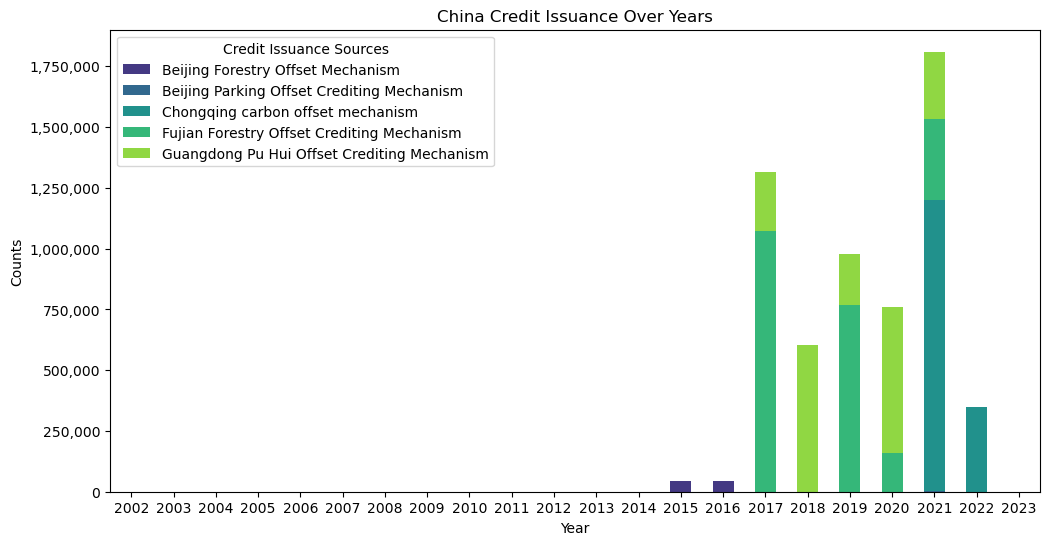

In [11]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(pivot.columns))

ax = pivot.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('China Credit Issuance Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Credit Issuance Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

<Figure size 1200x600 with 0 Axes>

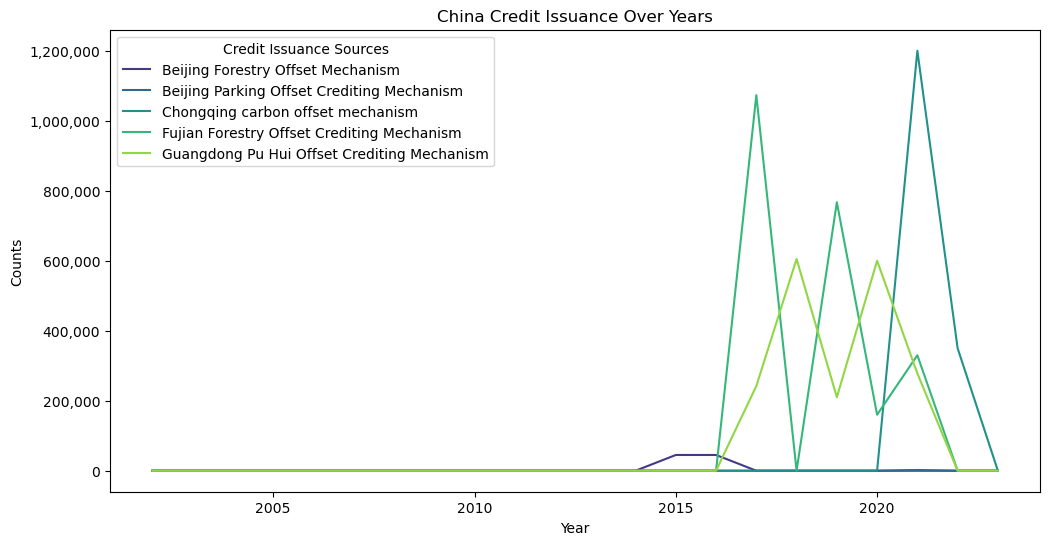

In [12]:
plt.figure(figsize=(12, 6))

colors = sns.color_palette('viridis', len(pivot.columns))

ax = pivot.plot(kind='line', figsize=(12, 6), color=colors)

plt.title('China Credit Issuance Over Years')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Credit Issuance Sources')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

---

## 台灣綠電憑證市場

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mysql.connector
import config
import folium
import json
import urllib
import urllib.request
import matplotlib.colors as mcolors
import branca.colormap as cm


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
columns = ['Source', 'Buyer', 'C_Type', 'E_Type', 'num']

df = pd.read_csv('certificate_supply.csv', usecols=columns)
df

Source           Buyer C_Type E_Type    num
0                 中威風力發電股份有限公司\n(台中風場)  台灣積體電路製造股份有限公司    風力能     轉供  61501
1    中租電力科技股份有限公司\n(帝寶工業新營廠房屋頂太陽光電發電廠)      中租迪和股份有限公司    太陽能     轉供    270
2      中鋼光能股份有限公司\n(中鋼成品倉庫07庫&條線工場08庫)      中國鋼鐵股份有限公司    太陽能  併網型直供    871
3          中鋼光能股份有限公司\n(中鋼鋼板工場#02#03庫)      中國鋼鐵股份有限公司    太陽能  併網型直供    632
4          中鋼光能股份有限公司\n(中鋼#09~#11條鋼工廠)      中國鋼鐵股份有限公司    太陽能  併網型直供    457
..                                 ...             ...    ...    ...    ...
736            鹿威風力發電股份有限公司\n(鹿威-鹿港風場)  台灣積體電路製造股份有限公司    風力能     轉供  43073
737             鹿威風力發電股份有限公司\n(鹿港風場二期)  台灣積體電路製造股份有限公司    風力能     轉供   6610
738              龍威風力發電股份有限公司\n(龍威風場一)  台灣積體電路製造股份有限公司    風力能     轉供  30164
739              龍威風力發電股份有限公司\n(龍威風場二)  台灣積體電路製造股份有限公司    風力能     轉供   3784
740              龍威風力發電股份有限公司\n(龍威風場三)  台灣積體電路製造股份有限公司    風力能     轉供   2581

[741 rows x 5 columns]

In [3]:
df[['Suppler', 'Source']] = df['Source'].str.split('\n', expand=True)

df

Source           Buyer C_Type E_Type    num       Suppler
0                 (台中風場)  台灣積體電路製造股份有限公司    風力能     轉供  61501  中威風力發電股份有限公司
1    (帝寶工業新營廠房屋頂太陽光電發電廠)      中租迪和股份有限公司    太陽能     轉供    270  中租電力科技股份有限公司
2    (中鋼成品倉庫07庫&條線工場08庫)      中國鋼鐵股份有限公司    太陽能  併網型直供    871    中鋼光能股份有限公司
3        (中鋼鋼板工場#02#03庫)      中國鋼鐵股份有限公司    太陽能  併網型直供    632    中鋼光能股份有限公司
4        (中鋼#09~#11條鋼工廠)      中國鋼鐵股份有限公司    太陽能  併網型直供    457    中鋼光能股份有限公司
..                   ...             ...    ...    ...    ...           ...
736            (鹿威-鹿港風場)  台灣積體電路製造股份有限公司    風力能     轉供  43073  鹿威風力發電股份有限公司
737             (鹿港風場二期)  台灣積體電路製造股份有限公司    風力能     轉供   6610  鹿威風力發電股份有限公司
738              (龍威風場一)  台灣積體電路製造股份有限公司    風力能     轉供  30164  龍威風力發電股份有限公司
739              (龍威風場二)  台灣積體電路製造股份有限公司    風力能     轉供   3784  龍威風力發電股份有限公司
740              (龍威風場三)  台灣積體電路製造股份有限公司    風力能     轉供   2581  龍威風力發電股份有限公司

[741 rows x 6 columns]

In [4]:
total_num_by_buyer = df.groupby('Buyer')['num'].sum()

total_sum = total_num_by_buyer.sum()
print(f'Total num by all buyers: {total_sum:,.0f}')

max_buyer = total_num_by_buyer.idxmax()
max_num = total_num_by_buyer.max()
print(f'Maximum num by a buyer: {max_buyer}, {max_num:,.0f}')

no_tsmc_num = total_sum - max_num
print(f'Total num without TSMC: {no_tsmc_num:,.0f}')

Total num by all buyers: 963,928
Maximum num by a buyer: 台灣積體電路製造股份有限公司, 557,160
Total num without TSMC: 406,768


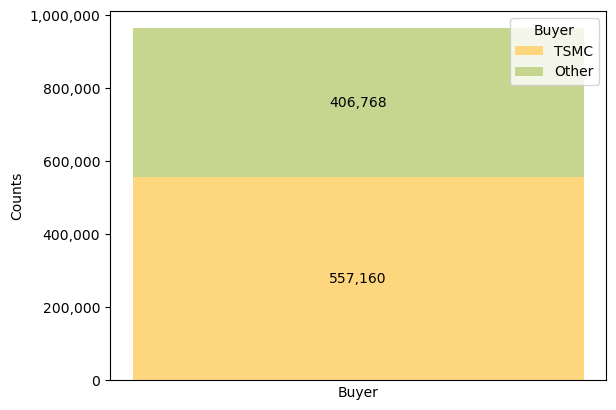

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Create the data
data = {'num': [557160, 406768], 'buyer': ['TSMC', 'Other']}
df_tsmc = pd.DataFrame(data)

# Plotting the stacked bar chart
fig, ax = plt.subplots()

# Define colors for the bars
colors = ['#FED67E', '#C6D68F']

# Plot the bars
bar_width = 0.3
bottom = 0

for num, buyer, color in zip(df_tsmc['num'], df_tsmc['buyer'], colors):
    ax.bar('Counts', num, bar_width, bottom=bottom, label=buyer, color=color)
    bottom += num

# Adding text labels with formatted numbers
bottom = 0
for num in df_tsmc['num']:
    ax.text('Counts', bottom + num / 2, f'{num:,}', ha='center', va='center')
    bottom += num

# Adding title and labels
ax.set_xlabel('Buyer')
ax.set_ylabel('Counts')

# Reorder the legend
ax.legend(title='Buyer', labels=['TSMC', 'Other'])

# Remove x-ticks and labels
ax.set_xticks([])
ax.set_xticklabels([])

# Function to format y-axis labels as real numbers
def format_func(value, tick_number):
    return f"{value:,.0f}"

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_func))

plt.show()

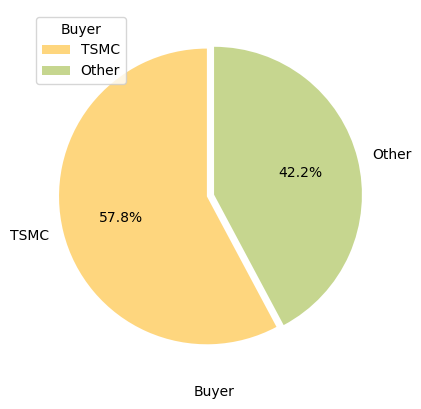

In [6]:
data = {'num': [557160, 406768], 'buyer': ['TSMC', 'Other']}
df_tsmc = pd.DataFrame(data)

# Define colors for the pie chart
colors = ['#FED67E', '#C6D68F']

# Define explode (offset) values
explode = [0.05 if buyer == 'TSMC' else 0 for buyer in df_tsmc['buyer']]

# Plot the pie chart
fig, ax = plt.subplots()
ax.pie(df_tsmc['num'], labels=df_tsmc['buyer'], colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)

# Adding title and labels
ax.set_xlabel('Buyer')
ax.set_ylabel('')

# Reorder the legend
ax.legend(title='Buyer', labels=['TSMC', 'Other'], loc='upper left')

plt.show()


In [7]:
# 按 'Buyer' 分組，計算每個 'Buyer' 的 'num' 總和
buyer_total_num = df.groupby('Buyer')['num'].sum()

top10_buyers = buyer_total_num.nlargest(10)
top10_buyers

Buyer
台灣積體電路製造股份有限公司       557160
台達電子工業股份有限公司          52502
友達光電股份有限公司            17330
聯華電子股份有限公司            16075
高雄晶傑達光電科技股份有限公司       15501
南亞科技股份有限公司            13657
中國鋼鐵股份有限公司            12342
中華電信股份有限公司資訊技術分公司     12191
東和鋼鐵企業股份有限公司          10388
采鈺科技股份有限公司             9857
Name: num, dtype: int64

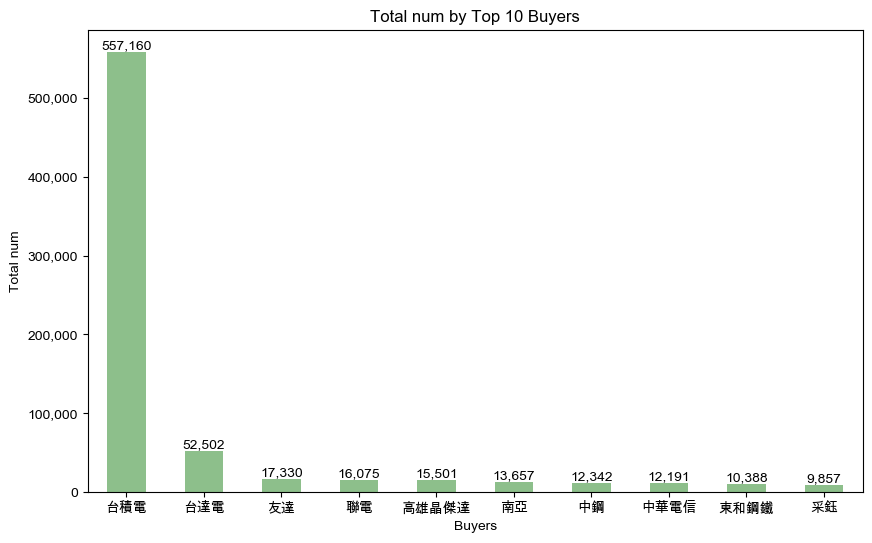

In [8]:
top10_buyers = top10_buyers.sort_values(ascending=False)

# 顯示中文
plt.rcParams['font.family'] = 'Arial Unicode MS'

top10_buyers.rename(index={'台灣積體電路製造股份有限公司': '台積電', '台達電子工業股份有限公司': '台達電', '友達光電股份有限公司': '友達', '聯華電子股份有限公司': '聯電', '高雄晶傑達光電科技股份有限公司': '高雄晶傑達',
                    '南亞科技股份有限公司': '南亞', '中國鋼鐵股份有限公司': '中鋼', '中華電信股份有限公司資訊技術分公司': '中華電信', '東和鋼鐵企業股份有限公司': '東和鋼鐵', '采鈺科技股份有限公司': '采鈺'}, inplace=True)


plt.figure(figsize=(10, 6))
ax = top10_buyers.plot(kind='bar', color=['#8dbf8b']) #, #3F7C88
plt.title('Total num by Top 10 Buyers')
plt.xlabel('Buyers')
plt.ylabel('Total num')
plt.xticks(rotation=0)

for i, v in enumerate(top10_buyers):
    ax.text(i, v + 0.1, f'{v:,.0f}', ha='center', va='bottom')

# format y-axis
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))


plt.show()

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import mysql.connector
import config
import folium
import json
import urllib
import urllib.request
import matplotlib.colors as mcolors
import branca.colormap as cm


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2024 = pd.read_csv('certificate_2024.csv', usecols=columns)
df_2024

Source  Year  Trans_num  Remaining_num
0                  中威風力發電股份有限公司\n台中風場  2024      17675          12777
1               鹿威風力發電股份有限公司\n鹿威-彰濱風場  2024      21329           1699
2                  創維風力發電股份有限公司\n創維風場  2024      33358              0
3               觀威風力發電股份有限公司\n觀音風力發電廠  2024      20601              0
4                台汽電綠能股份有限公司\n大鵬風力發電廠  2024      13440           3589
..                                ...   ...        ...            ...
716             台汽電綠能股份有限公司\n烏山頭水力發電廠  2024       5142              0
717  台灣化學纖維股份有限公司\n台灣化學纖維股份有限公司蘭潭管小水電  2024          0             84
718      農業部農村發展及水土保持署臺北分署\n崩山湖微水力發電站  2024          0              1
719           台灣綠氫股份有限公司\n台灣綠氫_餘氫再生系統  2024          0              0
720          盈松環保股份有限公司\n盈松熱電聯產氣化發電一廠  2024          0             23

[721 rows x 4 columns]

In [3]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2023 = pd.read_csv('certificate_2023.csv', usecols=columns)
df_2023

Source  Year  Trans_num  Remaining_num
0              中威風力發電股份有限公司\n台中風場  2023     135422              0
1           鹿威風力發電股份有限公司\n鹿威-彰濱風場  2023     104187              0
2              創維風力發電股份有限公司\n創維風場  2023      97827              0
3           觀威風力發電股份有限公司\n觀音風力發電廠  2023      86895              0
4            台汽電綠能股份有限公司\n大鵬風力發電廠  2023      76642              0
..                            ...   ...        ...            ...
658  花蓮綠能股份有限公司\n名間電力股份有限公司 水力發電廠  2023      41119              0
659           嘉南實業股份有限公司\n西口水力發電廠  2023      10298              0
660         台汽電綠能股份有限公司\n烏山頭水力發電廠  2023       5721              0
661       台灣綠氫股份有限公司\n台灣綠氫_餘氫再生系統  2023          0              2
662      盈松環保股份有限公司\n盈松熱電聯產氣化發電一廠  2023          0             72

[663 rows x 4 columns]

In [4]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2022 = pd.read_csv('certificate_2022.csv', usecols=columns)
df_2022

Source  Year  Trans_num  Remaining_num
0                  中威風力發電股份有限公司\n台中風場  2022     148674              0
1               鹿威風力發電股份有限公司\n鹿威-彰濱風場  2022     137923              0
2                  創維風力發電股份有限公司\n創維風場  2022      21094              0
3               觀威風力發電股份有限公司\n觀音風力發電廠  2022      54106              0
4                台汽電綠能股份有限公司\n大鵬風力發電廠  2022     107088              0
..                                ...   ...        ...            ...
327  台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部四林畜殖場  2022          0              0
328      花蓮綠能股份有限公司\n名間電力股份有限公司 水力發電廠  2022      16134              0
329               嘉南實業股份有限公司\n西口水力發電廠  2022        109              0
330             台汽電綠能股份有限公司\n烏山頭水力發電廠  2022      17886              0
331           台灣綠氫股份有限公司\n台灣綠氫_餘氫再生系統  2022         10              2

[332 rows x 4 columns]

In [5]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2021 = pd.read_csv('certificate_2021.csv', usecols=columns)
df_2021

Source  Year  Trans_num  Remaining_num
0                      中威風力發電股份有限公司\n台中風場  2021     130649              0
1                   鹿威風力發電股份有限公司\n鹿威-彰濱風場  2021     103463              0
2                    台汽電綠能股份有限公司\n大鵬風力發電廠  2021      84490              0
3                   鹿威風力發電股份有限公司\n鹿威-鹿港風場  2021      56382              0
4                     通威風力發電股份有限公司\n通威風場一  2021      41208              0
..                                    ...   ...        ...            ...
205  台灣電力股份有限公司第二核能發電廠\n台灣電力股份有限公司第二核能發電廠  2021          0              4
206              台灣大哥大股份有限公司\n台灣大哥大股份有限公司  2021          0              4
207            亞東工業氣體股份有限公司\n亞東工業氣體股份有限公司  2021          0              6
208   台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部大響營第一畜殖場  2021         27              1
209      台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部四林畜殖場  2021          0              0

[210 rows x 4 columns]

In [6]:
columns = ['Source', 'Year', 'Trans_num', 'Remaining_num']

df_2020 = pd.read_csv('certificate_2020.csv', usecols=columns)
df_2020

Source  Year  Trans_num  Remaining_num
0                      中威風力發電股份有限公司\n台中風場  2020      32396              0
1                   鹿威風力發電股份有限公司\n鹿威-彰濱風場  2020      33701              0
2                    台汽電綠能股份有限公司\n大鵬風力發電廠  2020      31210              0
3                   鹿威風力發電股份有限公司\n鹿威-鹿港風場  2020      20852              0
4                     通威風力發電股份有限公司\n通威風場一  2020      12130              0
..                                    ...   ...        ...            ...
162  台灣電力股份有限公司第二核能發電廠\n台灣電力股份有限公司第二核能發電廠  2020          0              4
163              台灣大哥大股份有限公司\n台灣大哥大股份有限公司  2020          0              6
164            亞東工業氣體股份有限公司\n亞東工業氣體股份有限公司  2020          0              6
165   台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部大響營第一畜殖場  2020         44              1
166      台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部四林畜殖場  2020         20              1

[167 rows x 4 columns]

In [7]:
dfs = [df_2024, df_2023, df_2022, df_2021, df_2020]

# Add 'Year' column to each dataframe
for i, df in enumerate(dfs):
    df['Year'] = 2024 - i

# Concatenate the dataframes
df_concat = pd.concat(dfs)
df_concat

Source  Year  Trans_num  Remaining_num
0                      中威風力發電股份有限公司\n台中風場  2024      17675          12777
1                   鹿威風力發電股份有限公司\n鹿威-彰濱風場  2024      21329           1699
2                      創維風力發電股份有限公司\n創維風場  2024      33358              0
3                   觀威風力發電股份有限公司\n觀音風力發電廠  2024      20601              0
4                    台汽電綠能股份有限公司\n大鵬風力發電廠  2024      13440           3589
..                                    ...   ...        ...            ...
162  台灣電力股份有限公司第二核能發電廠\n台灣電力股份有限公司第二核能發電廠  2020          0              4
163              台灣大哥大股份有限公司\n台灣大哥大股份有限公司  2020          0              6
164            亞東工業氣體股份有限公司\n亞東工業氣體股份有限公司  2020          0              6
165   台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部大響營第一畜殖場  2020         44              1
166      台灣糖業股份有限公司\n台灣糖業股份有限公司畜殖事業部四林畜殖場  2020         20              1

[2093 rows x 4 columns]

In [8]:
df_concat[['Supplier', 'Source']] = df_concat['Source'].str.split('\n', expand=True)
df_concat

Source  Year  Trans_num  Remaining_num  \
0                       台中風場  2024      17675          12777   
1                    鹿威-彰濱風場  2024      21329           1699   
2                       創維風場  2024      33358              0   
3                    觀音風力發電廠  2024      20601              0   
4                    大鵬風力發電廠  2024      13440           3589   
..                       ...   ...        ...            ...   
162        台灣電力股份有限公司第二核能發電廠  2020          0              4   
163              台灣大哥大股份有限公司  2020          0              6   
164             亞東工業氣體股份有限公司  2020          0              6   
165  台灣糖業股份有限公司畜殖事業部大響營第一畜殖場  2020         44              1   
166     台灣糖業股份有限公司畜殖事業部四林畜殖場  2020         20              1   

              Supplier  
0         中威風力發電股份有限公司  
1         鹿威風力發電股份有限公司  
2         創維風力發電股份有限公司  
3         觀威風力發電股份有限公司  
4          台汽電綠能股份有限公司  
..                 ...  
162  台灣電力股份有限公司第二核能發電廠  
163        台灣大哥大股份有限公司  
164       亞東工業氣體股份有限公司  
165         台灣糖業股份有限公司  
166         台灣糖業股份有限公司  

[2093 rows x 5 columns]

In [9]:
# Drop the 'Source' column
df_concat.drop(columns=['Source'], inplace=True)

# Sum 'Trans_num' and 'Remaining_num' to create 'Total'
df_concat['Total'] = df_concat['Trans_num'] + df_concat['Remaining_num']

# Drop the 'Trans_num' and 'Remaining_num' columns
df_concat.drop(columns=['Trans_num', 'Remaining_num'], inplace=True)

ts = df_concat.groupby(['Supplier', 'Year']).sum().reset_index()
ts

Supplier  Year  Total
0     三信商業銀行股份有限公司  2023      6
1     三信商業銀行股份有限公司  2024      3
2      上品王食品股份有限公司  2022    478
3      上品王食品股份有限公司  2023   2880
4      上品王食品股份有限公司  2024    426
...            ...   ...    ...
1101      黑松股份有限公司  2023    121
1102      黑松股份有限公司  2024      0
1103  龍威風力發電股份有限公司  2022  51631
1104  龍威風力發電股份有限公司  2023  72976
1105  龍威風力發電股份有限公司  2024  18068

[1106 rows x 3 columns]

In [10]:
ts['Year'] = pd.to_datetime(ts['Year'], format='%Y')
ts

Supplier       Year  Total
0     三信商業銀行股份有限公司 2023-01-01      6
1     三信商業銀行股份有限公司 2024-01-01      3
2      上品王食品股份有限公司 2022-01-01    478
3      上品王食品股份有限公司 2023-01-01   2880
4      上品王食品股份有限公司 2024-01-01    426
...            ...        ...    ...
1101      黑松股份有限公司 2023-01-01    121
1102      黑松股份有限公司 2024-01-01      0
1103  龍威風力發電股份有限公司 2022-01-01  51631
1104  龍威風力發電股份有限公司 2023-01-01  72976
1105  龍威風力發電股份有限公司 2024-01-01  18068

[1106 rows x 3 columns]

In [11]:
ts['Total'].dtype

dtype('int64')

In [12]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Supplier  1106 non-null   object        
 1   Year      1106 non-null   datetime64[ns]
 2   Total     1106 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 26.1+ KB


In [13]:
# 將年份從日期中提取出來
ts['Year'] = ts['Year'].dt.year #跑第二次要先c/
ts

Supplier  Year  Total
0     三信商業銀行股份有限公司  2023      6
1     三信商業銀行股份有限公司  2024      3
2      上品王食品股份有限公司  2022    478
3      上品王食品股份有限公司  2023   2880
4      上品王食品股份有限公司  2024    426
...            ...   ...    ...
1101      黑松股份有限公司  2023    121
1102      黑松股份有限公司  2024      0
1103  龍威風力發電股份有限公司  2022  51631
1104  龍威風力發電股份有限公司  2023  72976
1105  龍威風力發電股份有限公司  2024  18068

[1106 rows x 3 columns]

In [14]:
ts_sum = ts.groupby(['Year', 'Supplier'])['Total'].sum().reset_index()
ts_sum

Year           Supplier  Total
0     2020      中國信託商業銀行(股)公司     63
1     2020       中威風力發電股份有限公司  32396
2     2020         中華航空股份有限公司    117
3     2020         中華郵政股份有限公司     25
4     2020  中華電信股份有限公司資訊技術分公司    105
...    ...                ...    ...
1101  2024      高雄市那瑪夏區民權國民小學      4
1102  2024       鹿威風力發電股份有限公司  45232
1103  2024         麥箖企業股份有限公司     27
1104  2024           黑松股份有限公司      0
1105  2024       龍威風力發電股份有限公司  18068

[1106 rows x 3 columns]

In [15]:
ts_total_value = ts_sum.groupby('Supplier')['Total'].sum()

ts_top_10 = ts_total_value.sort_values(ascending=False).head(10)

ts_top_10

Supplier
鹿威風力發電股份有限公司      674319
台汽電綠能股份有限公司       489059
中威風力發電股份有限公司      477593
台灣艾貴太陽能源股份有限公司    407520
通威風力發電股份有限公司      268906
富威電力股份有限公司        227829
觀威風力發電股份有限公司      161602
創維風力發電股份有限公司      152279
龍威風力發電股份有限公司      142675
中華紙漿股份有限公司        136395
Name: Total, dtype: int64

In [16]:
ts_top = ts_sum[ts_sum['Supplier'].isin(['鹿威風力發電股份有限公司', '台汽電綠能股份有限公司', '中威風力發電股份有限公司', '台灣艾貴太陽能源股份有限公司','通威風力發電股份有限公司', 
                                 '富威電力股份有限公司', '觀威風力發電股份有限公司', '創維風力發電股份有限公司', '龍威風力發電股份有限公司','中華紙漿股份有限公司'
    
])]
    
ts_top

Year        Supplier   Total
1     2020    中威風力發電股份有限公司   32396
19    2020     台汽電綠能股份有限公司   37438
32    2020  台灣艾貴太陽能源股份有限公司   73479
60    2020      富威電力股份有限公司     143
97    2020    通威風力發電股份有限公司   20355
100   2020    鹿威風力發電股份有限公司   58009
103   2021    中威風力發電股份有限公司  130649
127   2021     台汽電綠能股份有限公司  109335
141   2021  台灣艾貴太陽能源股份有限公司  109850
171   2021      富威電力股份有限公司    8486
223   2021    通威風力發電股份有限公司   73986
230   2021    鹿威風力發電股份有限公司  171194
236   2022    中威風力發電股份有限公司  148674
256   2022    創維風力發電股份有限公司   21094
271   2022     台汽電綠能股份有限公司  173716
292   2022  台灣艾貴太陽能源股份有限公司  106112
331   2022      富威電力股份有限公司   67147
413   2022    觀威風力發電股份有限公司   54106
426   2022    通威風力發電股份有限公司   86031
436   2022    鹿威風力發電股份有限公司  216025
437   2022    龍威風力發電股份有限公司   51631
444   2023    中威風力發電股份有限公司  135422
448   2023      中華紙漿股份有限公司  115789
477   2023    創維風力發電股份有限公司   97827
499   2023     台汽電綠能股份有限公司  137482
525   2023  台灣艾貴太陽能源股份有限公司  104590
577   2023      富威電力股份有限公司  128274
722   2023    觀威風力發電股份有限公司   86895
739   2023    通威風力發電股份有限公司   72644
760   2023    鹿威風力發電股份有限公司  183859
763   2023    龍威風力發電股份有限公司   72976
770   2024    中威風力發電股份有限公司   30452
774   2024      中華紙漿股份有限公司   20606
804   2024    創維風力發電股份有限公司   33358
826   2024     台汽電綠能股份有限公司   31088
853   2024  台灣艾貴太陽能源股份有限公司   13489
906   2024      富威電力股份有限公司   23779
1059  2024    觀威風力發電股份有限公司   20601
1081  2024    通威風力發電股份有限公司   15890
1102  2024    鹿威風力發電股份有限公司   45232
1105  2024    龍威風力發電股份有限公司   18068

In [17]:
# 使用pivot將數據轉為寬格式，顯示各項逐年數據
pivot_ts = ts_top.pivot_table(index='Year', columns='Supplier', values='Total')
pivot_ts.fillna(0, inplace=True)
pivot_ts

Supplier  中威風力發電股份有限公司  中華紙漿股份有限公司  創維風力發電股份有限公司  台汽電綠能股份有限公司  台灣艾貴太陽能源股份有限公司  \
Year                                                                            
2020           32396.0         0.0           0.0      37438.0         73479.0   
2021          130649.0         0.0           0.0     109335.0        109850.0   
2022          148674.0         0.0       21094.0     173716.0        106112.0   
2023          135422.0    115789.0       97827.0     137482.0        104590.0   
2024           30452.0     20606.0       33358.0      31088.0         13489.0   

Supplier  富威電力股份有限公司  觀威風力發電股份有限公司  通威風力發電股份有限公司  鹿威風力發電股份有限公司  龍威風力發電股份有限公司  
Year                                                                          
2020           143.0           0.0       20355.0       58009.0           0.0  
2021          8486.0           0.0       73986.0      171194.0           0.0  
2022         67147.0       54106.0       86031.0      216025.0       51631.0  
2023        128274.0       86895.0       72644.0      183859.0       72976.0  
2024         23779.0       20601.0       15890.0       45232.0       18068.0

In [18]:
# 取2024年的排序
data_2024 = pivot_ts.loc[2024]

# 獲得2024年數據排序
sorted_columns = data_2024.sort_values(ascending=False).index

# 重新排列 pivot_ts_top DataFrame 的列
sorted_pivot_ts = pivot_ts[sorted_columns]
sorted_pivot_ts

Supplier  鹿威風力發電股份有限公司  創維風力發電股份有限公司  台汽電綠能股份有限公司  中威風力發電股份有限公司  富威電力股份有限公司  \
Year                                                                          
2020           58009.0           0.0      37438.0       32396.0       143.0   
2021          171194.0           0.0     109335.0      130649.0      8486.0   
2022          216025.0       21094.0     173716.0      148674.0     67147.0   
2023          183859.0       97827.0     137482.0      135422.0    128274.0   
2024           45232.0       33358.0      31088.0       30452.0     23779.0   

Supplier  中華紙漿股份有限公司  觀威風力發電股份有限公司  龍威風力發電股份有限公司  通威風力發電股份有限公司  台灣艾貴太陽能源股份有限公司  
Year                                                                            
2020             0.0           0.0           0.0       20355.0         73479.0  
2021             0.0           0.0           0.0       73986.0        109850.0  
2022             0.0       54106.0       51631.0       86031.0        106112.0  
2023        115789.0       86895.0       72976.0       72644.0        104590.0  
2024         20606.0       20601.0       18068.0       15890.0         13489.0

<Figure size 1200x600 with 0 Axes>

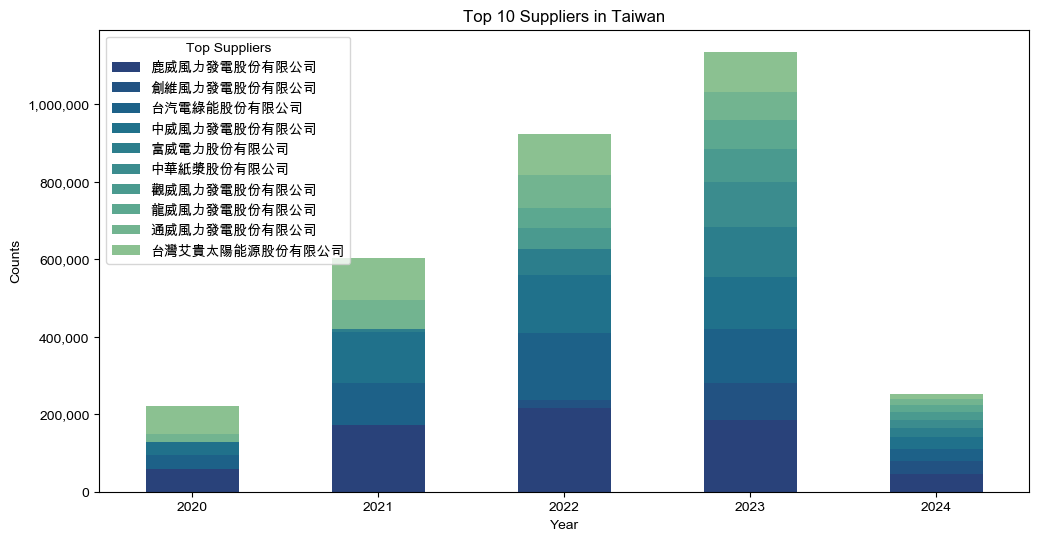

In [19]:
plt.figure(figsize=(12, 6))

# 顯示中文
plt.rcParams['font.family'] = 'Arial Unicode MS'

colors = sns.color_palette('crest_r', len(sorted_pivot_ts.columns))

ax = sorted_pivot_ts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

plt.title('Top 10 Suppliers in Taiwan')
plt.xlabel('Year')
plt.ylabel('Counts')
plt.xticks(rotation=0)

plt.legend(title='Top Suppliers')

# Format the y-axis
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

plt.show()

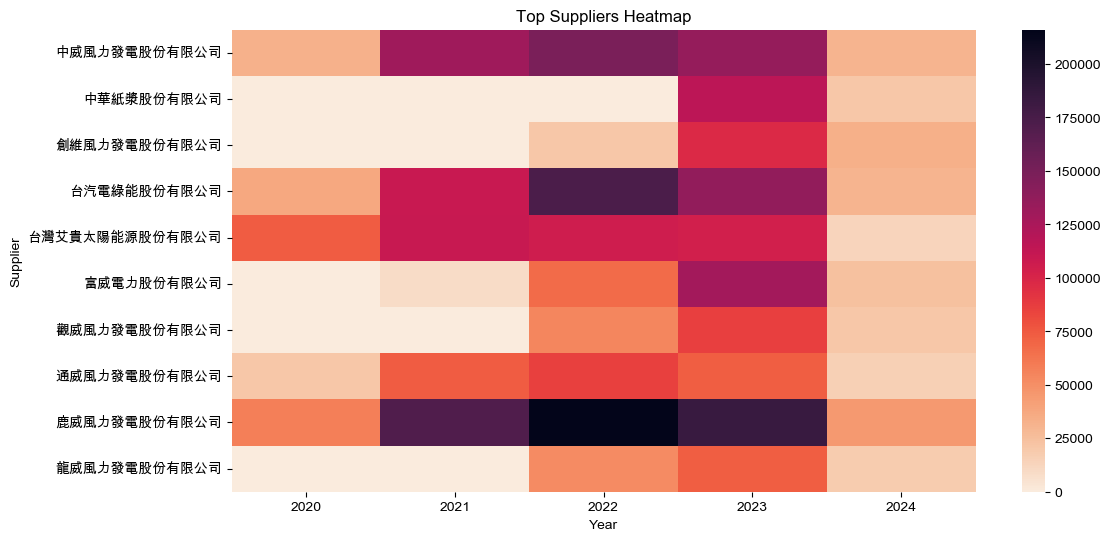

In [21]:
heatmap_data = ts_top.pivot_table(index='Supplier', columns='Year', values='Total')
heatmap_data_filled = heatmap_data.fillna(0)

plt.figure(figsize=(12, 6))

# 顯示中文
plt.rcParams['font.family'] = 'Arial Unicode MS'

sns.heatmap(heatmap_data_filled, cmap='rocket_r')

plt.title('Top Suppliers Heatmap')
plt.xlabel('Year')
plt.ylabel('Supplier')

plt.show()